In [1]:
# in this notebook we fix the intensity values of the intron channel
# read the coeff files from dpy23 and mdh1 
# -> compute average coeff 
# -> write it to file 
# -> use this feature in java code

# NB:
# we fix the intensities because we want the data to be comparable
# but we still don't know the intensity of one intron

In [49]:
# want to see the images inline
%matplotlib inline

# imports
# general 
import os
import glob
from functools import reduce
import re
import csv as csv
# scientific 
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model, datasets
from scipy.stats import norm, gamma
from scipy.optimize import curve_fit
from scipy import special

from scipy.signal import savgol_filter

import pandas as pd

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [22]:
# function for loading one data-set
def load_data(file_path, skiprows_=0):
    data = np.loadtxt(file_path, delimiter = '\t', skiprows=skiprows_)
    # print(data.shape) 
    # handles some weird cases, e.g. when there is no data in the file
    if (len(data.shape) < 2):
        data = data[None, :]
    if (data.shape[1] == 0):
        I = np.array([0])
    else:
        I = data[:, -1]
    return I

In [23]:
# simple gamma function
def g_x(x, a, c):
    return x**(a - 1)*np.exp(-x)/special.gamma(a) + c

In [24]:
folder = '/Users/kkolyva/Desktop/2018-07-31-09-53-32-N2-all-results-together/'

In [25]:
# some const params for all graphs
num_bins = 100; 
# graph [xmin, xmax]
xmin = -0.2
xmax = 1.2

binwidth = (xmax - xmin)/(num_bins - 1)

In [26]:
bins = np.arange(xmin, xmax + binwidth, binwidth)
print ('bins: ', bins.shape)

bins:  (100,)


I_min: 0.03 I_max: 0.68
1.95025048422 0.0278595334041 0.063736684986
peak center: 0.0886886886887


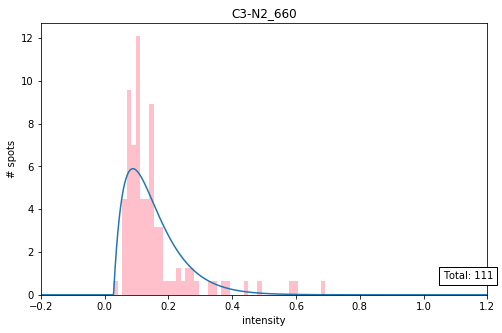

In [42]:
# for testing 
filename = 'C3-N2_660'

filepath =  folder + "csv/" + filename + '.csv'
I = load_data(filepath)

fig = plt.figure(figsize=(8,5))
title = "C3-N2_660"
plt.title(title)
    
plt.xlabel('intensity')
plt.ylabel('# spots')

print("I_min:", np.min(I), "I_max:", np.max(I))

I_res = I
fit_alpha, fit_loc, fit_beta = gamma.fit(I_res)
print(fit_alpha, fit_loc, fit_beta)

plt.hist(I, bins=bins, color='pink', normed=True); # 
# plt.text(0.9*xmax, 0.1, "Total: " + str(I.shape[0]), color='black', bbox=dict(facecolor='white', alpha=1))

info_text = "Total: " + str(I.shape[0])

x_limits = [xmin, xmax]
ymax = np.max(np.histogram(I, bins)[0])
y_limits = [0, ymax]

plt.text(x_limits[1] - (x_limits[1] - x_limits[0])*0.1, y_limits[0] + (y_limits[1] - y_limits[0])*0.04, info_text, color='black', bbox=dict(facecolor='white', alpha=1))
   

x = np.linspace(xmin, xmax, 1000)
y = gamma.pdf(x, fit_alpha, fit_loc, fit_beta)
plt.plot(x,y)

print("peak center:", x[np.argmax(y)])

plt.xlim([xmin, xmax])

# plt.legend(loc = 'upper right')1.2
binwidth = (xmax - xmin)/(num_bins - 1)

In [28]:
# possible labels 
stain = ['DPY-23_INT']
stage = 'E' # only embryos
comment = '' # only empty ones

In [29]:
# important indices
stain_columns = ['C0_stain', 'C1_stain', 'C2_stain', 'C3_stain', 'C4_stain']
type_columns = ['C0_type', 'C1_type', 'C2_type', 'C3_type', 'C4_type']
stain_prefix = np.array([['C1-', 'C2-', 'C3-', 'C4-', 'C5-']])
ext = '.csv'
filename_column = 'new filename'

In [30]:
# read the db and parse images that we want to process
df = pd.read_csv(folder + "smFISH-database/N2-Table 1.csv", sep=',', na_values=['']);
df.head()

Line   ID  C0_lambda C0_stain    C0_type  C1_lambda C1_stain C1_type  \
0   N2  1.0      670.0     FISH  DPY-23_EX      488.0       AF     NaN   
1   N2  2.0      670.0     FISH  DPY-23_EX      488.0       AF     NaN   
2   N2  3.0      670.0     FISH  DPY-23_EX      488.0       AF     NaN   
3   N2  4.0      670.0     FISH  DPY-23_EX      488.0       AF     NaN   
4   N2  5.0      670.0     FISH  DPY-23_EX      488.0       AF     NaN   

   C2_lambda C2_stain    ...                 comment        date  \
0      405.0  NUCLEAR    ...            not complete  11/17/2016   
1      405.0  NUCLEAR    ...                    dirt  11/17/2016   
2      405.0  NUCLEAR    ...      dirt, not complete  11/17/2016   
3      405.0  NUCLEAR    ...                     NaN  11/17/2016   
4      405.0  NUCLEAR    ...            not complete  11/17/2016   

              original filename new filename  #nuclei #C0_smfish #C1_smfish  \
0  2016-11-17_N2-DPY-23-001.nd2         N2_1      2.0        NaN        NaN   
1  2016-11-17_N2-DPY-23-002.nd2         N2_2      4.0        NaN        NaN   
2  2016-11-17_N2-DPY-23-003.nd2         N2_3      1.0        NaN        NaN   
3  2016-11-17_N2-DPY-23-004.nd2         N2_4      1.0        NaN        NaN   
4  2016-11-17_N2-DPY-23-005.nd2         N2_5      3.0        NaN        NaN   

   #C2_smfish  #C3_smfish #C4_smfish  
0         NaN         NaN        NaN  
1         NaN         NaN        NaN  
2         NaN         NaN        NaN  
3         NaN         NaN        NaN  
4         NaN         NaN        NaN  

[5 rows x 30 columns]

In [32]:
# this is general
# filter to have only *good* and *embryo* files
good_indices = np.logical_and((df['stage'] == stage).tolist() , (df['comment'].isnull()).tolist())
good_indices.shape[0]

print(np.sum(good_indices == True))

596


In [33]:
# choose necessary stains
dataset1 = []
df_good = (df[type_columns].astype(np.object) == stain[0]).loc[good_indices, :]
row, col = np.where(df_good)
n_samples = df.shape[0]
new_prefix = np.repeat(stain_prefix, n_samples, axis=0)[row, col]
new_filename = df[filename_column].loc[good_indices].as_matrix()[row]
dataset1 = ["{}{}".format(a_, b_) for a_, b_ in zip(new_prefix, new_filename)]

In [35]:
def create_title(path, name_id=-1):
    # get the name of the initial image
    image_name = path.split("/")[name_id] # was 8
    # print(path.split("/"))
    # create the full title 
    title = image_name[:-4]
    return title
create_title("/Users/kkolyva/Desktop/2018-07-31-09-53-32-N2-all-results-together/csv/C3-N2_395.csv")

'C3-N2_395'

In [36]:
labels = ['DPY-23_INT'] # ['DPY-23_EX', 'WDR-5.2', 'MDH-1']
color = '#BA5536'
# if labels[0] == 'MDH-1':
#     color = "#693D3D"

In [37]:
# actual plotting 
dataset_to_use = dataset1
# if labels[0] == 'MDH-1':
#     dataset_to_use = dataset3
    
dataset = []
p_dataset = []
for j in range(0, len(dataset_to_use)):
    tmp = folder + "csv/" + dataset_to_use[j] + ".csv"
    dataset.append(tmp)
    print(tmp)

/Users/kkolyva/Desktop/2018-07-31-09-53-32-N2-all-results-together/csv/C2-N2_342.csv
/Users/kkolyva/Desktop/2018-07-31-09-53-32-N2-all-results-together/csv/C2-N2_343.csv
/Users/kkolyva/Desktop/2018-07-31-09-53-32-N2-all-results-together/csv/C2-N2_344.csv
/Users/kkolyva/Desktop/2018-07-31-09-53-32-N2-all-results-together/csv/C2-N2_345.csv
/Users/kkolyva/Desktop/2018-07-31-09-53-32-N2-all-results-together/csv/C2-N2_346.csv
/Users/kkolyva/Desktop/2018-07-31-09-53-32-N2-all-results-together/csv/C2-N2_347.csv
/Users/kkolyva/Desktop/2018-07-31-09-53-32-N2-all-results-together/csv/C2-N2_348.csv
/Users/kkolyva/Desktop/2018-07-31-09-53-32-N2-all-results-together/csv/C2-N2_349.csv
/Users/kkolyva/Desktop/2018-07-31-09-53-32-N2-all-results-together/csv/C2-N2_350.csv
/Users/kkolyva/Desktop/2018-07-31-09-53-32-N2-all-results-together/csv/C2-N2_351.csv
/Users/kkolyva/Desktop/2018-07-31-09-53-32-N2-all-results-together/csv/C2-N2_352.csv
/Users/kkolyva/Desktop/2018-07-31-09-53-32-N2-all-results-togethe

In [38]:
# how good is fitter-meter?
def fitter_meter(y, y_hat):
    return [mean_absolute_error(y,y_hat), np.sqrt(mean_squared_error(y,y_hat))]

In [39]:
center_path = folder  + "centers/" + "all-centers.csv"  

error: L1, L2 [3.3543310524769607, 10.700015551609464]
peak center: 0.139393939394


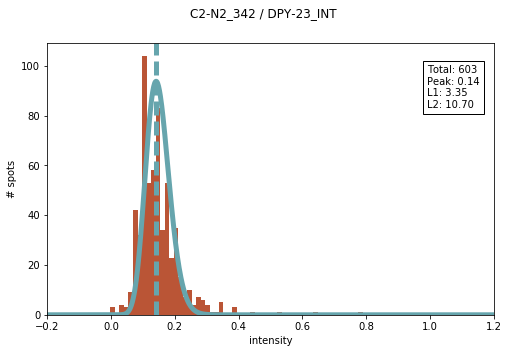

error: L1, L2 [3.2973563813586071, 10.90618811518309]
peak center: 0.139393939394


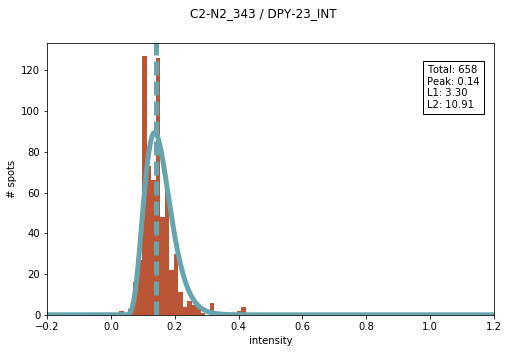

error: L1, L2 [2.3226368813143368, 8.1725871003500306]
peak center: 0.167676767677


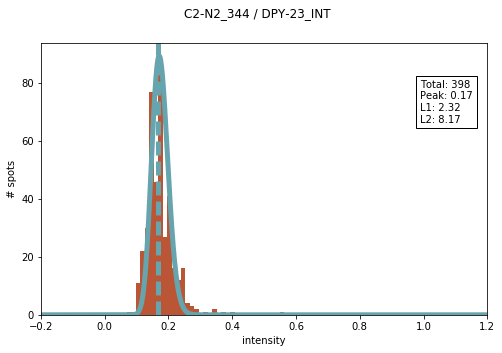

error: L1, L2 [3.8821022456675358, 12.535727805360414]
peak center: 0.167676767677


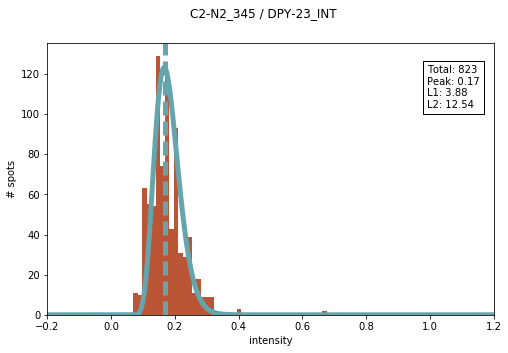

error: L1, L2 [3.3494945455418197, 9.4779012922051784]
peak center: 0.210101010101


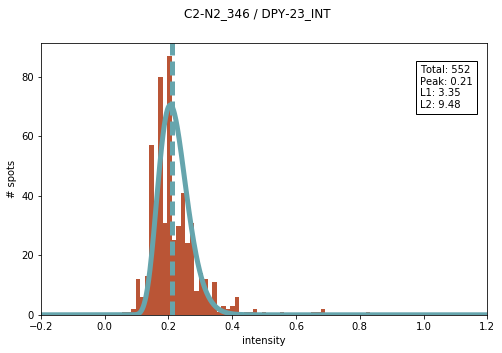

error: L1, L2 [0.42386827851223025, 1.0678908570642089]
peak center: 0.238383838384


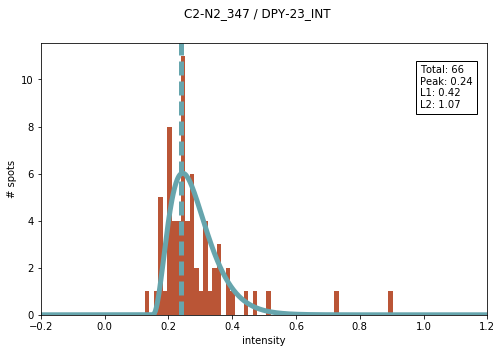

error: L1, L2 [9.195256231066999, 22.207786811898561]
peak center: 0.19595959596


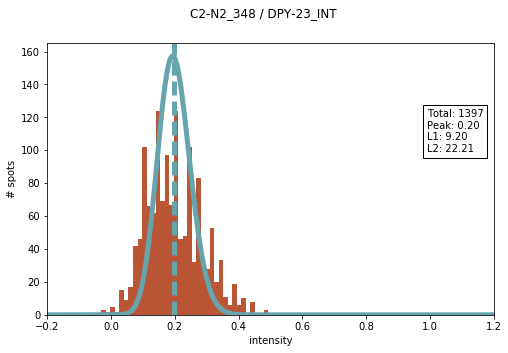

error: L1, L2 [6.5665189636401173, 18.627125845971403]
peak center: 0.181818181818


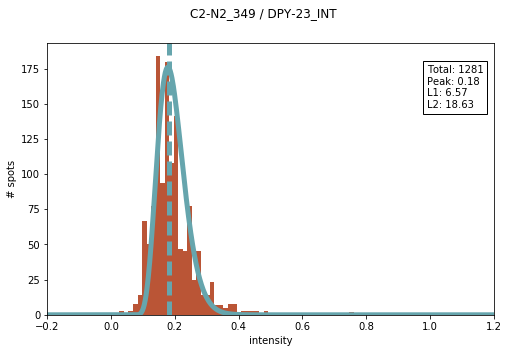

error: L1, L2 [3.7665680013134448, 9.1846497266084857]
peak center: 0.294949494949


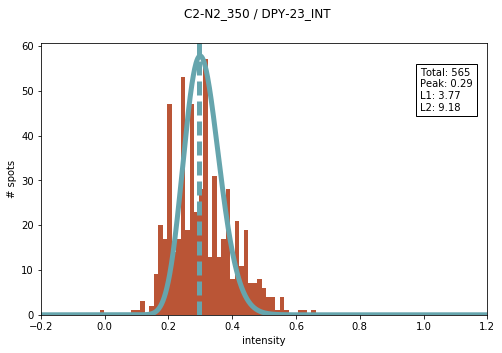

error: L1, L2 [7.3026986832648682, 17.476691269806118]
peak center: 0.19595959596


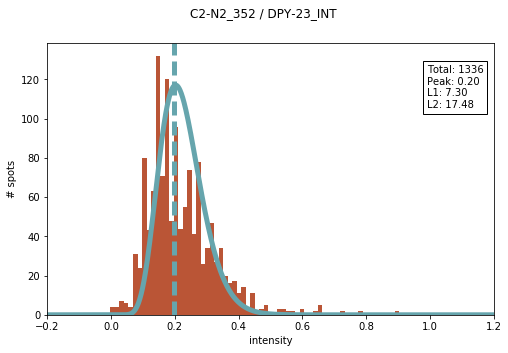

error: L1, L2 [5.5544385315080804, 13.099837681981521]
peak center: 0.181818181818


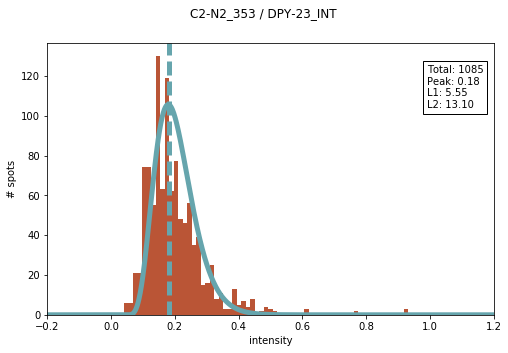

error: L1, L2 [6.2457154923146545, 18.125226896708806]
peak center: 0.210101010101


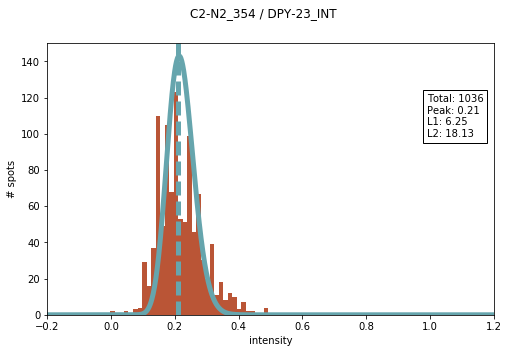

error: L1, L2 [5.9854594753558334, 16.378578909391159]
peak center: 0.181818181818


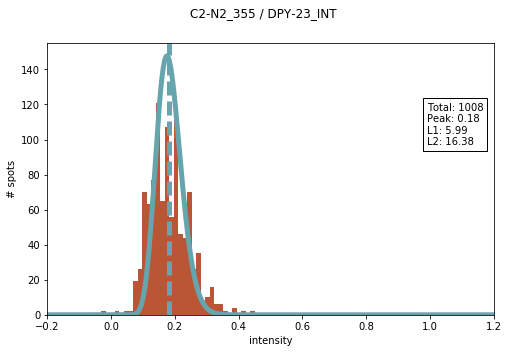

error: L1, L2 [8.0726873257038072, 26.792255078323862]
peak center: 0.111111111111


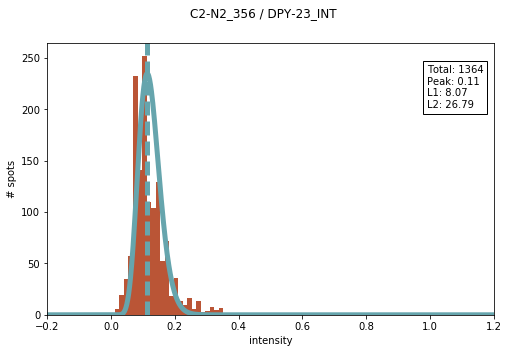

error: L1, L2 [6.249608916767964, 14.277696328460317]
peak center: 0.309090909091


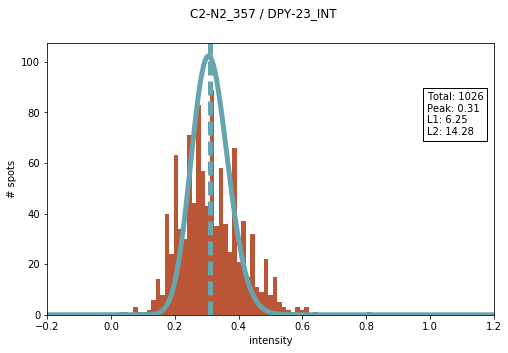

error: L1, L2 [4.932342177134533, 16.618739676419416]
peak center: 0.111111111111


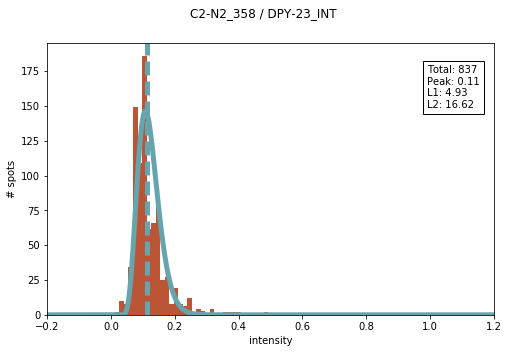

error: L1, L2 [4.7604312752138016, 14.466113058574614]
peak center: 0.153535353535


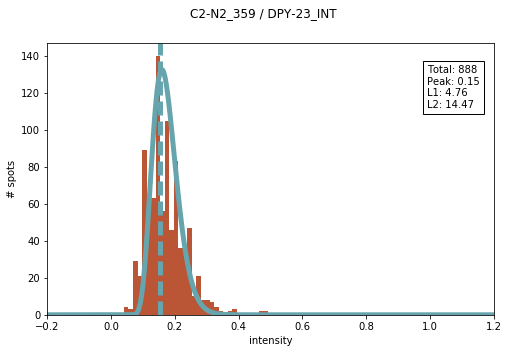

error: L1, L2 [12.431036978877311, 49.729636133697724]
peak center: 0.0545454545455


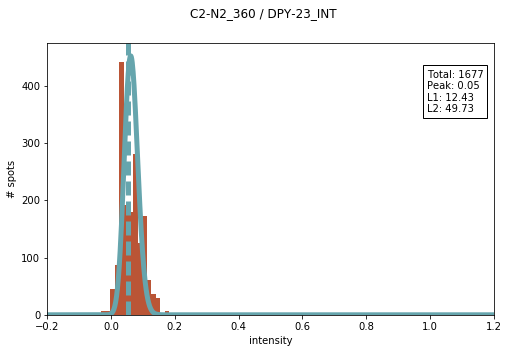

error: L1, L2 [3.3971508475259533, 10.952961647856258]
peak center: 0.139393939394


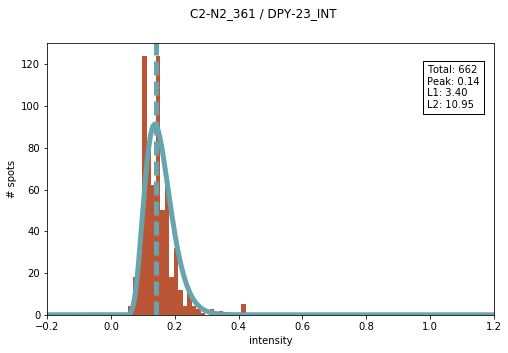

error: L1, L2 [2.3443021399746704, 8.2626373076654964]
peak center: 0.167676767677


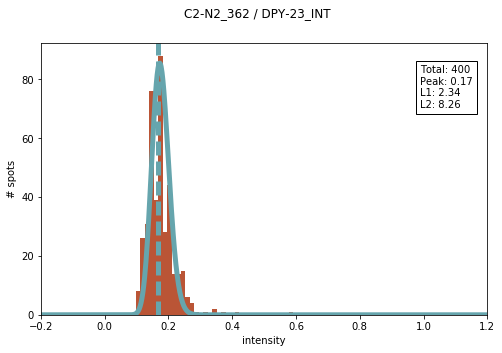

error: L1, L2 [3.2944976595027109, 8.2196994622542139]
peak center: 0.181818181818


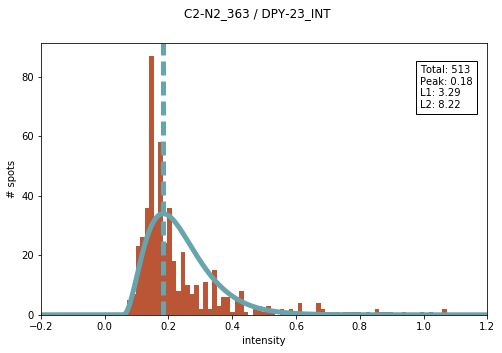

error: L1, L2 [10.436375503372433, 23.990442131318694]
peak center: 0.167676767677


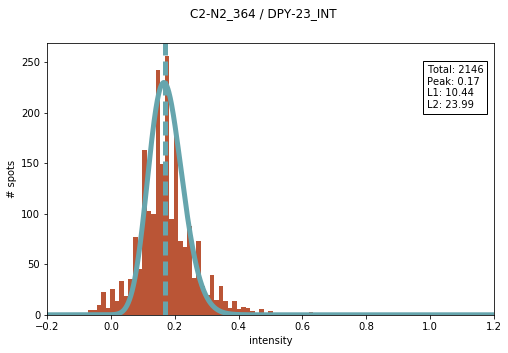

error: L1, L2 [5.2607709270688856, 11.355575386779506]
peak center: 0.337373737374


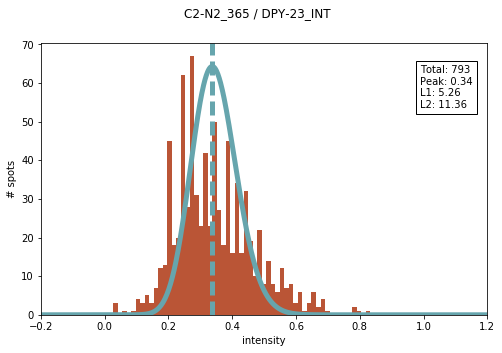

error: L1, L2 [5.7923653172984055, 16.327523577942962]
peak center: 0.167676767677


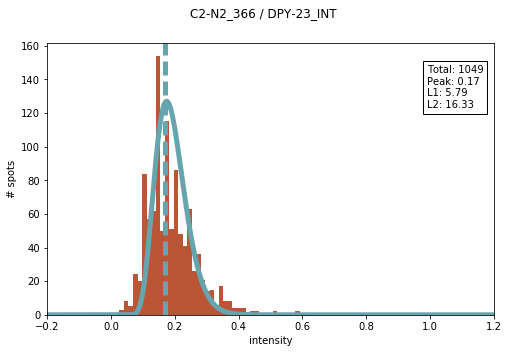

error: L1, L2 [1.4369370297937034, 3.3546034740244157]
peak center: 0.478787878788


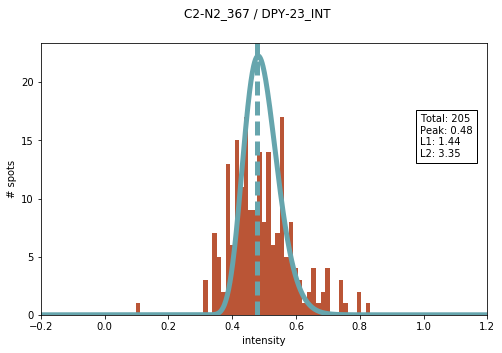

error: L1, L2 [8.0023551184258608, 20.763298843751652]
peak center: 0.19595959596


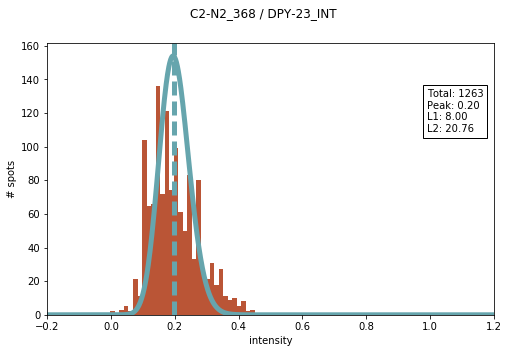

error: L1, L2 [3.6704132411553689, 10.50129195729491]
peak center: 0.19595959596


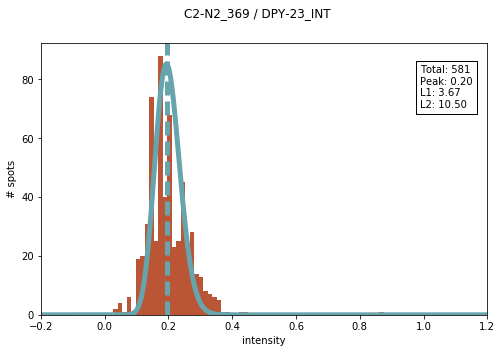

error: L1, L2 [3.4860667174232232, 10.937076984617834]
peak center: 0.125252525253


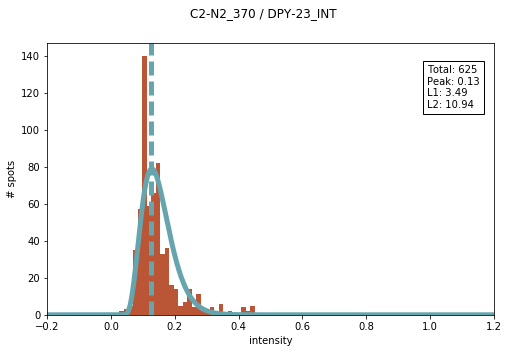

error: L1, L2 [1.9972642713277013, 5.9518803198424886]
peak center: 0.294949494949


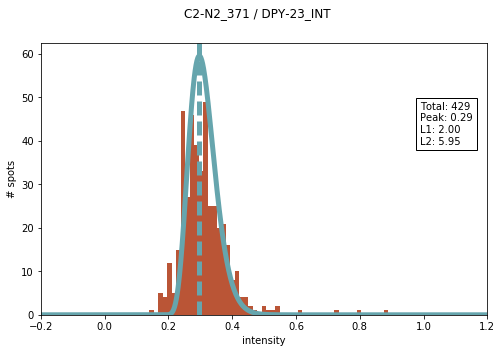

error: L1, L2 [1.2728162831857022, 3.5027724464741863]
peak center: 0.19595959596


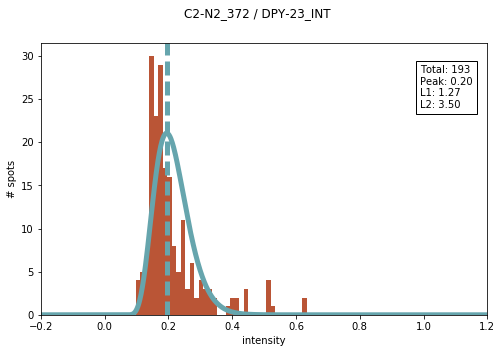

error: L1, L2 [1.4157720748134042, 3.9845606309733341]
peak center: 0.139393939394


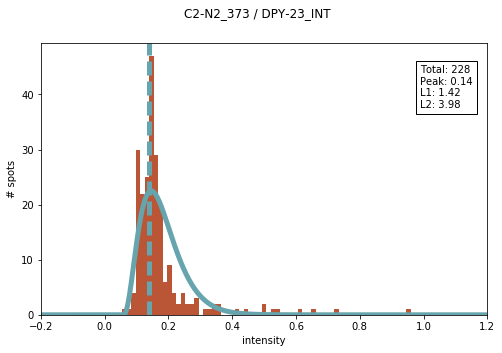

error: L1, L2 [2.5216849443817089, 8.5246763847694051]
peak center: 0.139393939394


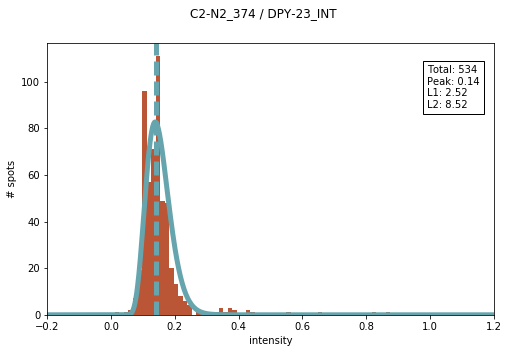

error: L1, L2 [2.7553938876473518, 7.5688136751261776]
peak center: 0.139393939394


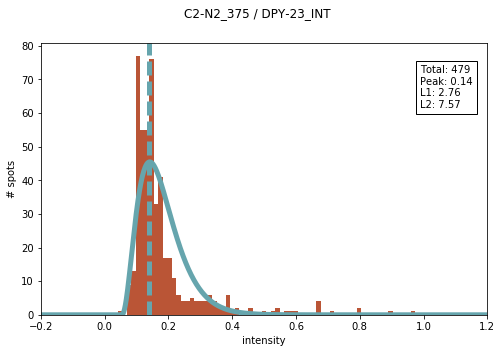

error: L1, L2 [4.5436514384542859, 12.810462879190686]
peak center: 0.153535353535


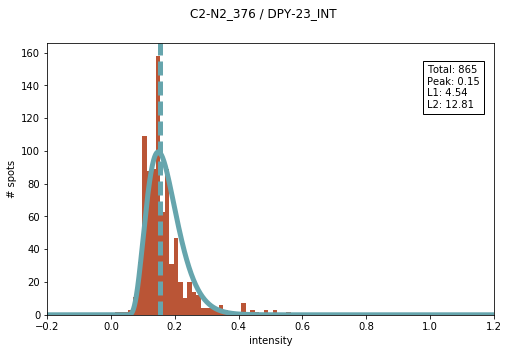

error: L1, L2 [2.6619974240374935, 10.298447023585487]
peak center: 0.125252525253


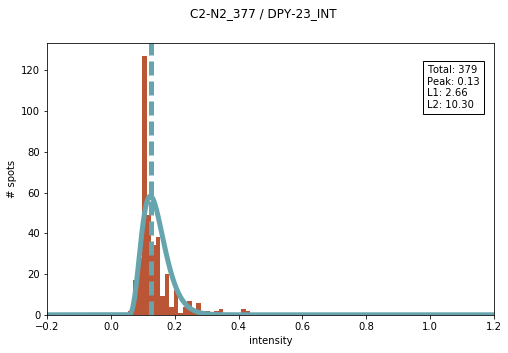

error: L1, L2 [3.7328508811381447, 14.609617150696291]
peak center: 0.0686868686869


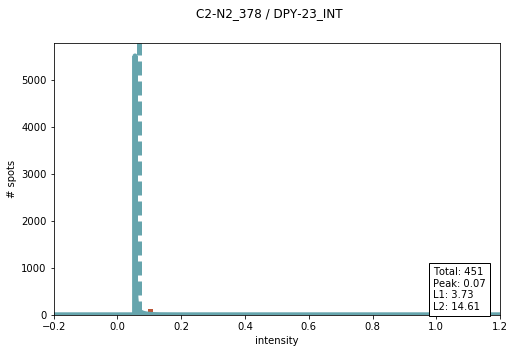

error: L1, L2 [6.8885063331189498, 18.339762077109487]
peak center: 0.19595959596


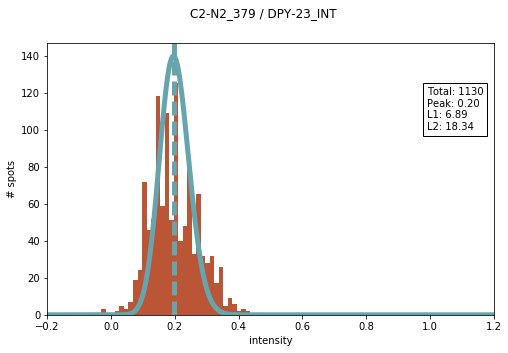

error: L1, L2 [7.4631617498577558, 17.820912374680731]
peak center: 0.210101010101


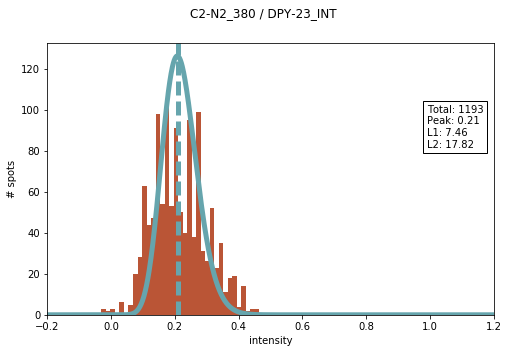

error: L1, L2 [2.7312376846705724, 9.5448918350918568]
peak center: 0.153535353535


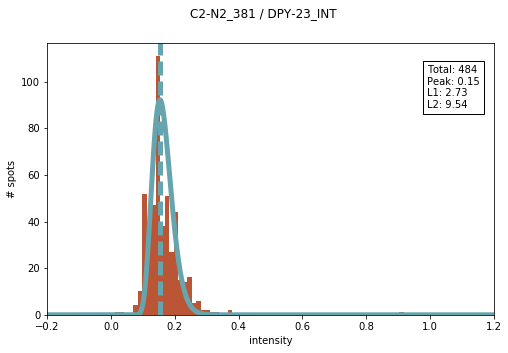

error: L1, L2 [2.9795168817539412, 9.2370136157196114]
peak center: 0.111111111111


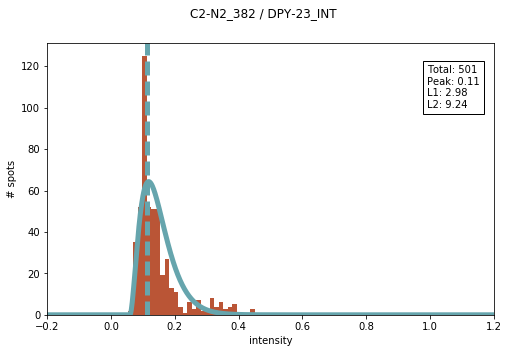

error: L1, L2 [3.2442653299559501, 9.2644642598938489]
peak center: 0.181818181818


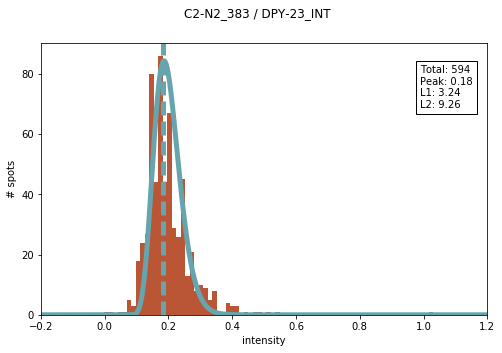

error: L1, L2 [7.3408581764880685, 15.030040149488034]
peak center: 0.351515151515


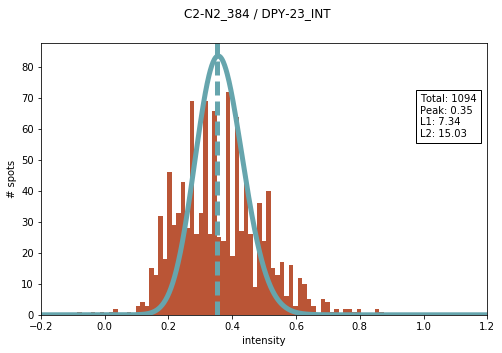

error: L1, L2 [9.7835177107338449, 22.845419490298493]
peak center: 0.181818181818


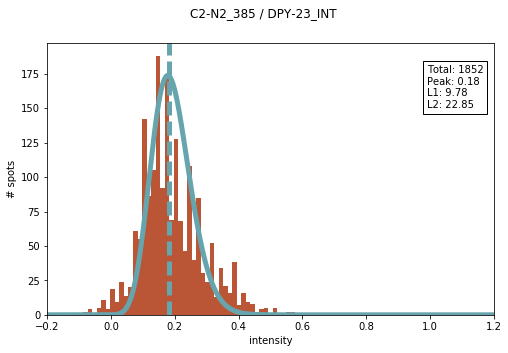

error: L1, L2 [12.202820203912049, 26.078783682582337]
peak center: 0.210101010101


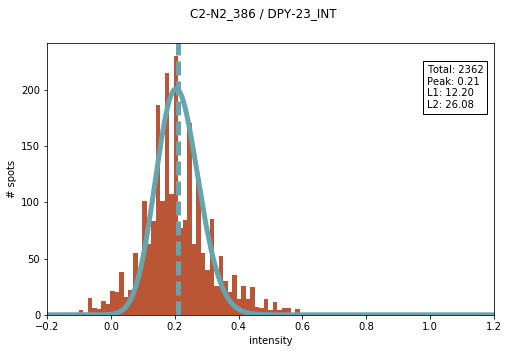

error: L1, L2 [1.8258652348205222, 7.4439256755035759]
peak center: 0.0969696969697


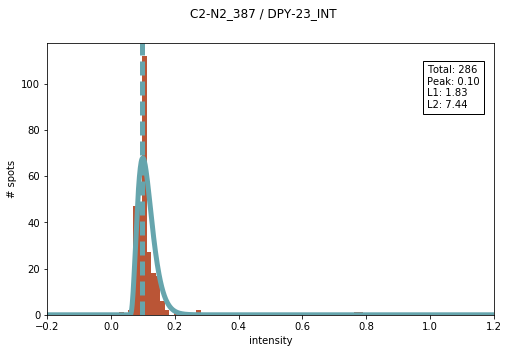

error: L1, L2 [1.5290471549157869, 4.5967617928270981]
peak center: 0.139393939394


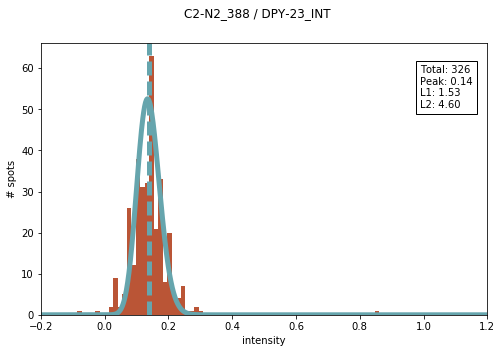

error: L1, L2 [3.9189094267372022, 11.454981580091568]
peak center: 0.139393939394


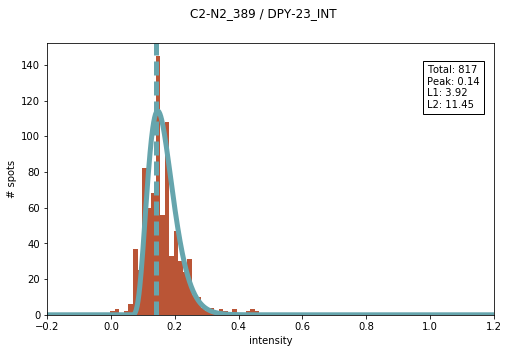

error: L1, L2 [5.2021627804088642, 13.494499415141892]
peak center: 0.19595959596


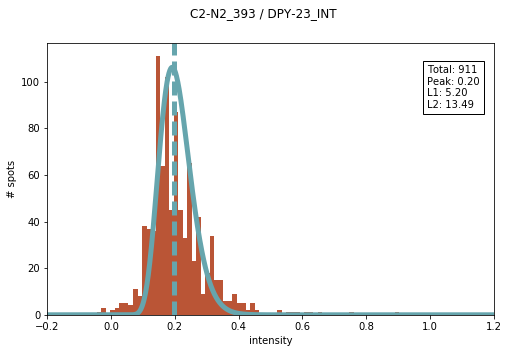

error: L1, L2 [3.3887589080763156, 11.813997275621492]
peak center: 0.139393939394


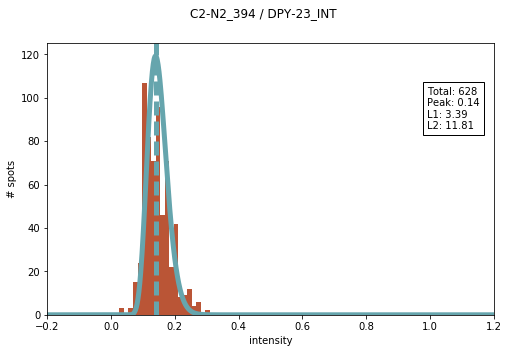

error: L1, L2 [4.3120030650098107, 13.357501247284818]
peak center: 0.139393939394


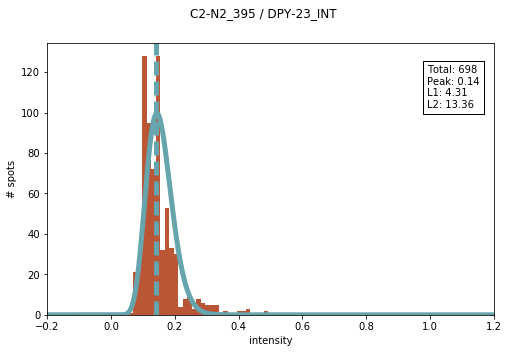

error: L1, L2 [2.6514622160917933, 8.0421272473447125]
peak center: 0.181818181818


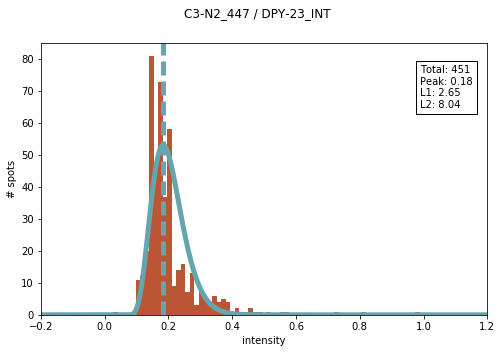

error: L1, L2 [1.4978733828429589, 4.3539150890984848]
peak center: 0.125252525253


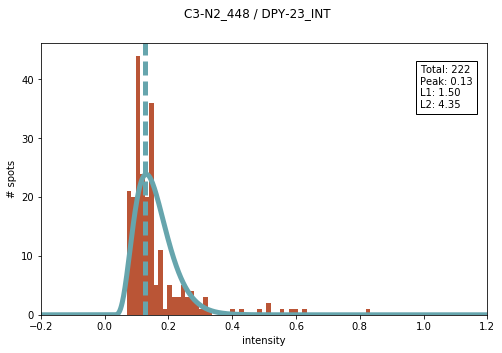

error: L1, L2 [1.9992429636927749, 6.0369143135791141]
peak center: 0.181818181818


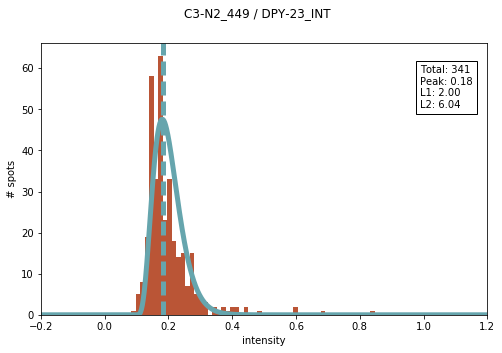

error: L1, L2 [8.6181349620370789, 24.114225788030772]
peak center: 0.153535353535


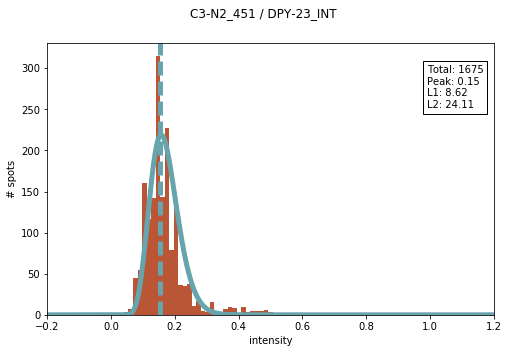

error: L1, L2 [3.0897626106477345, 11.905694247607578]
peak center: 0.139393939394


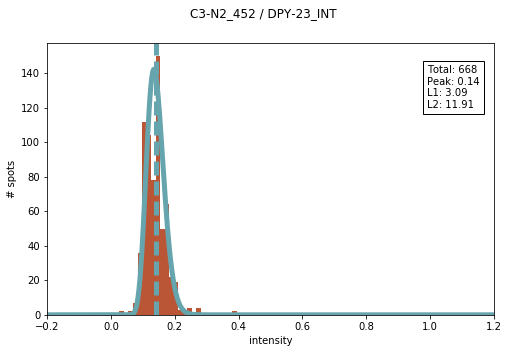

error: L1, L2 [3.4575631765091033, 9.8012209772434744]
peak center: 0.153535353535


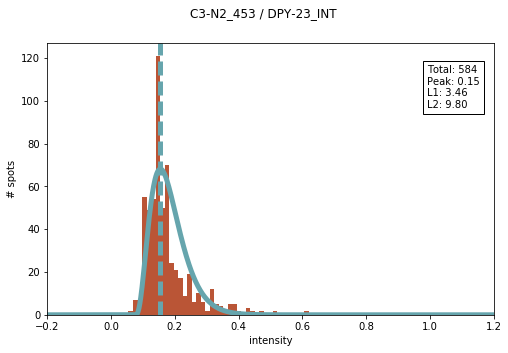

error: L1, L2 [4.7789155232096823, 16.434534563265053]
peak center: 0.139393939394


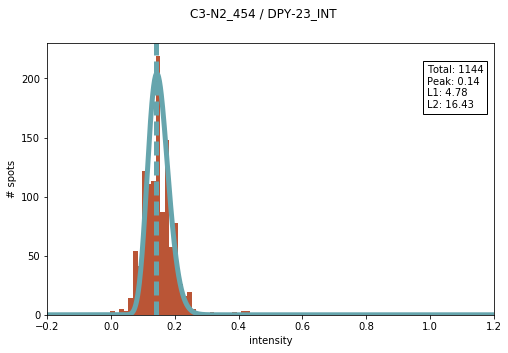

error: L1, L2 [0.97939714239342446, 2.4165320762309053]
peak center: 0.266666666667


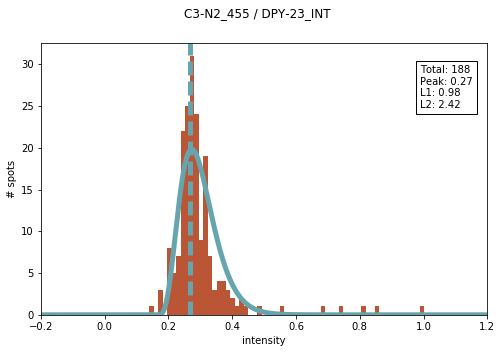

error: L1, L2 [1.0630624494957681, 3.8518844389737605]
peak center: 0.125252525253


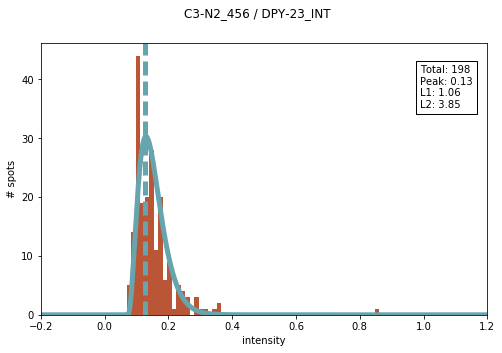

error: L1, L2 [3.4615034313718263, 10.189650905034464]
peak center: 0.139393939394


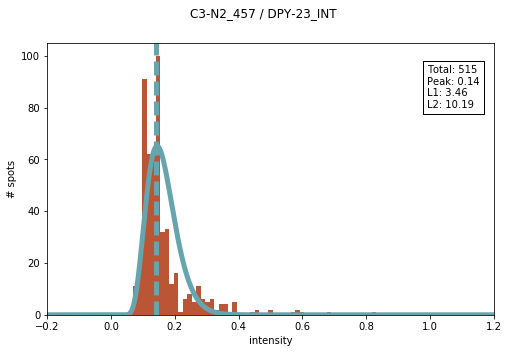

error: L1, L2 [5.5339230228286365, 17.571872557679573]
peak center: 0.125252525253


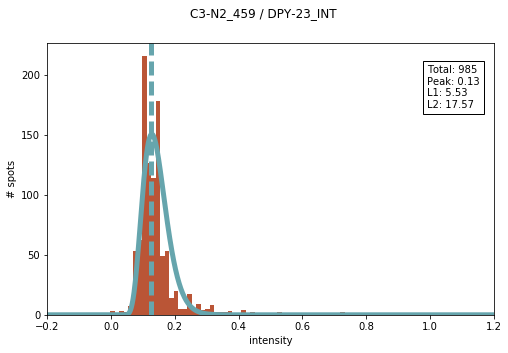

error: L1, L2 [9.3247653727436646, 26.331516507436607]
peak center: 0.181818181818


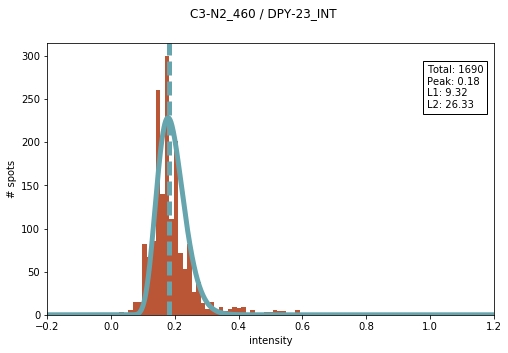

error: L1, L2 [8.3336863597772712, 22.891828190451307]
peak center: 0.153535353535


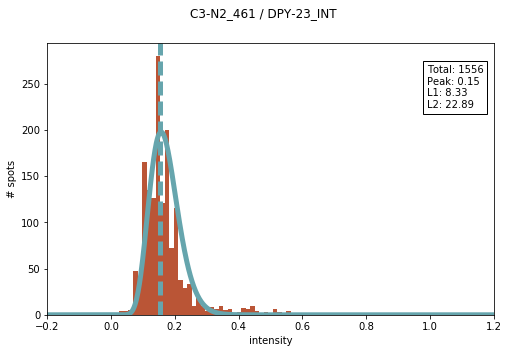

error: L1, L2 [8.1625417347622538, 22.62300009202357]
peak center: 0.19595959596


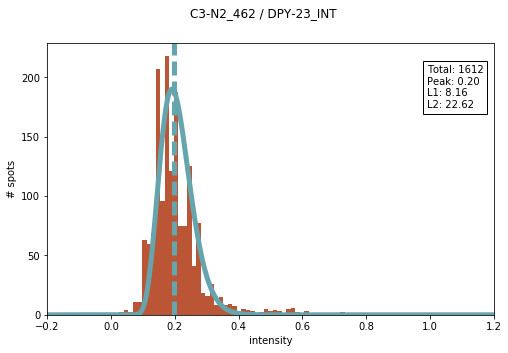

error: L1, L2 [16.432379915880102, 63.349894559026588]
peak center: 0.0545454545455


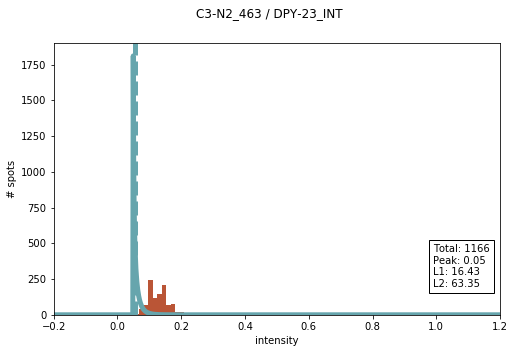

error: L1, L2 [4.3845629280917047, 16.374406451641107]
peak center: 0.0969696969697


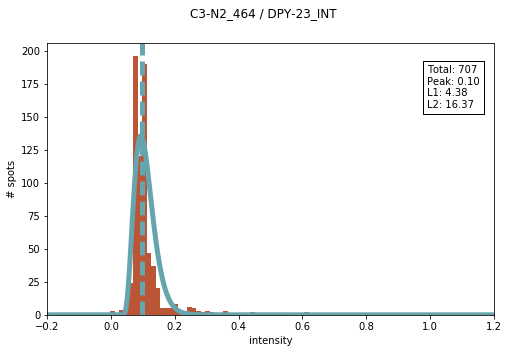

error: L1, L2 [7.9705687932268017, 22.384161918270852]
peak center: 0.167676767677


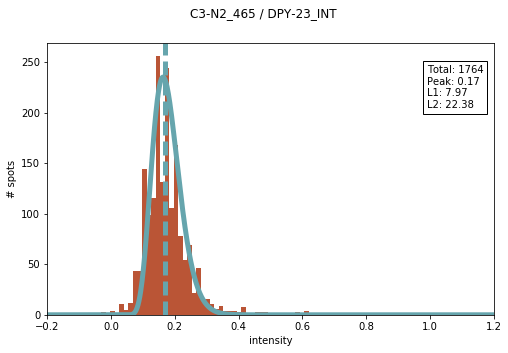

error: L1, L2 [11.047627183620529, 23.540779325629245]
peak center: 0.19595959596


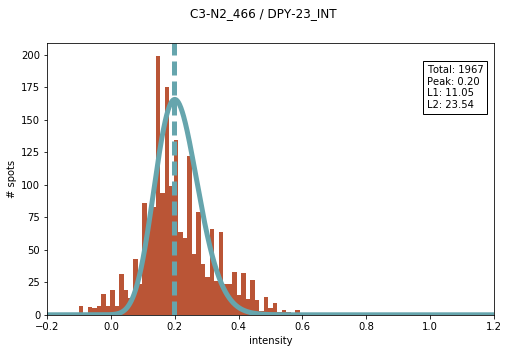

error: L1, L2 [3.4317906744726212, 11.526315133015034]
peak center: 0.125252525253


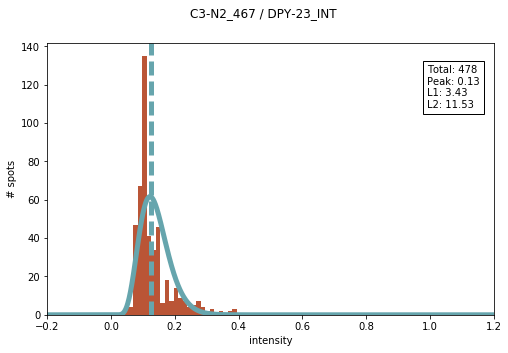

error: L1, L2 [3.8732473063966775, 12.457089245522592]
peak center: 0.111111111111


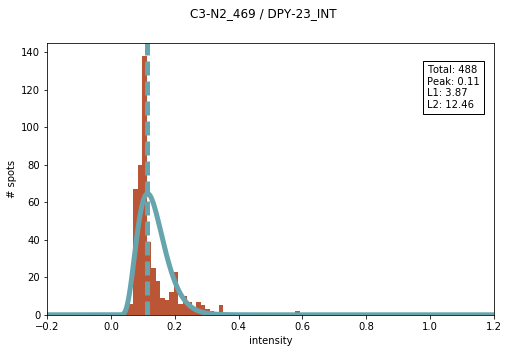

error: L1, L2 [3.0703309577552655, 9.6941660643013154]
peak center: 0.125252525253


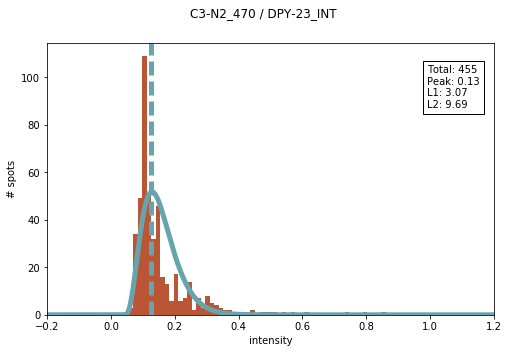

error: L1, L2 [1.3674693181080164, 2.8976999792379594]
peak center: 0.408080808081


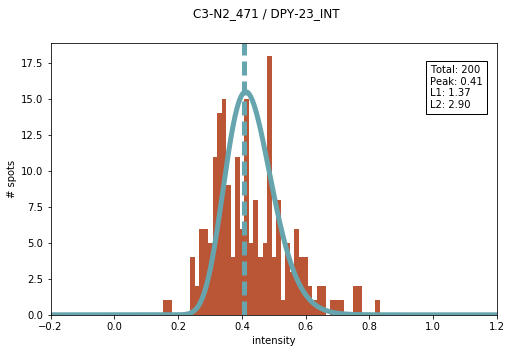

error: L1, L2 [8.1251839433593318, 21.707491354954108]
peak center: 0.153535353535


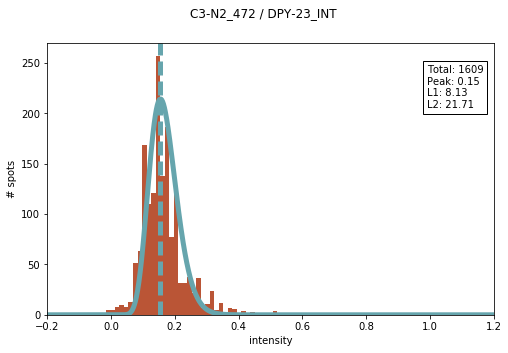

error: L1, L2 [4.619579086419944, 14.874673249952092]
peak center: 0.125252525253


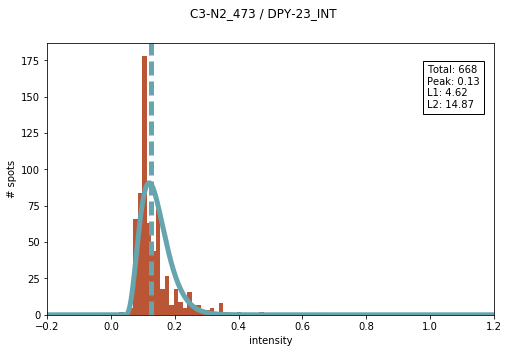

error: L1, L2 [9.3083999320565471, 22.306509430071898]
peak center: 0.181818181818


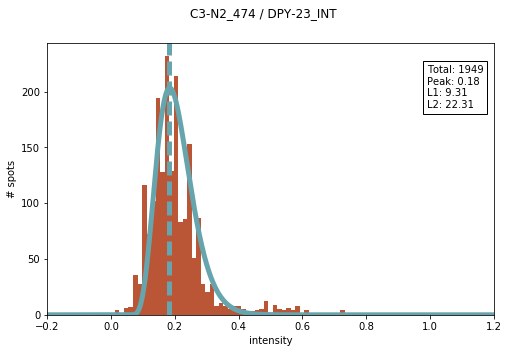

error: L1, L2 [4.7176275417796036, 16.340115349172301]
peak center: 0.125252525253


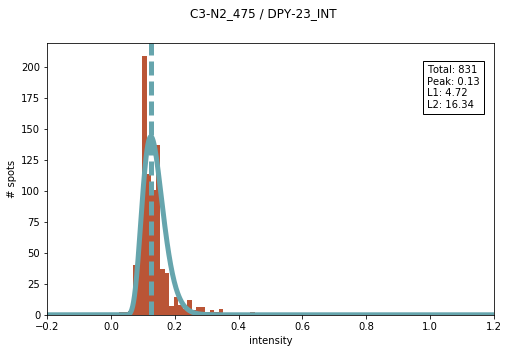

error: L1, L2 [14.81292056309052, 42.292302690492917]
peak center: 0.125252525253


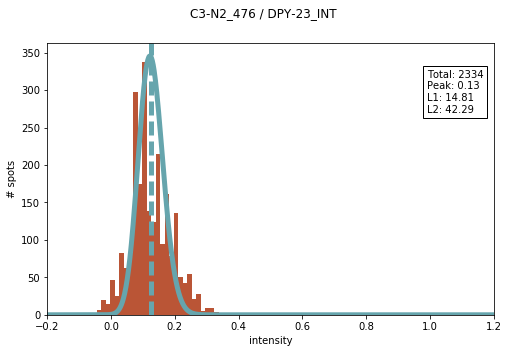

error: L1, L2 [5.5135171624452539, 19.519822002744739]
peak center: 0.0969696969697


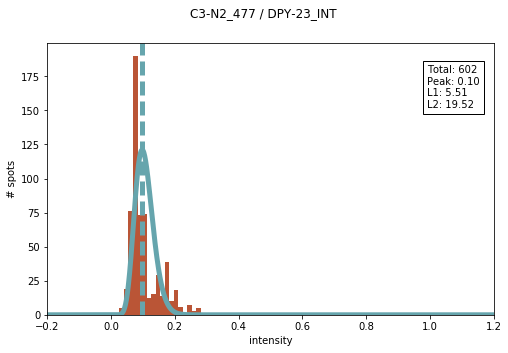

error: L1, L2 [5.7204223268007892, 16.130422469364532]
peak center: 0.181818181818


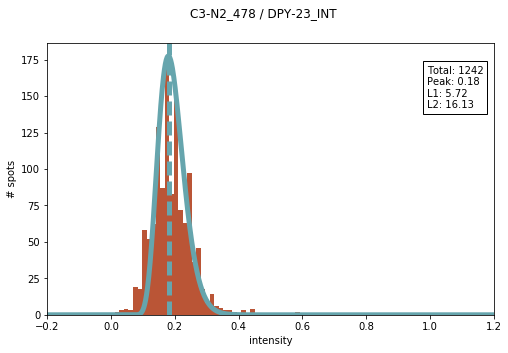

error: L1, L2 [3.6482826942316997, 13.915606335779739]
peak center: 0.0969696969697


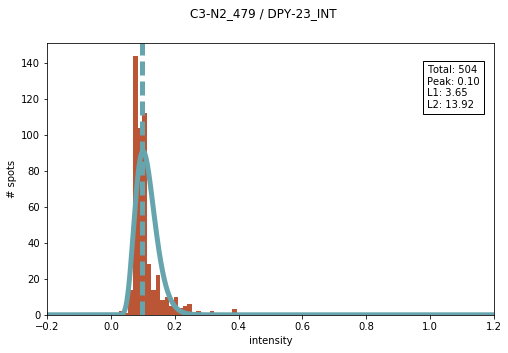

error: L1, L2 [8.9146166887964888, 21.941531247600171]
peak center: 0.167676767677


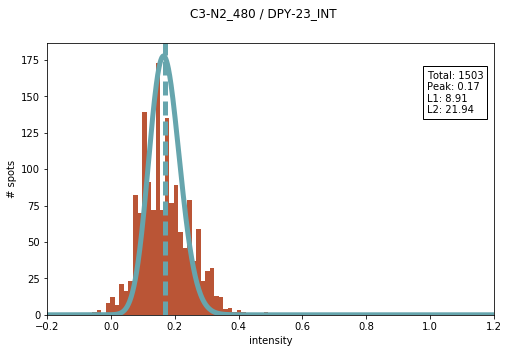

error: L1, L2 [7.3057936446984897, 17.696727924532855]
peak center: 0.210101010101


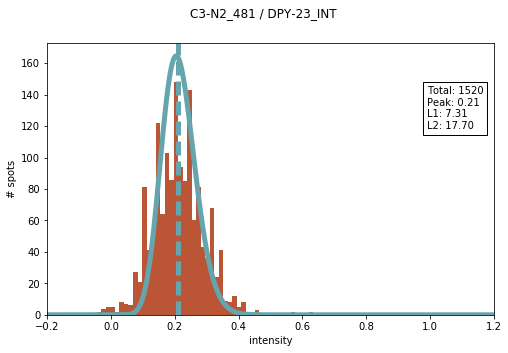

error: L1, L2 [8.8895200800246137, 19.537258195257568]
peak center: 0.238383838384


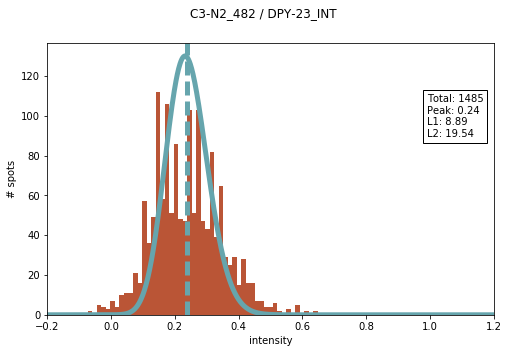

error: L1, L2 [8.0031885521936292, 23.038728779904925]
peak center: 0.167676767677


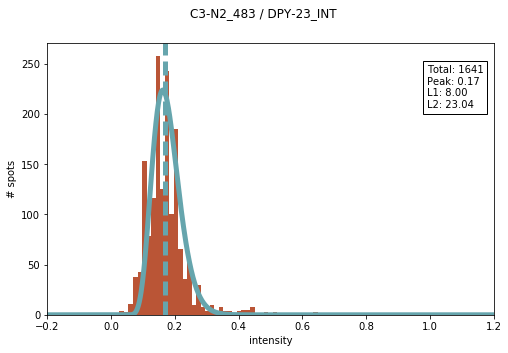

error: L1, L2 [4.068987287824279, 15.436248556539512]
peak center: 0.125252525253


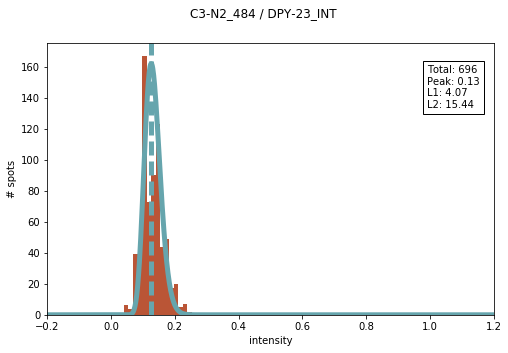

error: L1, L2 [8.0024025598544242, 23.307725033148781]
peak center: 0.153535353535


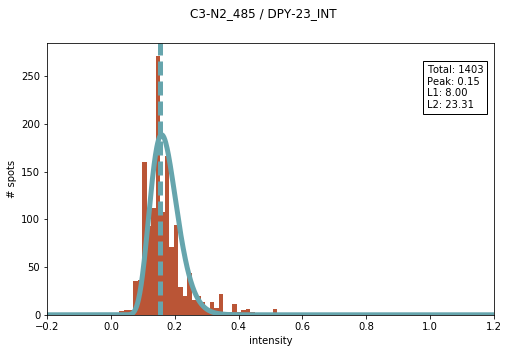

error: L1, L2 [5.2406828890142574, 15.840242619952106]
peak center: 0.139393939394


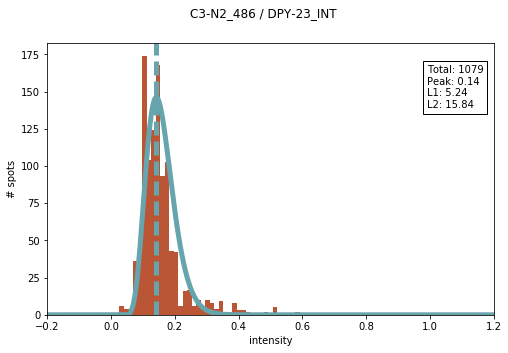

error: L1, L2 [8.7948207470847937, 22.393843492319846]
peak center: 0.167676767677


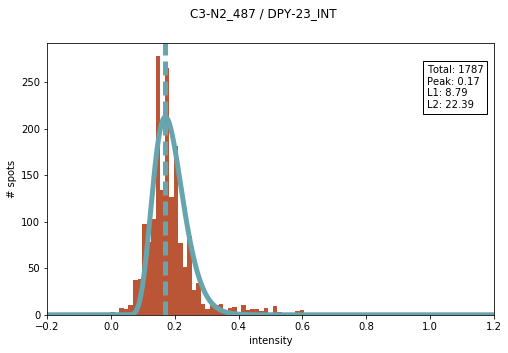

error: L1, L2 [8.4731187027633119, 18.999929359209233]
peak center: 0.238383838384


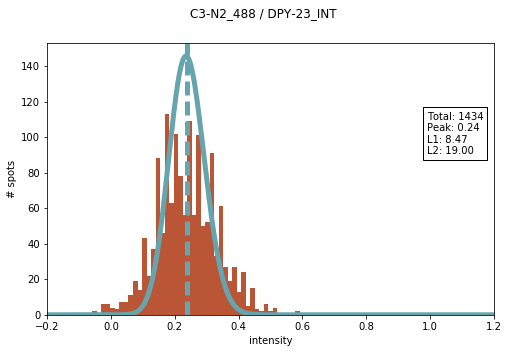

error: L1, L2 [9.7147512389487591, 25.023780212679867]
peak center: 0.167676767677


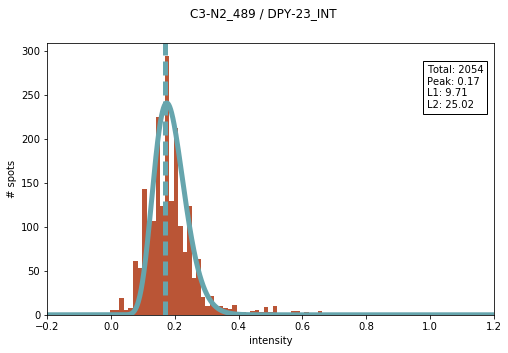

error: L1, L2 [4.8570988309914274, 14.256288478234566]
peak center: 0.167676767677


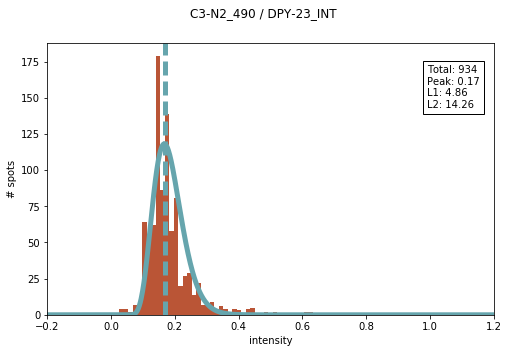

error: L1, L2 [6.0669237335702304, 21.831415061900969]
peak center: 0.111111111111


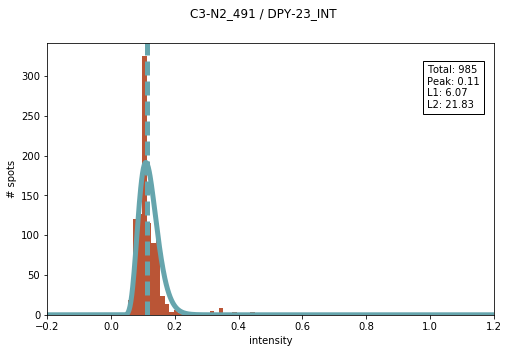

error: L1, L2 [8.8088958164585662, 24.487001095452342]
peak center: 0.153535353535


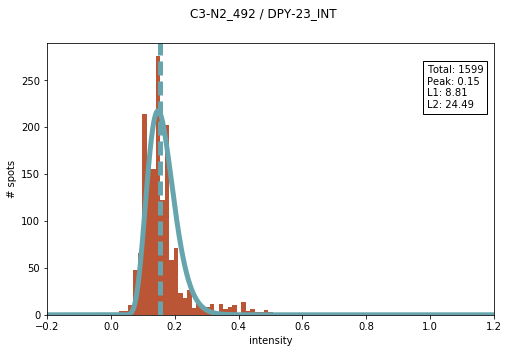

error: L1, L2 [7.0342858981381262, 22.146323340047125]
peak center: 0.139393939394


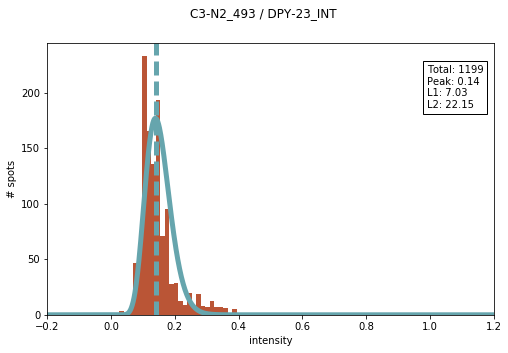

error: L1, L2 [1.9638351411124002, 6.6890570523858033]
peak center: 0.0828282828283


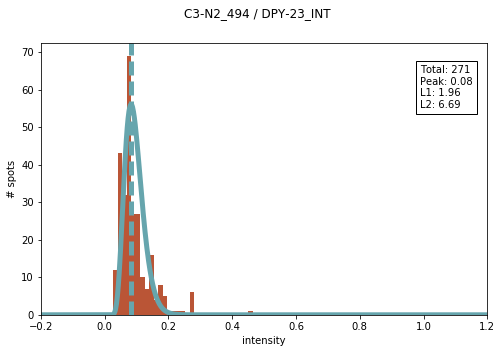

error: L1, L2 [5.0528764880619166, 16.434548165929332]
peak center: 0.125252525253


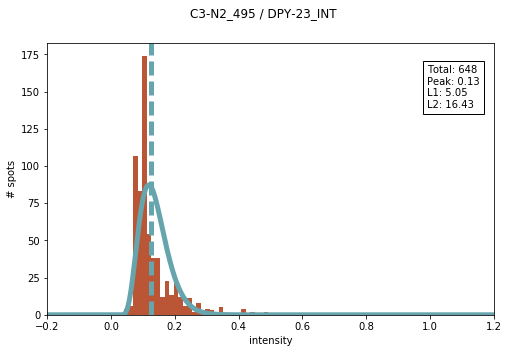

error: L1, L2 [4.3368001074896112, 14.575329672612291]
peak center: 0.139393939394


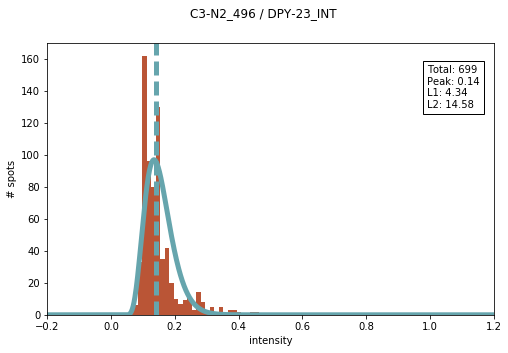

error: L1, L2 [7.1422859214246968, 24.415475331459525]
peak center: 0.139393939394


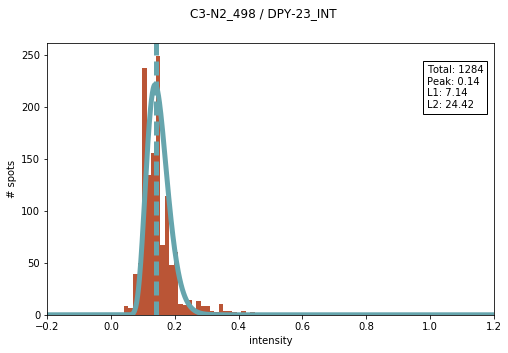

error: L1, L2 [8.149965845461379, 21.521996553084538]
peak center: 0.19595959596


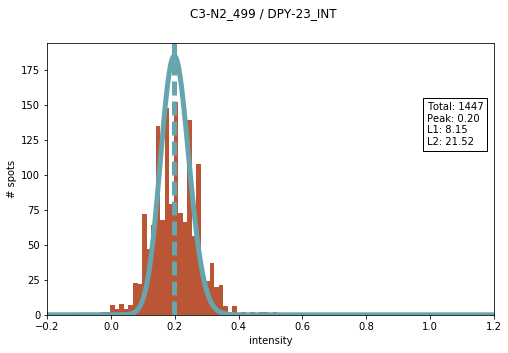

error: L1, L2 [6.6792879332720698, 20.996865600604217]
peak center: 0.111111111111


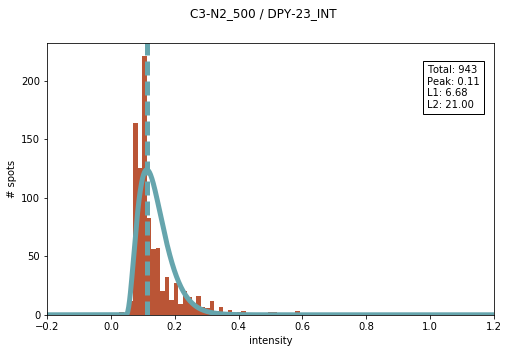

error: L1, L2 [4.200159767000887, 13.728803911364935]
peak center: 0.125252525253


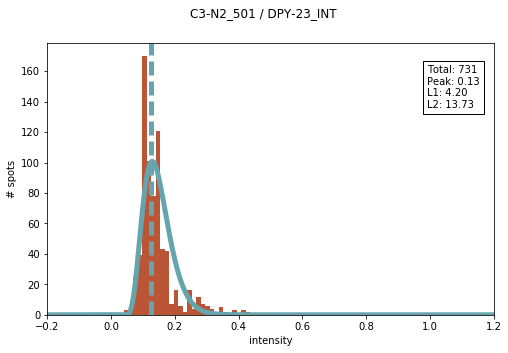

error: L1, L2 [4.5799320026665091, 12.373176849015648]
peak center: 0.153535353535


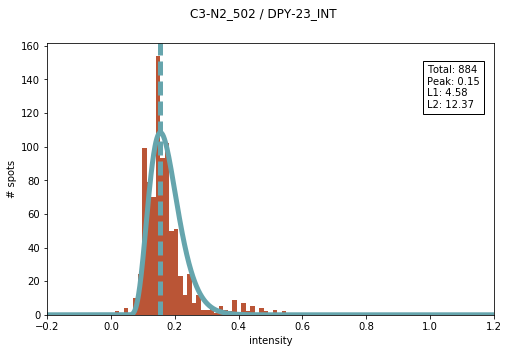

error: L1, L2 [8.7817324541363799, 24.017964227985463]
peak center: 0.167676767677


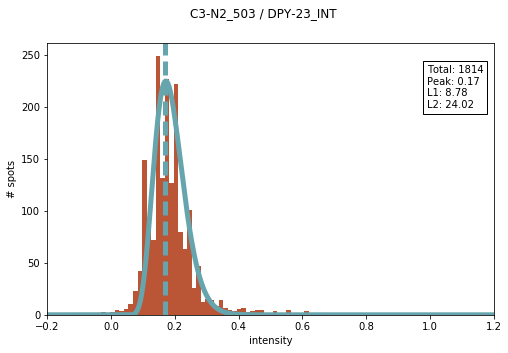

error: L1, L2 [6.8728149977844977, 18.803965576547213]
peak center: 0.181818181818


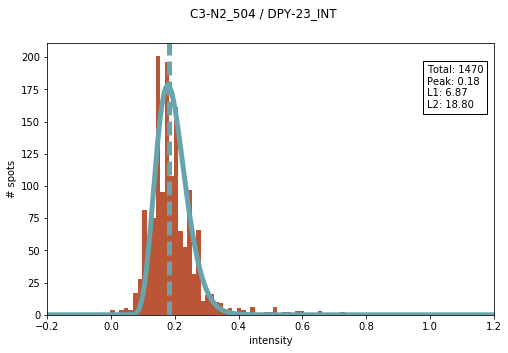

error: L1, L2 [5.1852920476834266, 14.256350071936046]
peak center: 0.153535353535


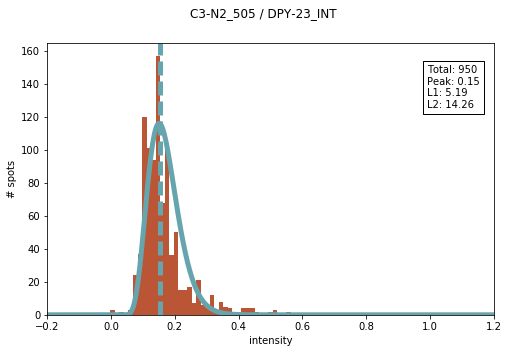

error: L1, L2 [9.9957254877823409, 24.312638335945461]
peak center: 0.181818181818


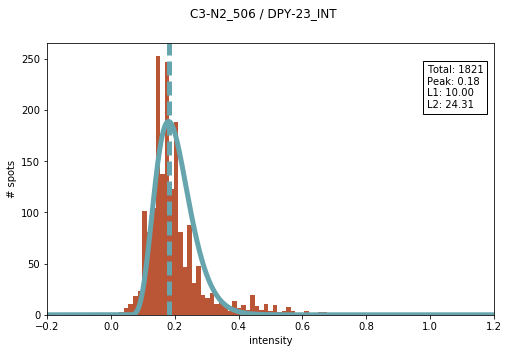

error: L1, L2 [7.711444802313431, 21.526426968216786]
peak center: 0.139393939394


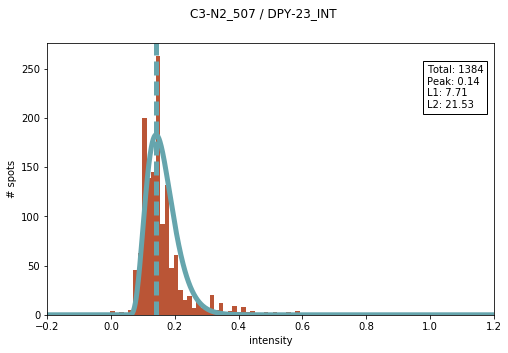

error: L1, L2 [5.7159700999202192, 15.709584756782132]
peak center: 0.181818181818


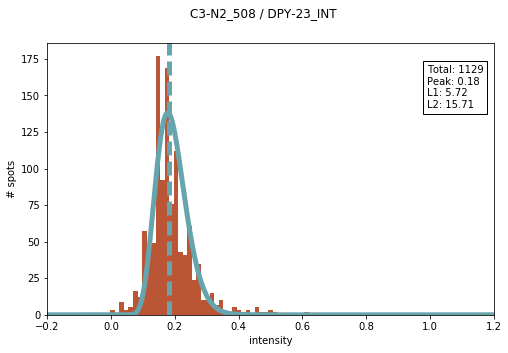

error: L1, L2 [11.619093787741129, 27.00331374393496]
peak center: 0.19595959596


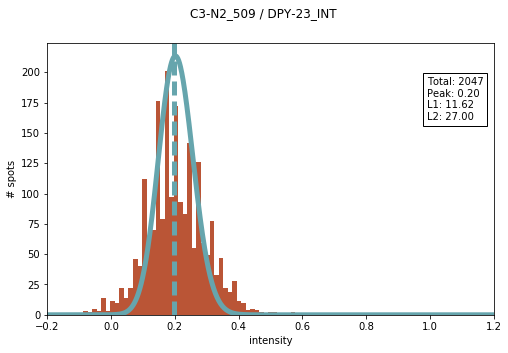

error: L1, L2 [3.3506098338918853, 10.532520007972122]
peak center: 0.139393939394


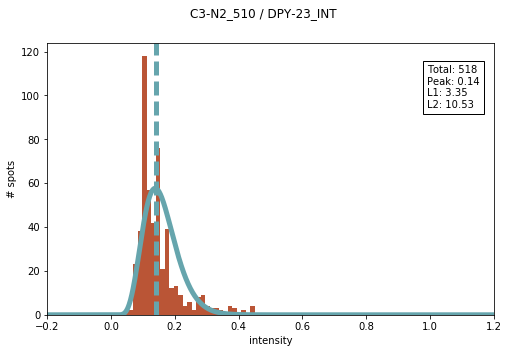

error: L1, L2 [3.0921754782883055, 10.499160271672316]
peak center: 0.125252525253


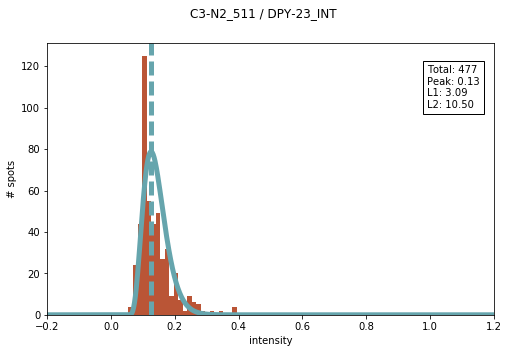

error: L1, L2 [8.118767705431603, 21.298630874824617]
peak center: 0.153535353535


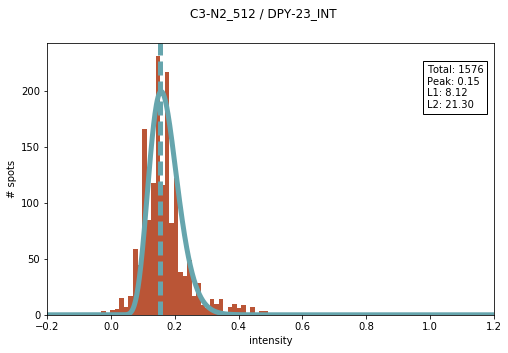

error: L1, L2 [3.715633446382208, 11.517573016373246]
peak center: 0.139393939394


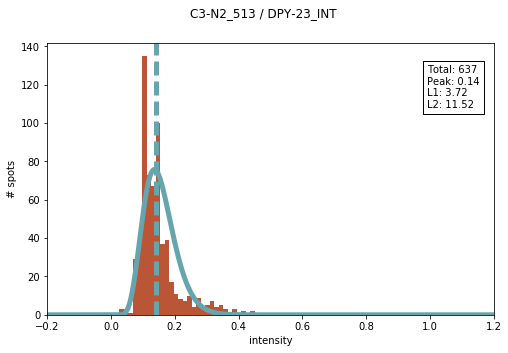

error: L1, L2 [5.1835450396037013, 12.07466637393548]
peak center: 0.238383838384


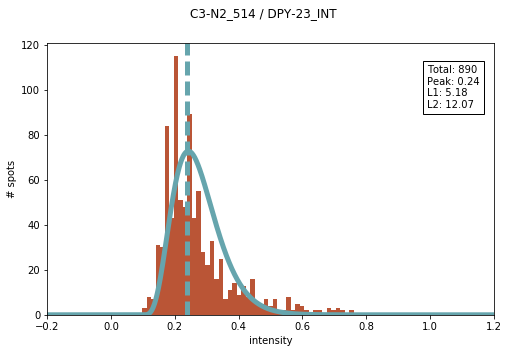

error: L1, L2 [3.6354464074690696, 9.2463144426722703]
peak center: 0.252525252525


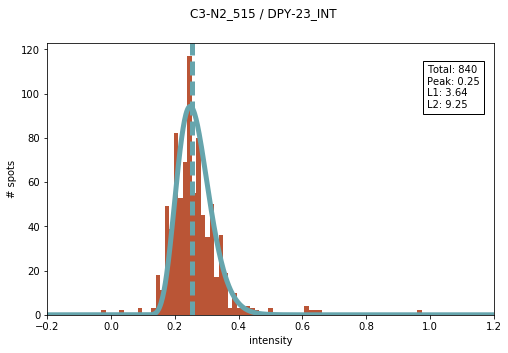

error: L1, L2 [5.3159031297375439, 14.682584299692854]
peak center: 0.167676767677


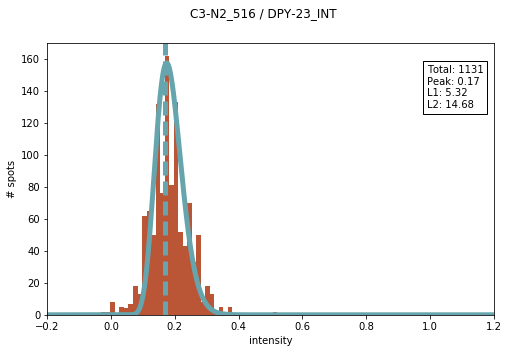

error: L1, L2 [3.1556982250973968, 8.6486058527771412]
peak center: 0.153535353535


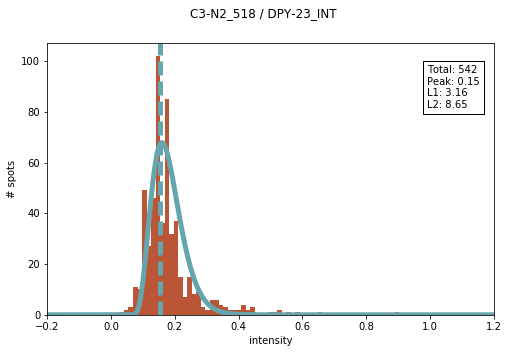

error: L1, L2 [1.2591300921366542, 3.5606991247555011]
peak center: 0.167676767677


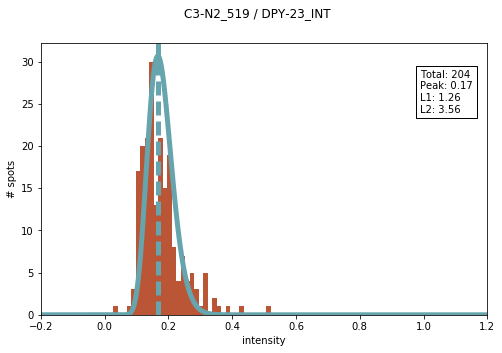

error: L1, L2 [1.7720858245705038, 6.098676386792877]
peak center: 0.125252525253


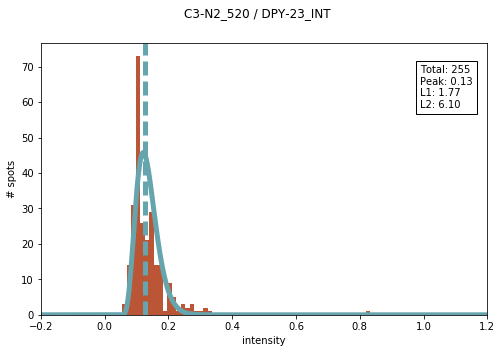

error: L1, L2 [4.9179744472252658, 16.499332257870229]
peak center: 0.111111111111


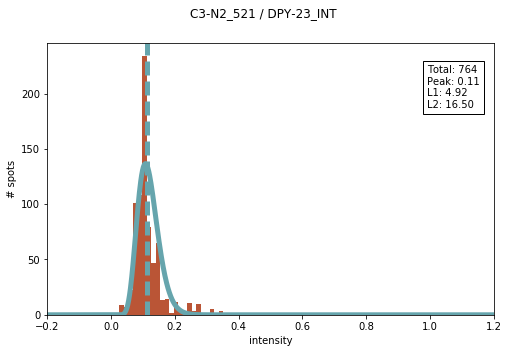

error: L1, L2 [7.7718931999788996, 24.474934372670013]
peak center: 0.139393939394


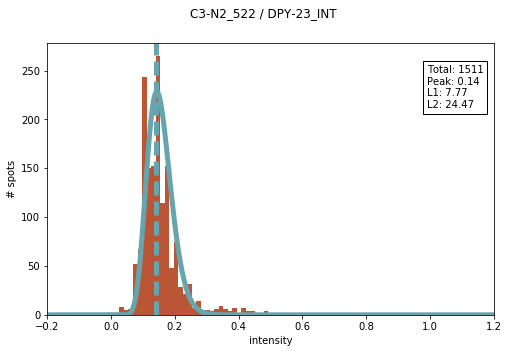

error: L1, L2 [9.3010409345173173, 25.024946132231577]
peak center: 0.153535353535


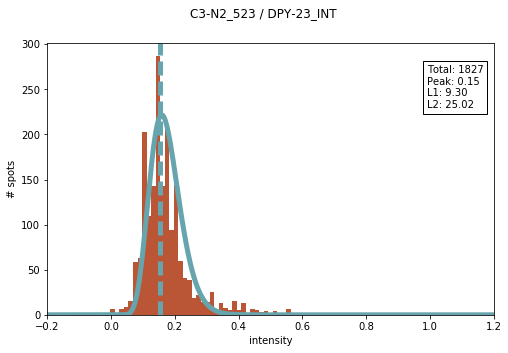

error: L1, L2 [11.099295220427145, 25.200909407628068]
peak center: 0.181818181818


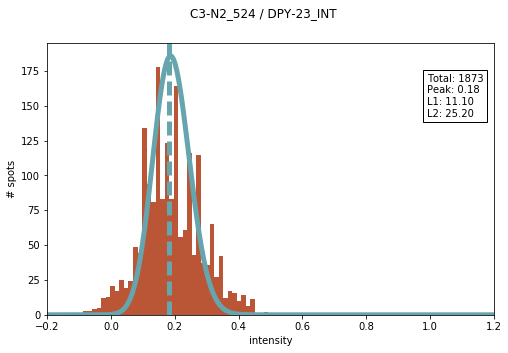

error: L1, L2 [5.6916797038459084, 20.728347889590005]
peak center: 0.125252525253


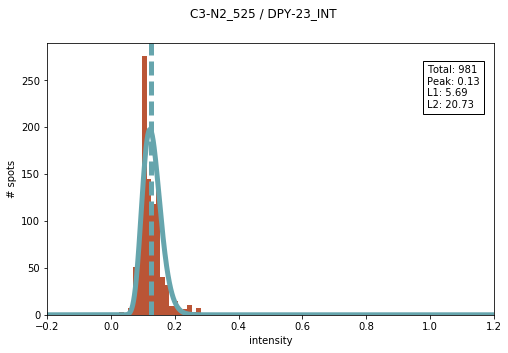

error: L1, L2 [3.3785666655435294, 11.600587362706547]
peak center: 0.125252525253


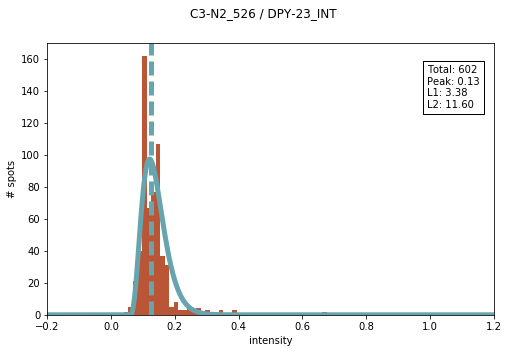

error: L1, L2 [8.1643513017850839, 20.64846904237189]
peak center: 0.181818181818


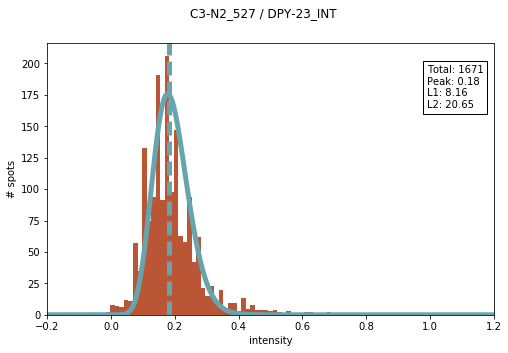

error: L1, L2 [4.122881964813045, 13.811282896613264]
peak center: 0.125252525253


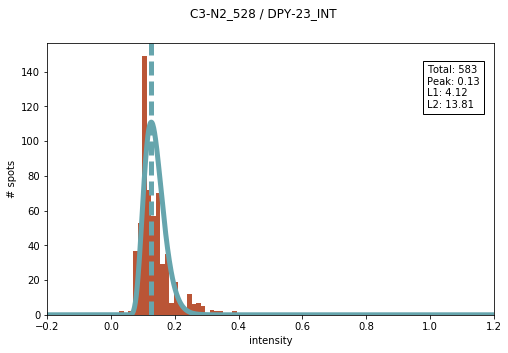

error: L1, L2 [5.0690259256831407, 16.757559591211709]
peak center: 0.139393939394


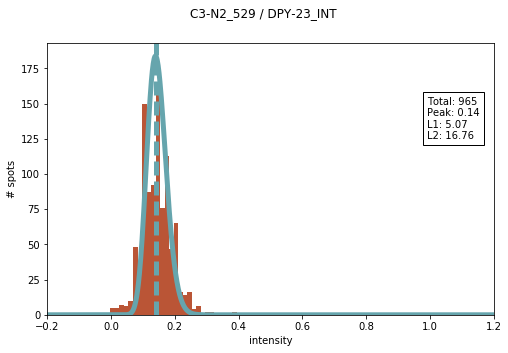

error: L1, L2 [7.4341203742858761, 25.978609433421198]
peak center: 0.139393939394


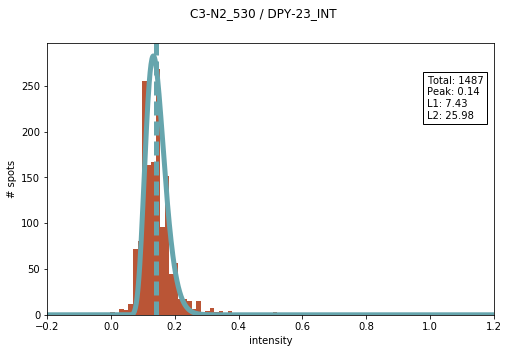

error: L1, L2 [4.0561465696855077, 13.283236729223621]
peak center: 0.139393939394


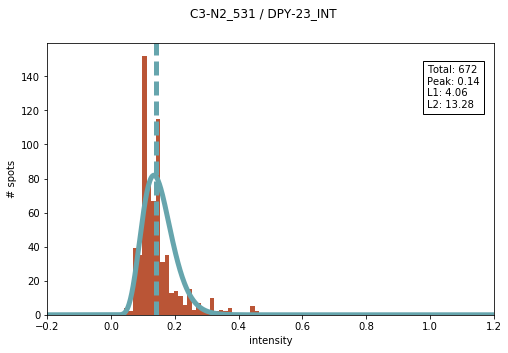

error: L1, L2 [1.5232492136880602, 4.0623798897386099]
peak center: 0.139393939394


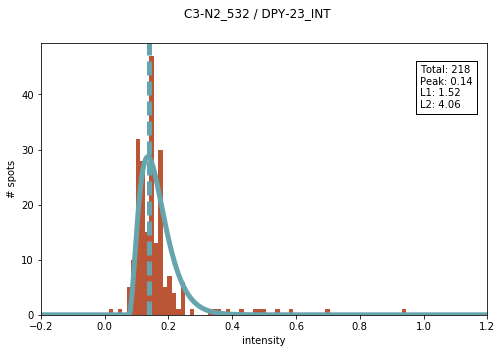

error: L1, L2 [0.27370956191335427, 0.56700249381255763]
peak center: 0.521212121212


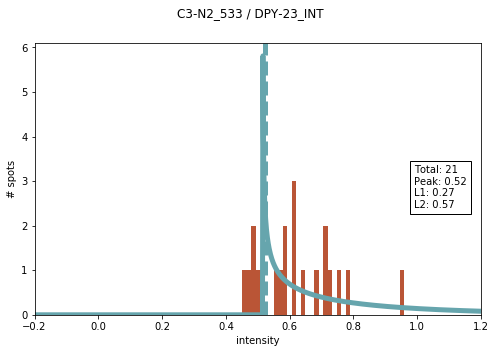

error: L1, L2 [1.942401360794725, 5.1869225157136158]
peak center: 0.436363636364


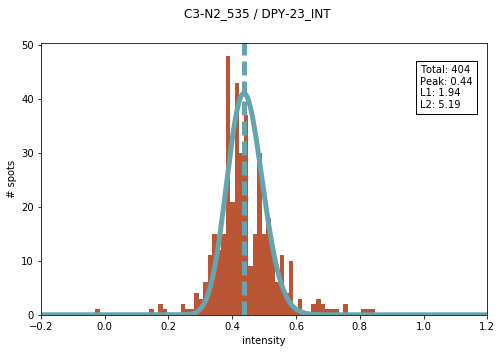

error: L1, L2 [0.88145077935253113, 2.4758318899967793]
peak center: 0.365656565657


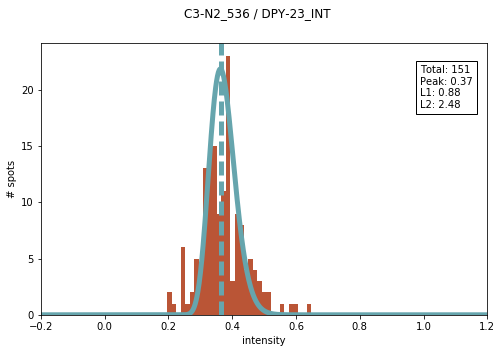

error: L1, L2 [2.4576185928141525, 8.5361568085698298]
peak center: 0.153535353535


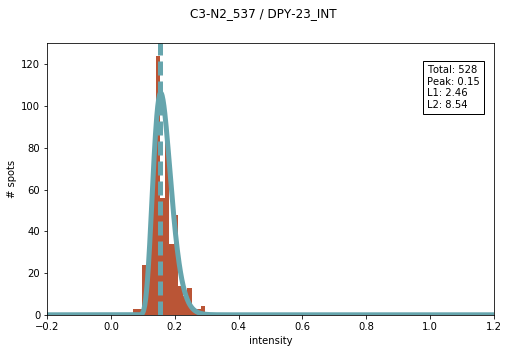

error: L1, L2 [9.7225044153877427, 23.284038792725909]
peak center: 0.19595959596


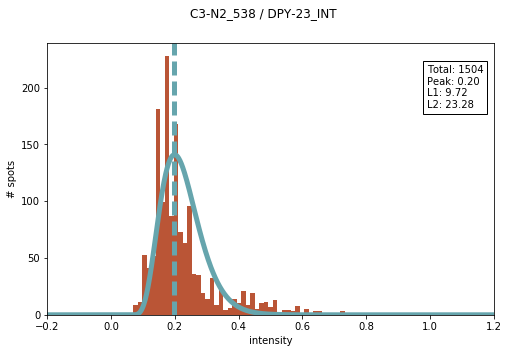

error: L1, L2 [7.182541563028134, 14.69413895401364]
peak center: 0.309090909091


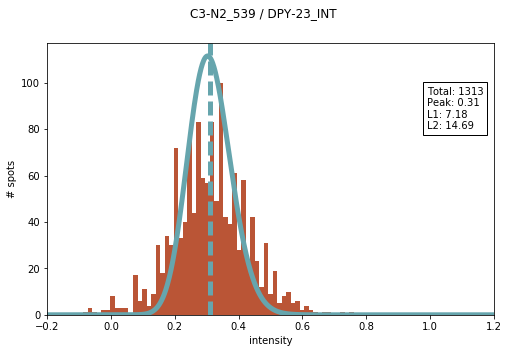

error: L1, L2 [6.0533223252634407, 18.821071228756164]
peak center: 0.153535353535


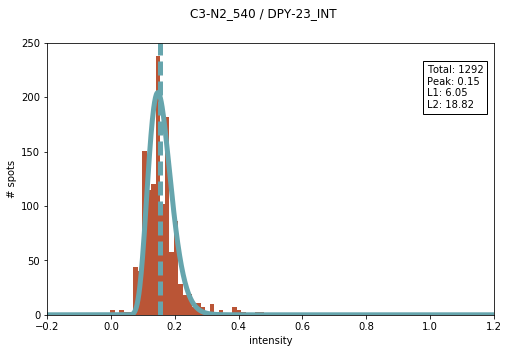

error: L1, L2 [4.9848671135669669, 19.053348189816063]
peak center: 0.111111111111


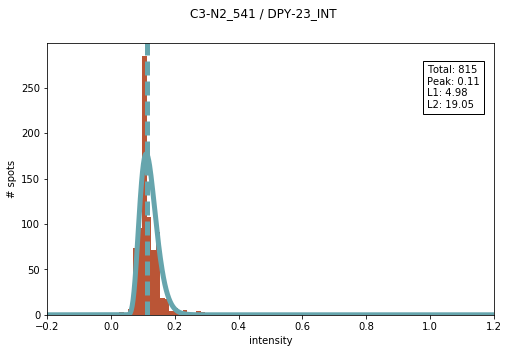

error: L1, L2 [6.1888368274134864, 16.456467173837012]
peak center: 0.224242424242


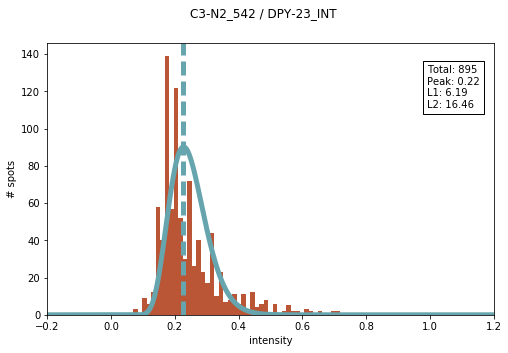

error: L1, L2 [3.4752112933812547, 10.628794604821669]
peak center: 0.125252525253


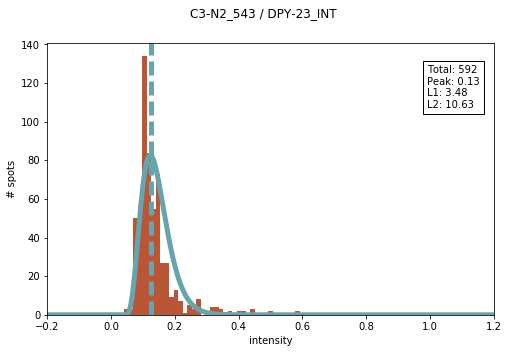

error: L1, L2 [4.4128539628126777, 15.5536924812441]
peak center: 0.125252525253


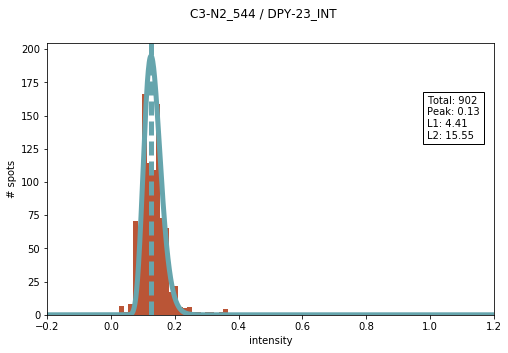

error: L1, L2 [9.0972638733186368, 23.667384774923885]
peak center: 0.167676767677


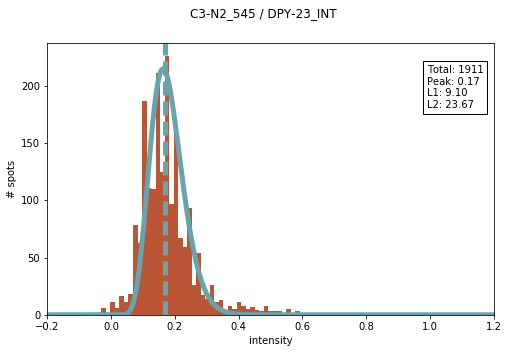

error: L1, L2 [1.4001496438192211, 5.3754587525967477]
peak center: 0.111111111111


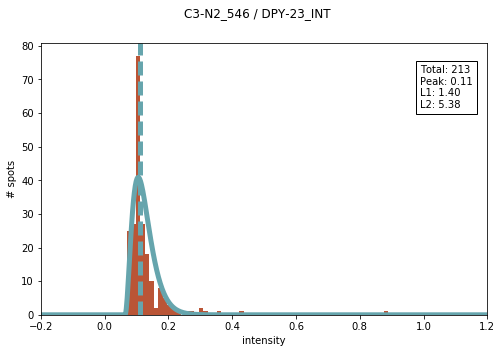

error: L1, L2 [7.613962131406498, 22.617795716221018]
peak center: 0.153535353535


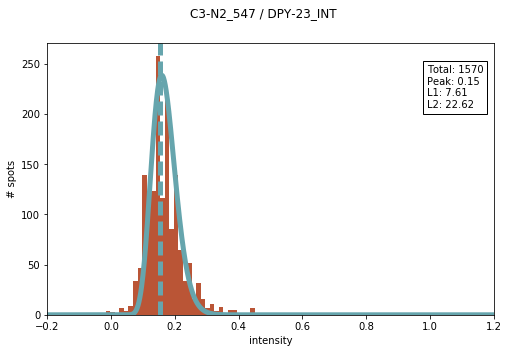

error: L1, L2 [8.3094516604273476, 22.754594365969595]
peak center: 0.167676767677


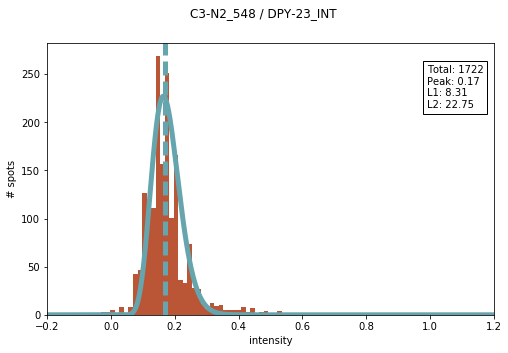

error: L1, L2 [3.4899115875428861, 11.719186704610378]
peak center: 0.125252525253


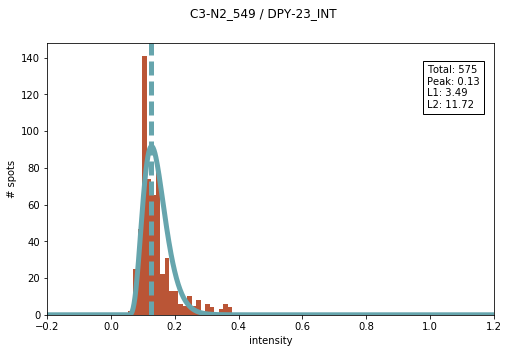

error: L1, L2 [5.741565973040216, 16.335221749339812]
peak center: 0.181818181818


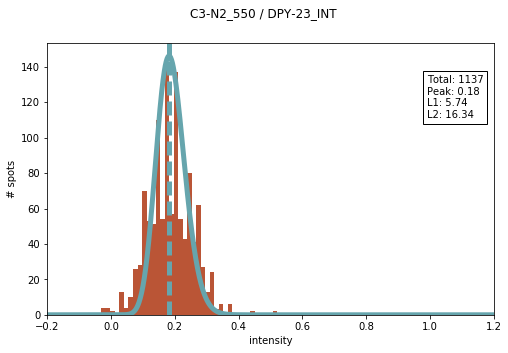

error: L1, L2 [4.8834184846349942, 12.053070734495682]
peak center: 0.181818181818


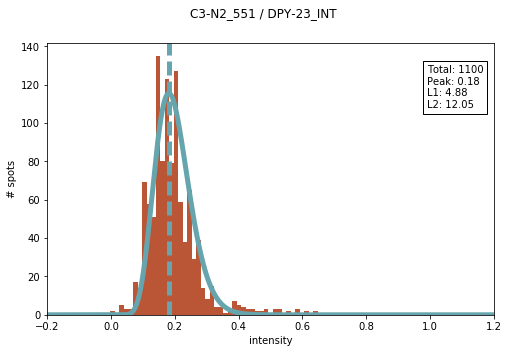

error: L1, L2 [8.7040276906716922, 21.74350661940694]
peak center: 0.181818181818


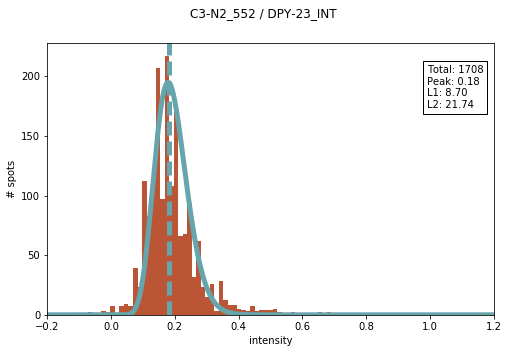

error: L1, L2 [8.3862921881892944, 22.635795290827541]
peak center: 0.153535353535


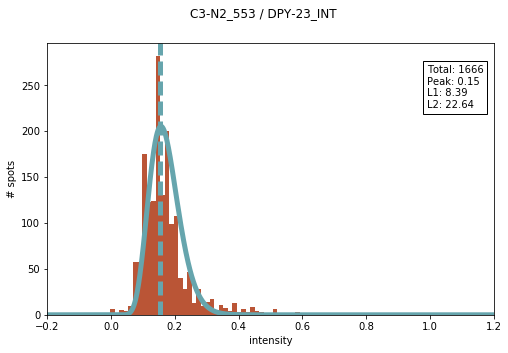

error: L1, L2 [10.842569429868472, 23.217532796027509]
peak center: 0.238383838384


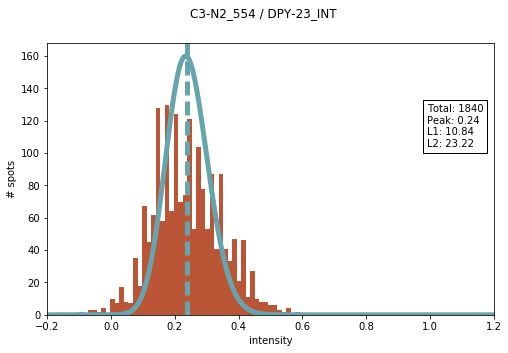

error: L1, L2 [2.3800366035837812, 7.0575091597610928]
peak center: 0.19595959596


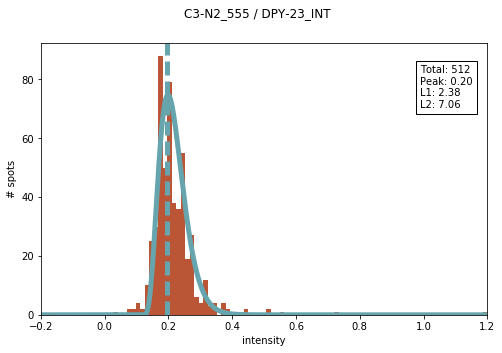

error: L1, L2 [2.9413008780136214, 10.454978271132155]
peak center: 0.125252525253


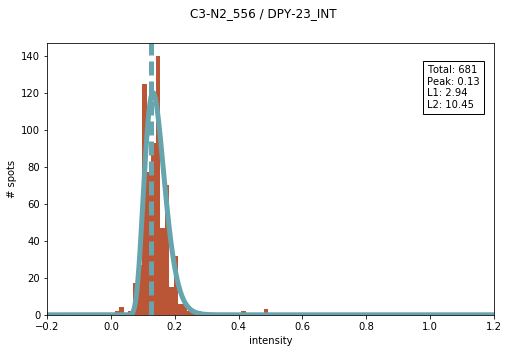

error: L1, L2 [3.9559600362004317, 15.799388483612256]
peak center: 0.111111111111


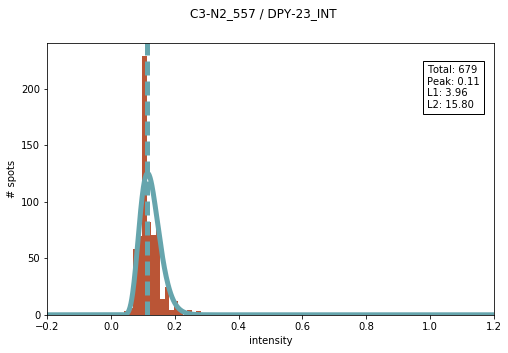

error: L1, L2 [4.5011841602625777, 13.406368825950535]
peak center: 0.139393939394


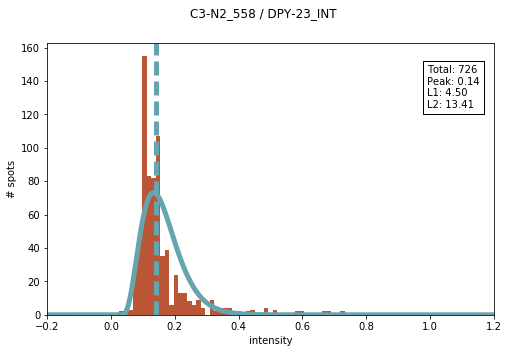

error: L1, L2 [5.9569070975248035, 16.158483601682523]
peak center: 0.139393939394


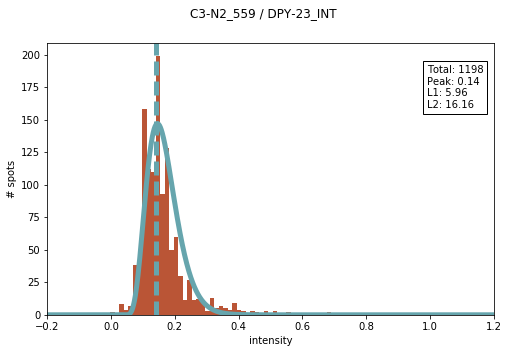

error: L1, L2 [9.3535640153003001, 24.112556662344357]
peak center: 0.181818181818


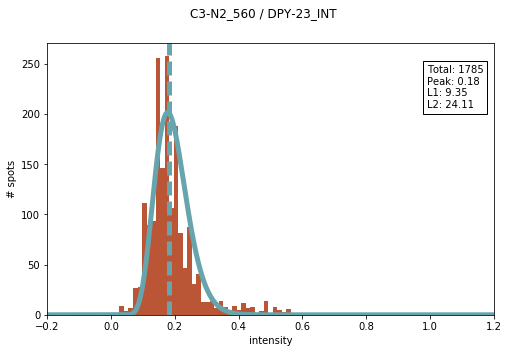

error: L1, L2 [6.9693320996864463, 19.382140552847009]
peak center: 0.181818181818


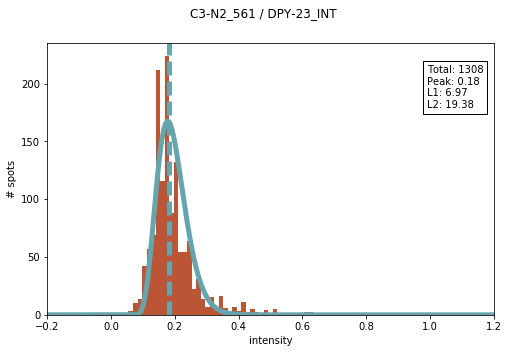

error: L1, L2 [10.316831031155525, 22.492245034126032]
peak center: 0.19595959596


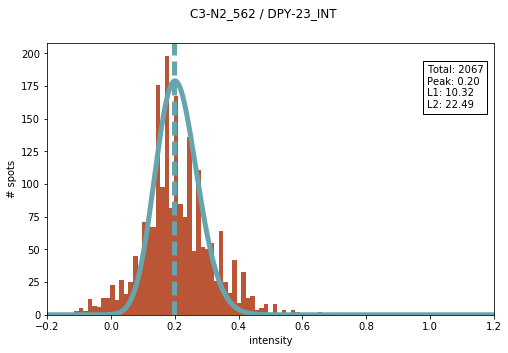

error: L1, L2 [6.1884218402649456, 15.172500159677954]
peak center: 0.19595959596


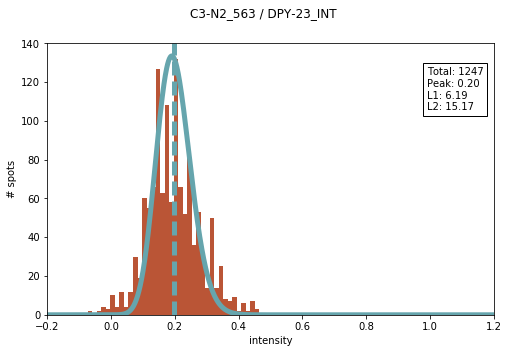

error: L1, L2 [0.54819550929443028, 1.8919183303728402]
peak center: 0.125252525253


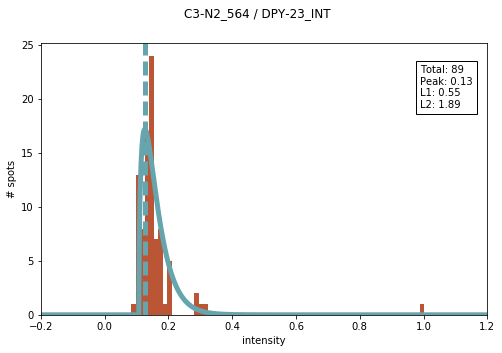

error: L1, L2 [8.5779810151682501, 20.315643347696493]
peak center: 0.19595959596


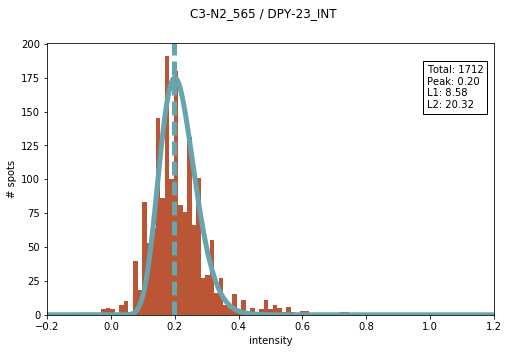

error: L1, L2 [8.4797577548174115, 21.931187520535666]
peak center: 0.181818181818


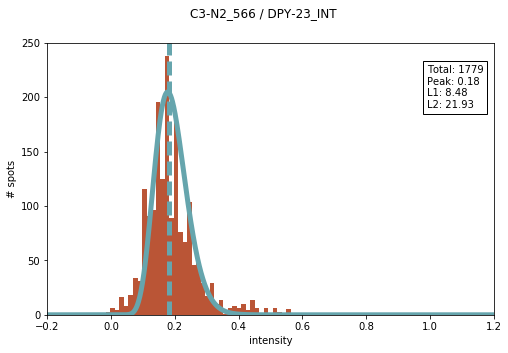

error: L1, L2 [15.407610440247959, 36.272451834371552]
peak center: 0.181818181818


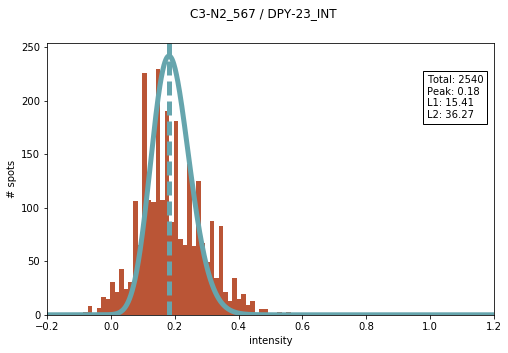

error: L1, L2 [1.741161936984601, 5.1813434989361555]
peak center: 0.167676767677


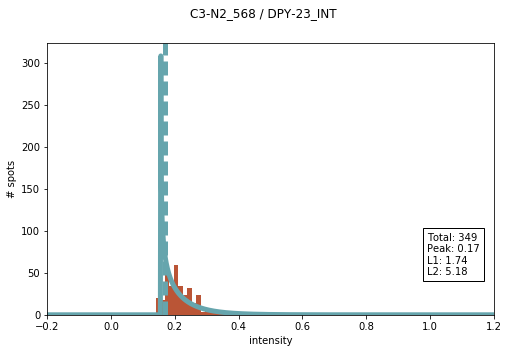

error: L1, L2 [9.2249043793388772, 22.480329102492362]
peak center: 0.210101010101


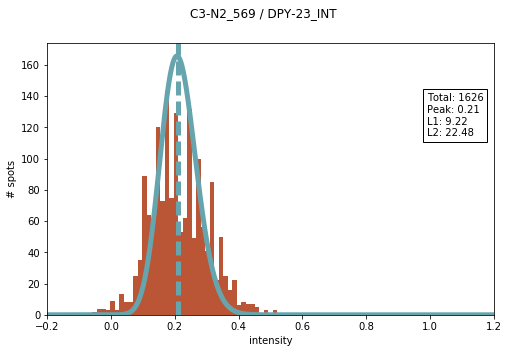

error: L1, L2 [12.962247237272559, 29.803127488363497]
peak center: 0.181818181818


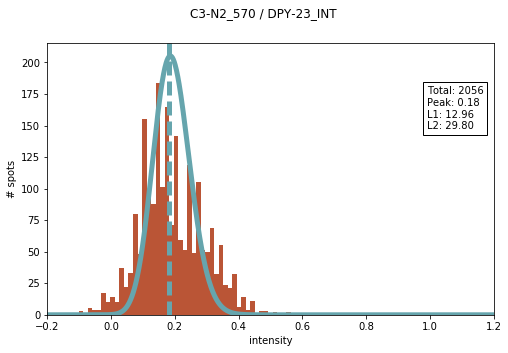

error: L1, L2 [5.4576511154141141, 14.652843516762211]
peak center: 0.19595959596


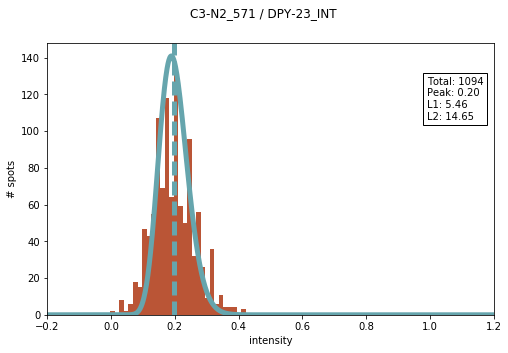

error: L1, L2 [7.3090799486362465, 21.604998825254967]
peak center: 0.153535353535


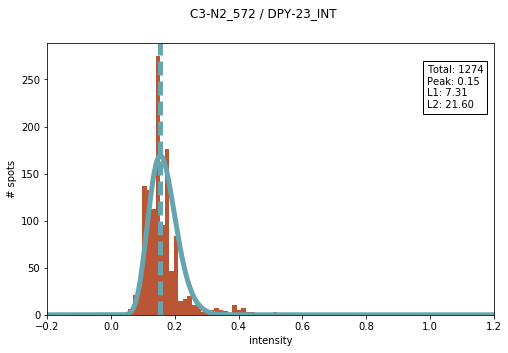

error: L1, L2 [8.6186985903590188, 22.941338221945593]
peak center: 0.181818181818


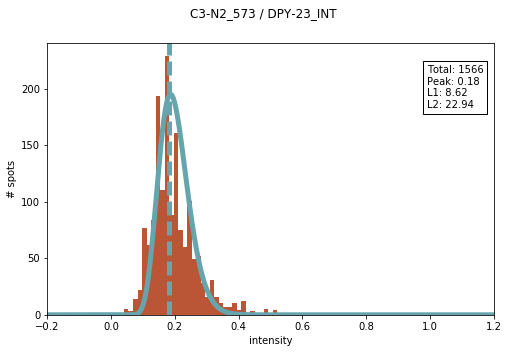

error: L1, L2 [5.865802014429697, 17.449110154465274]
peak center: 0.139393939394


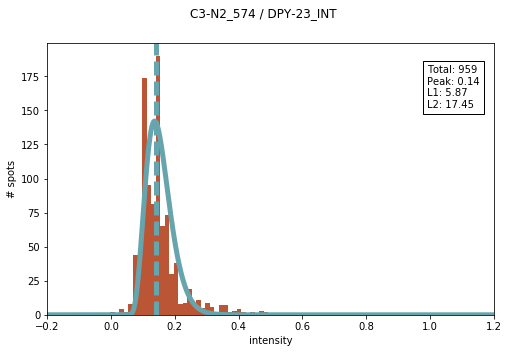

error: L1, L2 [7.418094335364712, 24.566743927853373]
peak center: 0.125252525253


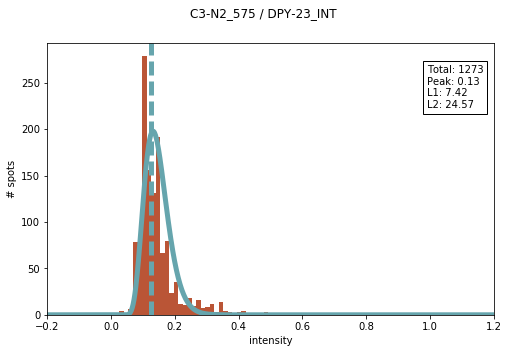

error: L1, L2 [8.7596715757365899, 22.296024425360319]
peak center: 0.19595959596


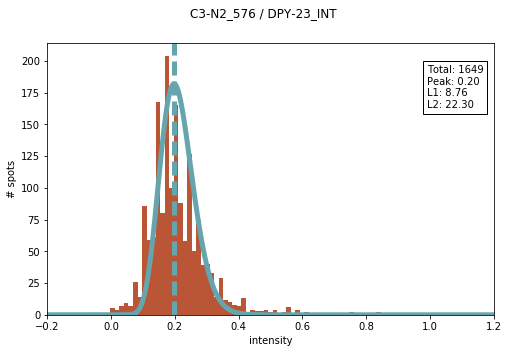

error: L1, L2 [10.099375466120833, 25.983123978417797]
peak center: 0.153535353535


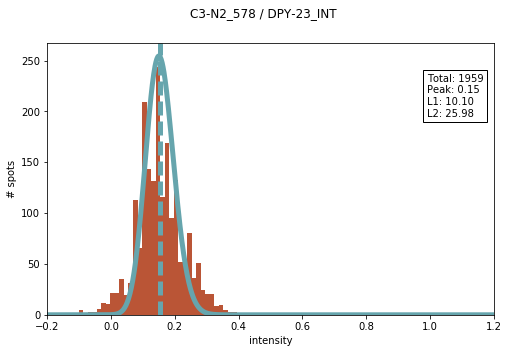

error: L1, L2 [5.102964129051256, 13.924327211269244]
peak center: 0.139393939394


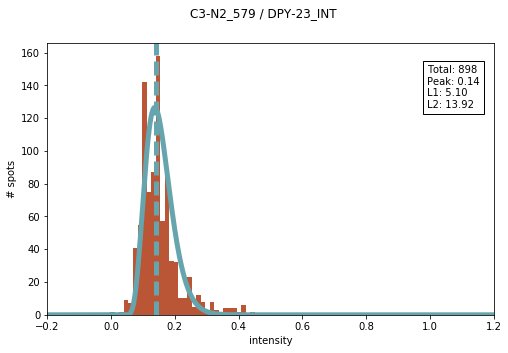

error: L1, L2 [7.5724087555438908, 17.453677813673369]
peak center: 0.167676767677


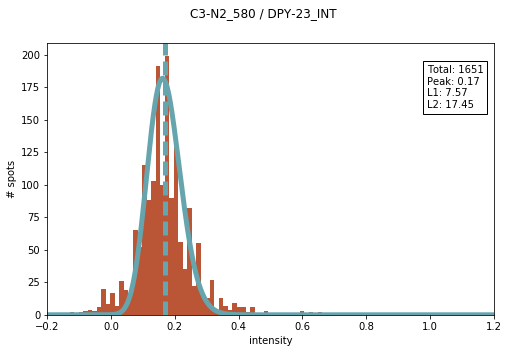

error: L1, L2 [11.990964799065406, 28.861041034162312]
peak center: 0.181818181818


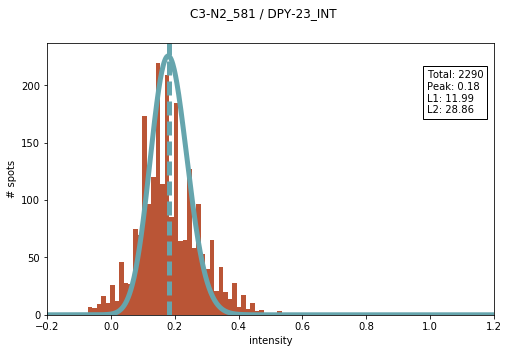

error: L1, L2 [3.4278386182911653, 11.924557654859985]
peak center: 0.111111111111


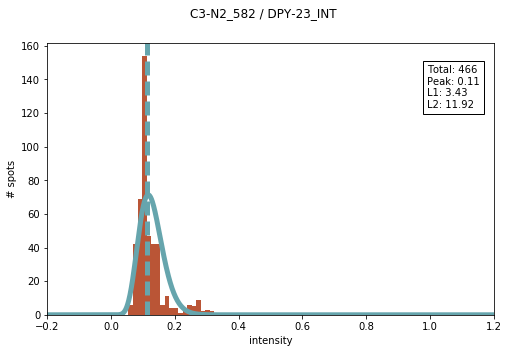

error: L1, L2 [1.9837006481122634, 4.9990262379953876]
peak center: 0.181818181818


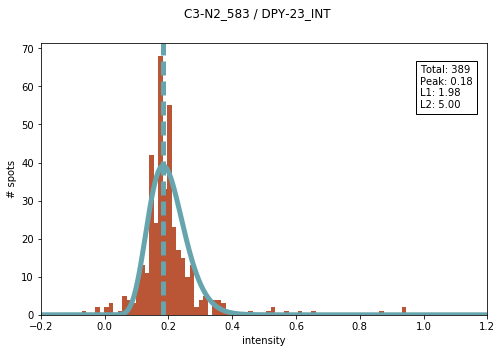

error: L1, L2 [2.6896837568500014, 8.6600778372337732]
peak center: 0.125252525253


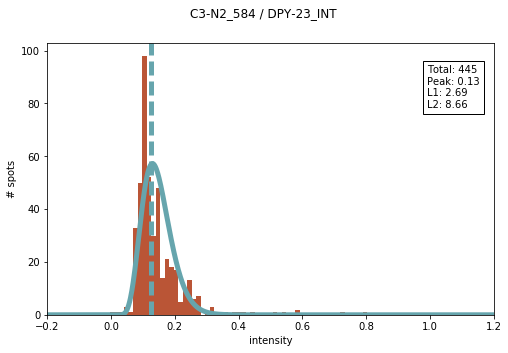

error: L1, L2 [5.9172491327846481, 23.461696263450392]
peak center: 0.0686868686869


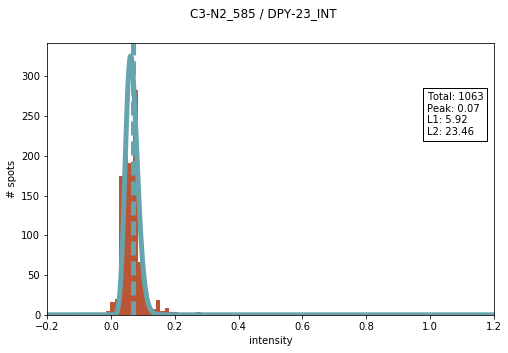

error: L1, L2 [4.0161515223659405, 10.267854547035135]
peak center: 0.167676767677


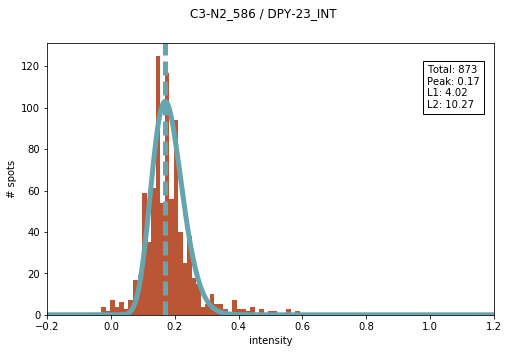

error: L1, L2 [4.6147217550004322, 14.590005228053242]
peak center: 0.111111111111


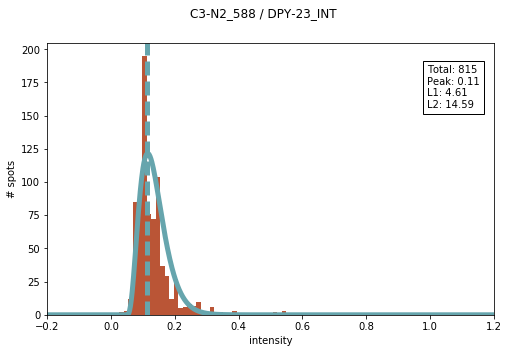

error: L1, L2 [12.591043861832745, 29.888676208462297]
peak center: 0.19595959596


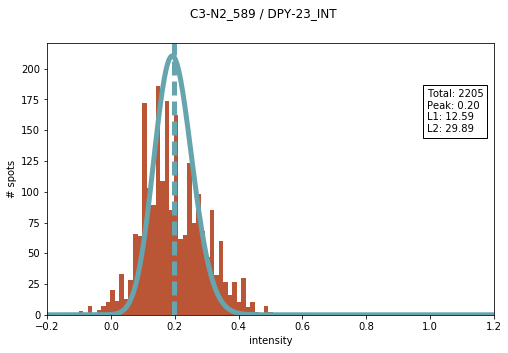

error: L1, L2 [9.9227004982349865, 21.845391291483661]
peak center: 0.224242424242


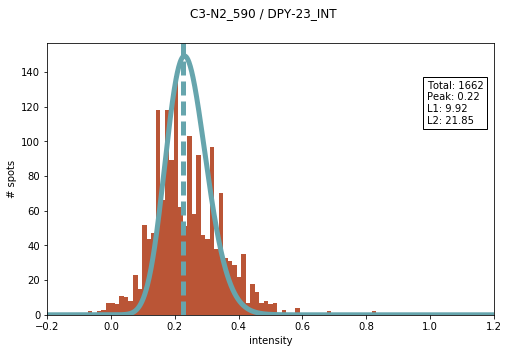

error: L1, L2 [4.9912053117300088, 18.348828601513695]
peak center: 0.0828282828283


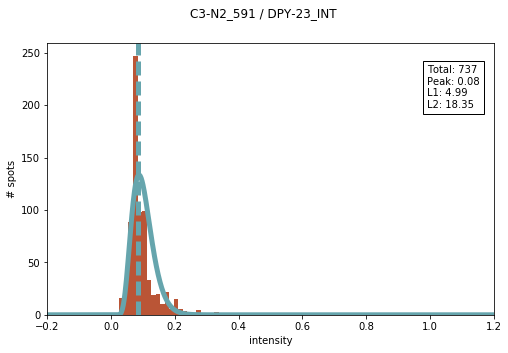

error: L1, L2 [8.820487903644862, 22.360378322449606]
peak center: 0.167676767677


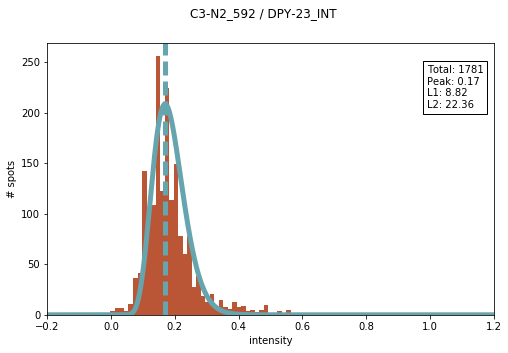

error: L1, L2 [4.1096807488528473, 13.642938662994419]
peak center: 0.111111111111


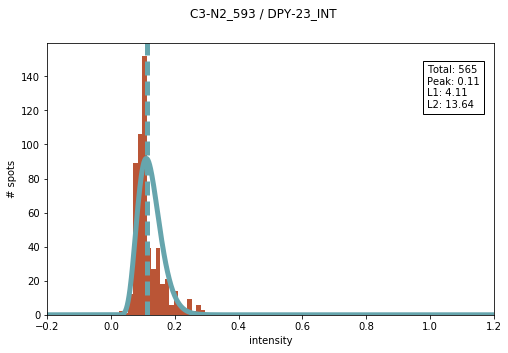

error: L1, L2 [4.5856461053751856, 15.843656689185767]
peak center: 0.111111111111


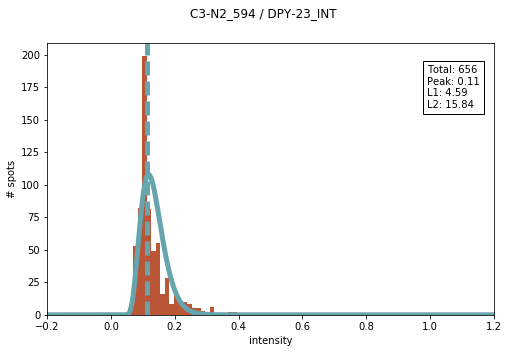

error: L1, L2 [5.4991291210954962, 14.715354335787852]
peak center: 0.181818181818


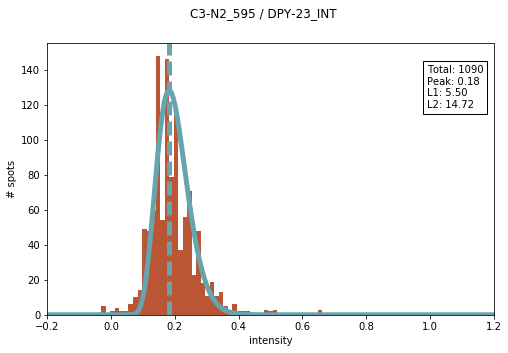

error: L1, L2 [3.1806351307836747, 9.7564776919134157]
peak center: 0.139393939394


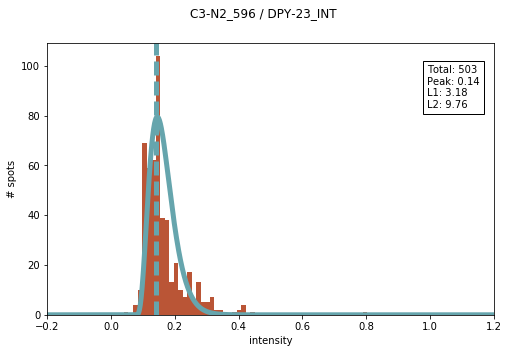

error: L1, L2 [7.4986560562482936, 21.900593681971298]
peak center: 0.167676767677


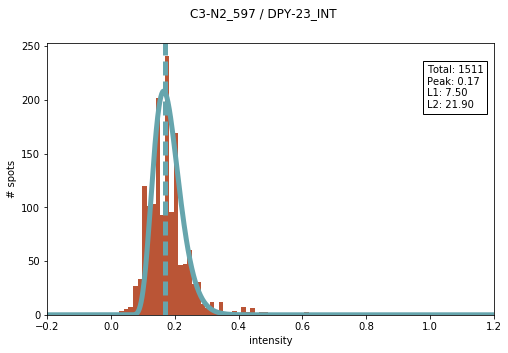

error: L1, L2 [10.11542625747963, 32.278484785896858]
peak center: 0.125252525253


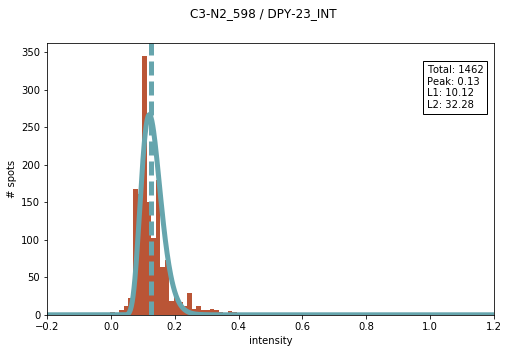

error: L1, L2 [5.6366370296963826, 21.242140423504633]
peak center: 0.139393939394


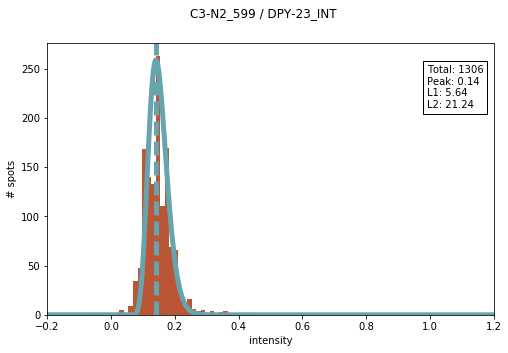

error: L1, L2 [10.80783167910805, 27.204813246139107]
peak center: 0.153535353535


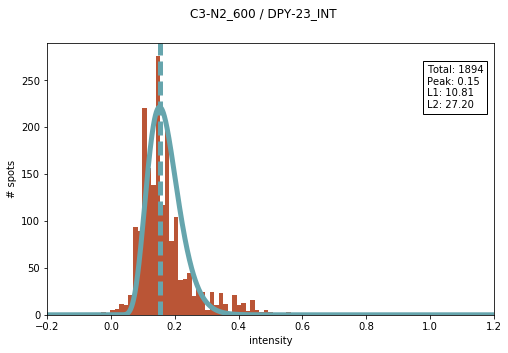

error: L1, L2 [3.5885703369552209, 11.767204220718918]
peak center: 0.0828282828283


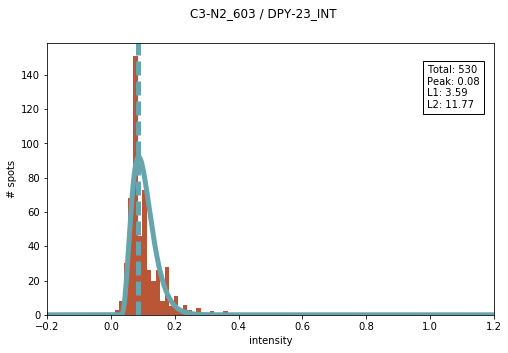

error: L1, L2 [1.3501588234856932, 3.1079664302404026]
peak center: 0.323232323232


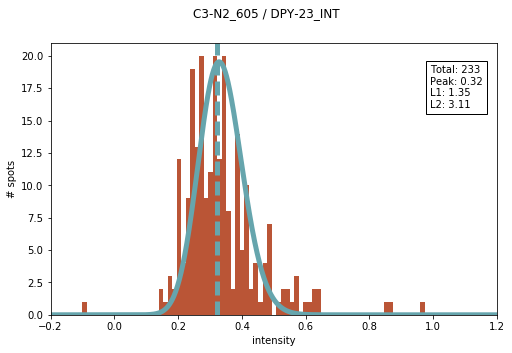

error: L1, L2 [4.9553432314411561, 13.033560065682403]
peak center: 0.139393939394


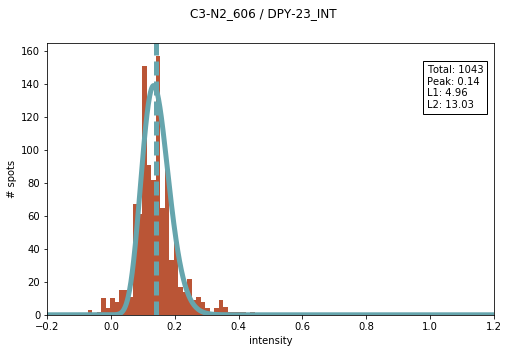

error: L1, L2 [3.2147058867359122, 9.5270095348347255]
peak center: 0.125252525253


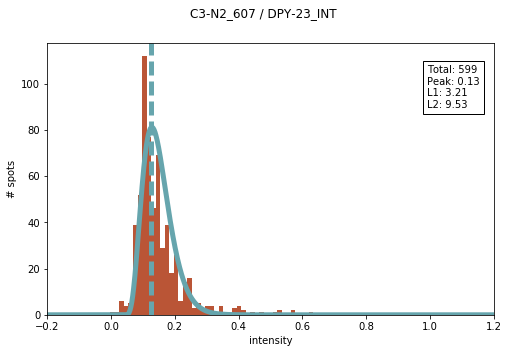

error: L1, L2 [5.0941971418397047, 13.916444120246359]
peak center: 0.153535353535


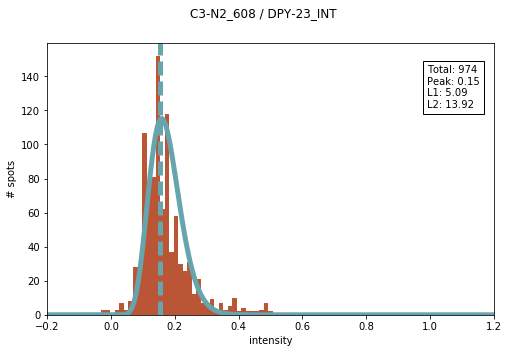

error: L1, L2 [2.4029052625140581, 6.9572359075006025]
peak center: 0.19595959596


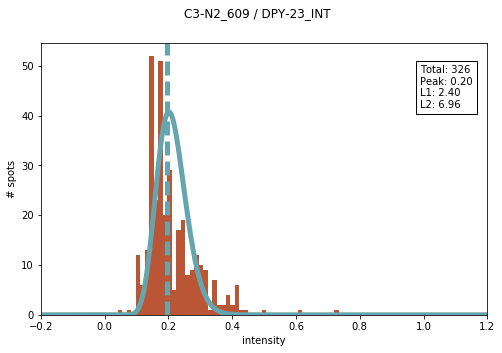

error: L1, L2 [2.7275449075076943, 7.4356908450111696]
peak center: 0.153535353535


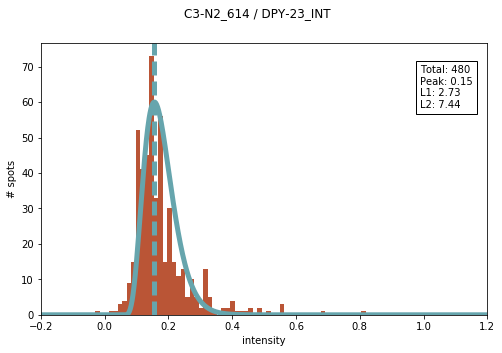

error: L1, L2 [9.0324945562698549, 21.157323333194537]
peak center: 0.153535353535


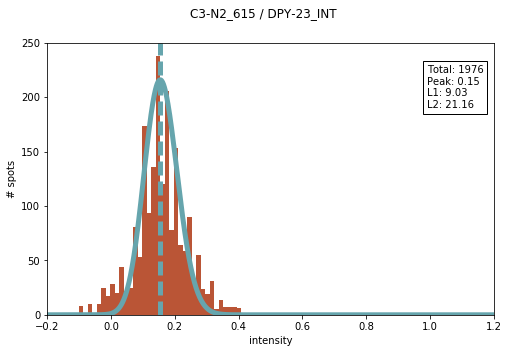

error: L1, L2 [7.8730121482595594, 25.084857082643818]
peak center: 0.125252525253


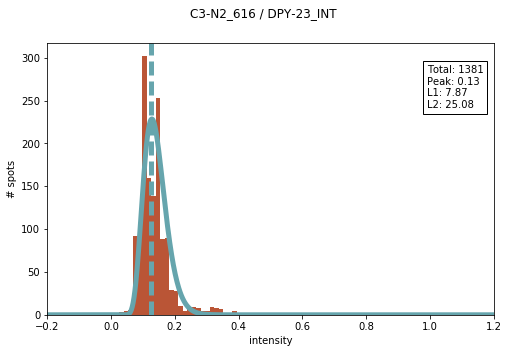

error: L1, L2 [1.8787465060527342, 6.3047868026149558]
peak center: 0.125252525253


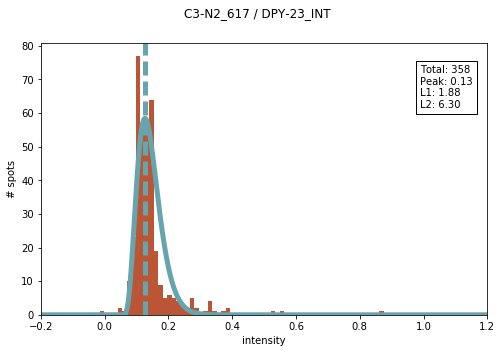

error: L1, L2 [2.1772322179080668, 6.1074734372335255]
peak center: 0.224242424242


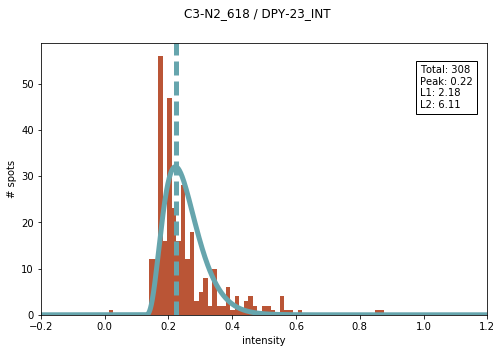

error: L1, L2 [6.1341872737669494, 16.78678462838511]
peak center: 0.167676767677


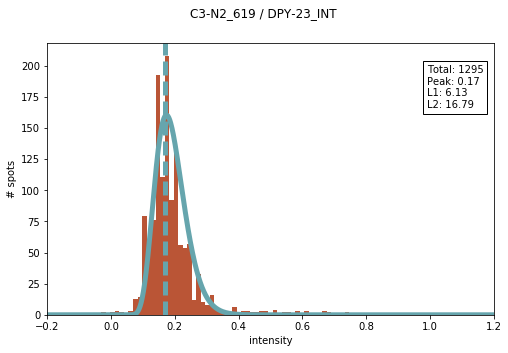

error: L1, L2 [4.8711263134485216, 15.976504080278112]
peak center: 0.167676767677


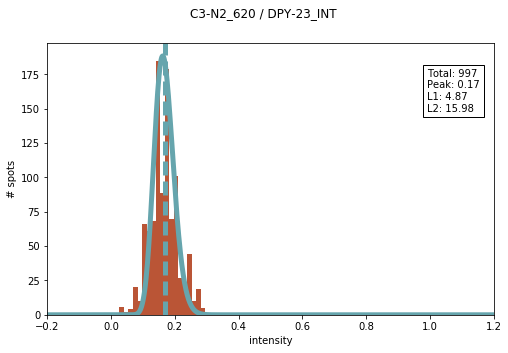

error: L1, L2 [8.7381410273593598, 27.581881016792575]
peak center: 0.125252525253


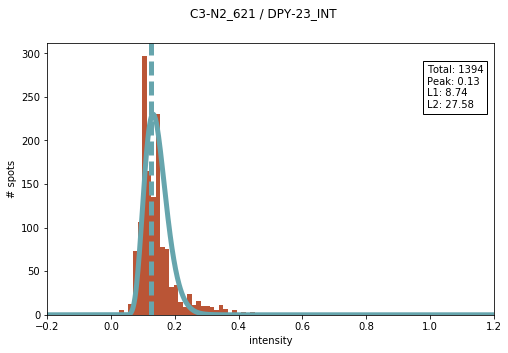

error: L1, L2 [6.1530465680368405, 16.02366848904995]
peak center: 0.181818181818


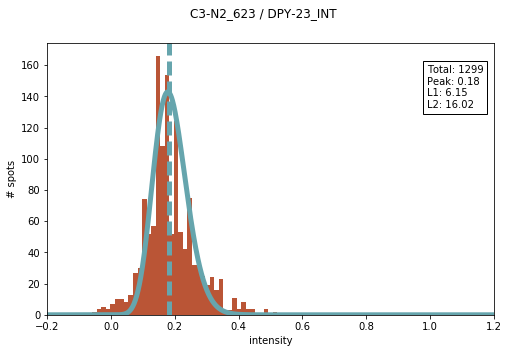

error: L1, L2 [7.0070696929799512, 19.615684704860456]
peak center: 0.181818181818


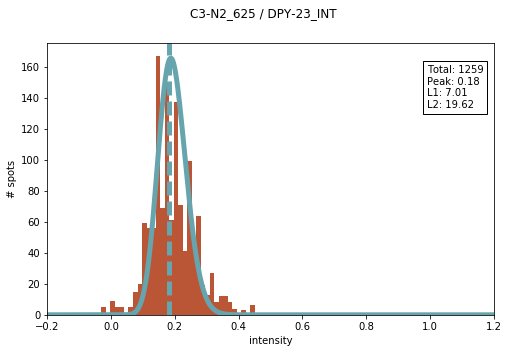

error: L1, L2 [2.6336238155724252, 9.0455467090297681]
peak center: 0.153535353535


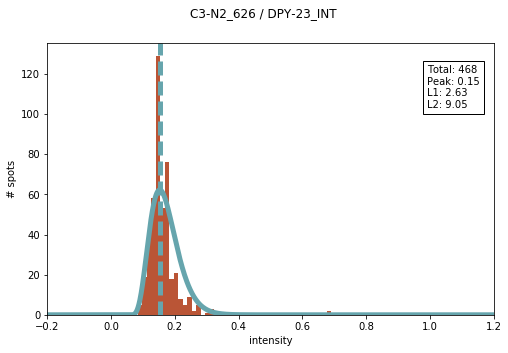

error: L1, L2 [2.5888999484218265, 7.2360426944021849]
peak center: 0.309090909091


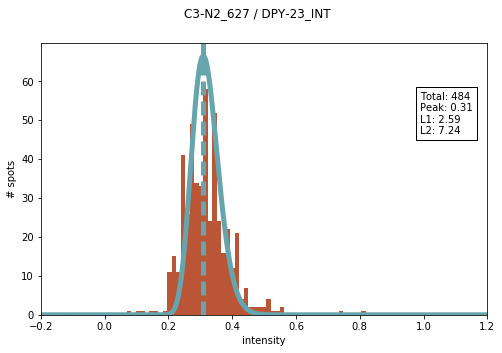

error: L1, L2 [4.9123835261917597, 17.025987087042722]
peak center: 0.125252525253


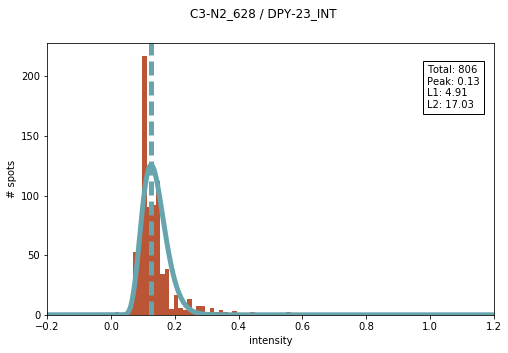

error: L1, L2 [3.385673200315511, 9.4361837310336067]
peak center: 0.153535353535


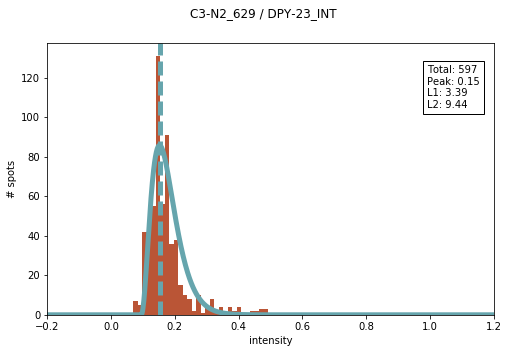

error: L1, L2 [4.6394004895399981, 12.63441686427741]
peak center: 0.167676767677


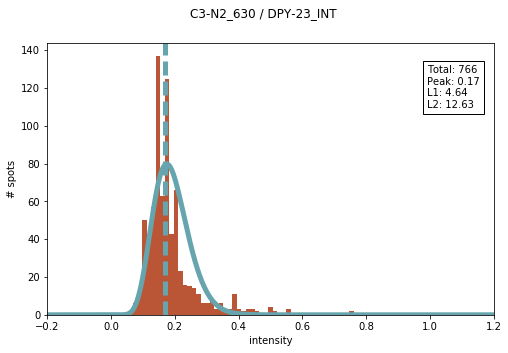

error: L1, L2 [2.0231743289543953, 7.2933812840946146]
peak center: 0.125252525253


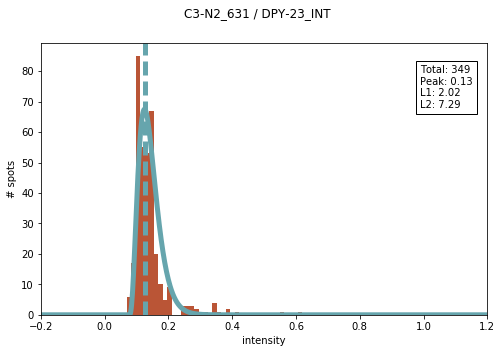

error: L1, L2 [4.2062811138987879, 14.034825262292252]
peak center: 0.125252525253


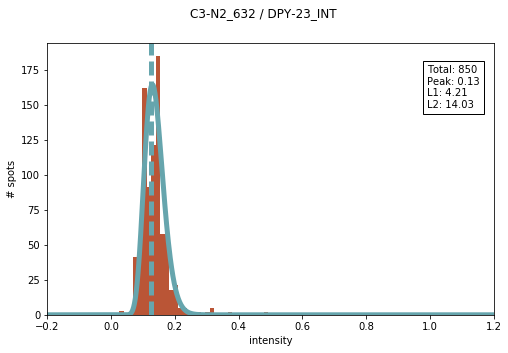

error: L1, L2 [6.4337446906448337, 18.786760478182753]
peak center: 0.139393939394


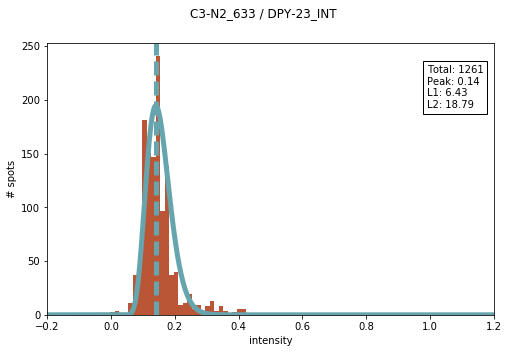

error: L1, L2 [6.0637361208941938, 17.50829506762312]
peak center: 0.139393939394


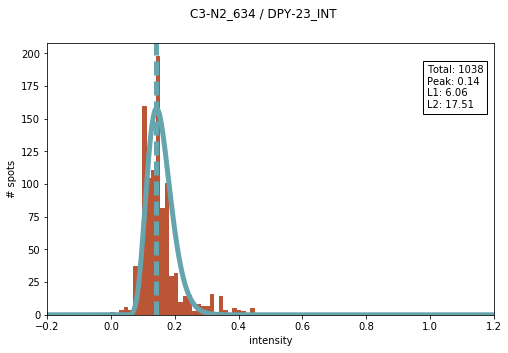

error: L1, L2 [3.8787186291153963, 10.765067653586822]
peak center: 0.139393939394


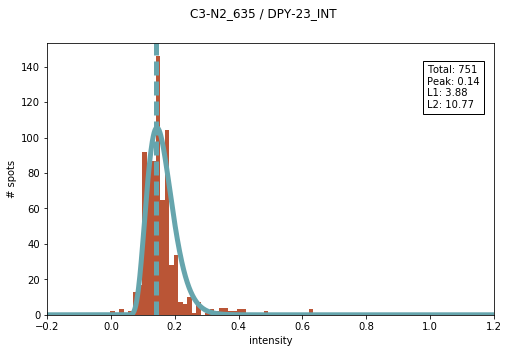

error: L1, L2 [5.9066290191934501, 20.18707362855865]
peak center: 0.125252525253


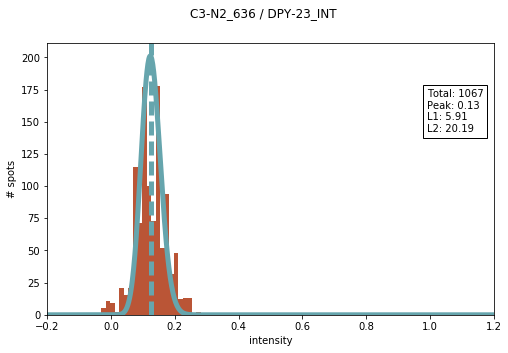

error: L1, L2 [1.3835308559882666, 4.8901072970100286]
peak center: 0.125252525253


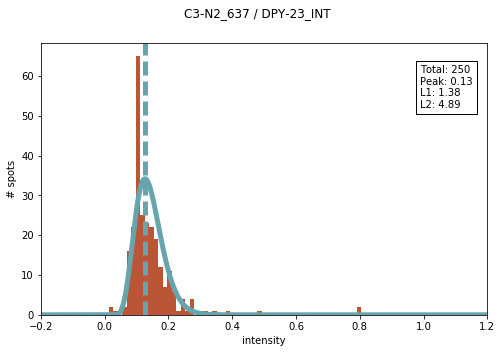

error: L1, L2 [2.1868601730244595, 7.8690643071176556]
peak center: 0.139393939394


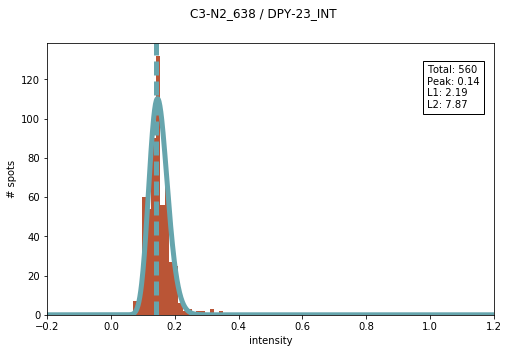

error: L1, L2 [6.773302826010891, 18.186373138029218]
peak center: 0.153535353535


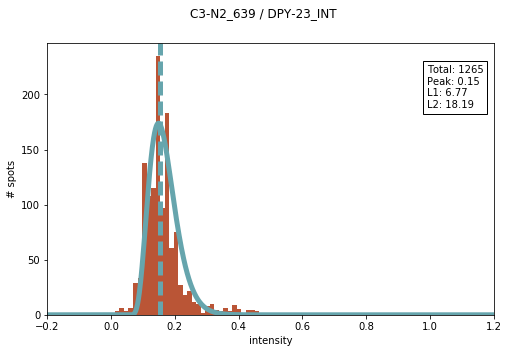

error: L1, L2 [4.2235719671903302, 12.908923436496151]
peak center: 0.153535353535


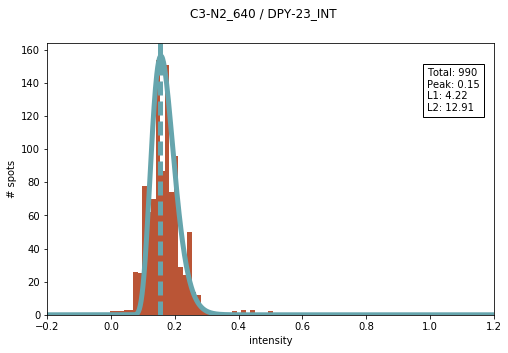

error: L1, L2 [8.5186896529881153, 21.257327863075638]
peak center: 0.181818181818


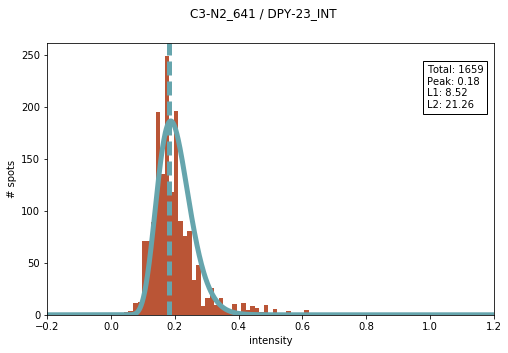

error: L1, L2 [1.1213549105835241, 3.6664884977796683]
peak center: 0.153535353535


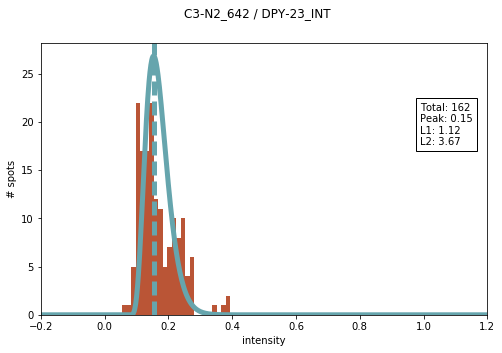

error: L1, L2 [4.5875378224265848, 13.65712384787027]
peak center: 0.153535353535


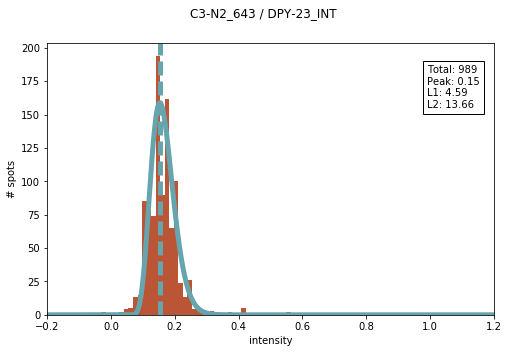

error: L1, L2 [4.7619791400386111, 23.926212250629852]
peak center: 0.0828282828283


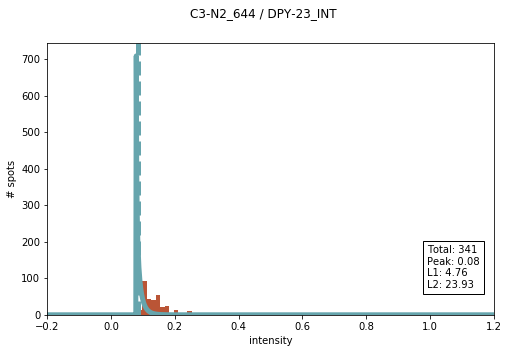

error: L1, L2 [0.8811258719168642, 2.8681414858194425]
peak center: 0.111111111111


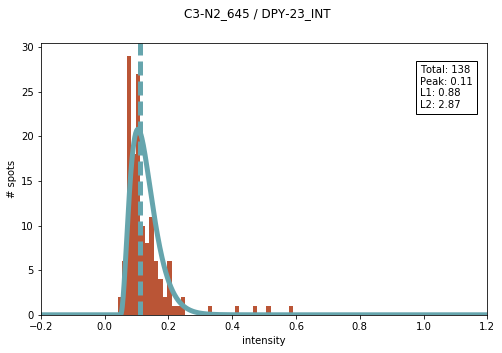

error: L1, L2 [9.9355588498377241, 24.178616891238608]
peak center: 0.19595959596


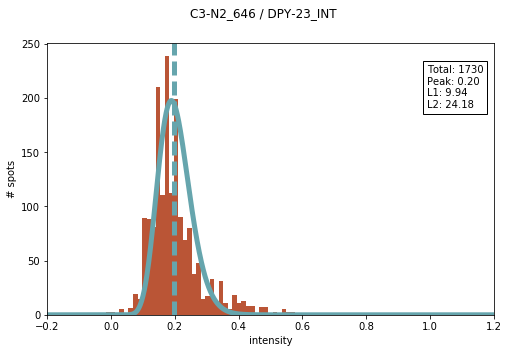

error: L1, L2 [0.57840793114660516, 1.8962433476458178]
peak center: 0.0969696969697


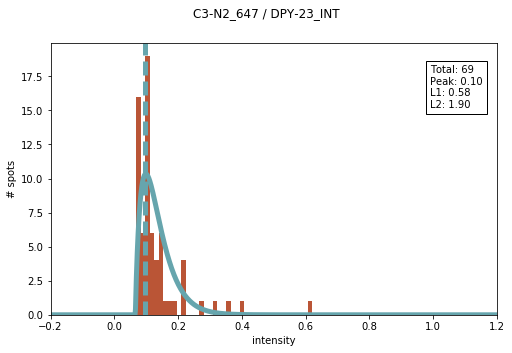

error: L1, L2 [6.7386166895849513, 19.051651484331593]
peak center: 0.210101010101


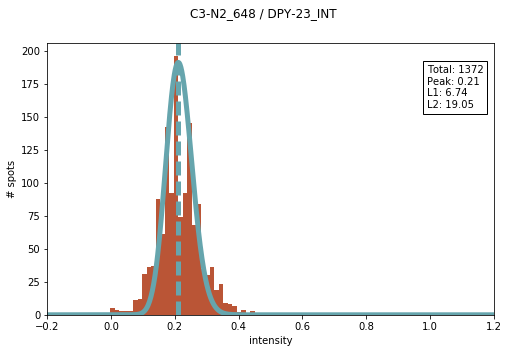

error: L1, L2 [4.0512075687585689, 14.489682484269041]
peak center: 0.125252525253


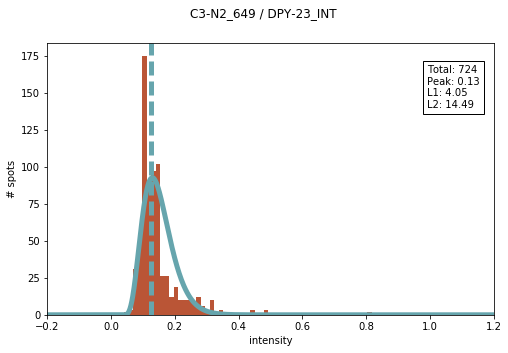

error: L1, L2 [11.551228953461592, 28.001722872094373]
peak center: 0.19595959596


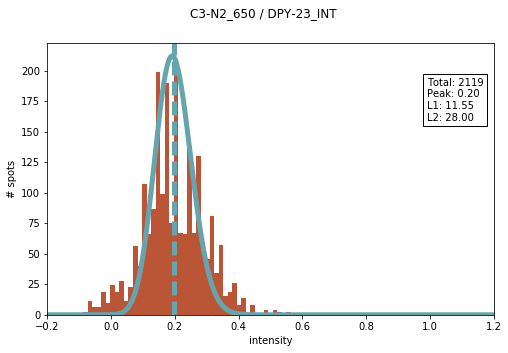

error: L1, L2 [5.7334173835179083, 14.965012379461445]
peak center: 0.19595959596


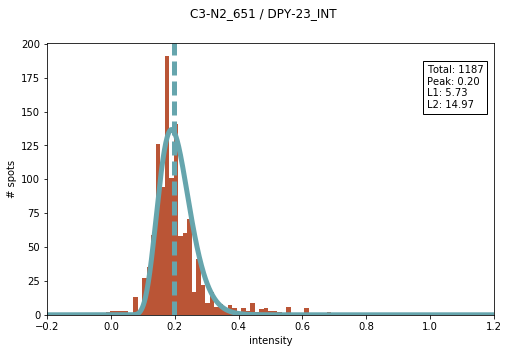

error: L1, L2 [1.7203954953781377, 5.4805575864394056]
peak center: 0.125252525253


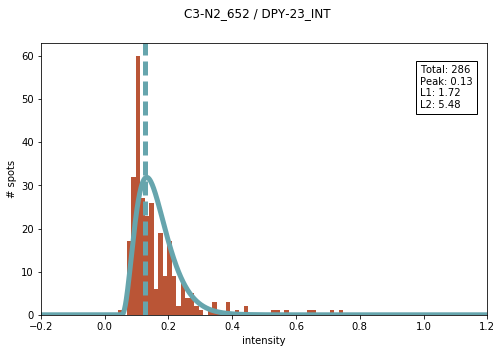

error: L1, L2 [0.38966057973657375, 0.69734156308391793]
peak center: 0.210101010101


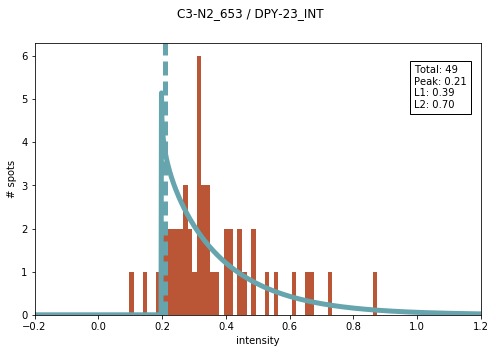

error: L1, L2 [5.1093244311962405, 13.142809720624221]
peak center: 0.167676767677


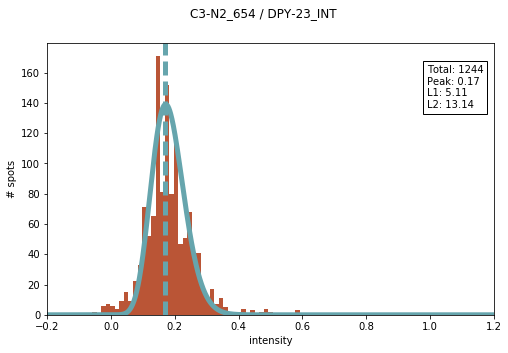

error: L1, L2 [3.880198250724789, 13.007297309761565]
peak center: 0.125252525253


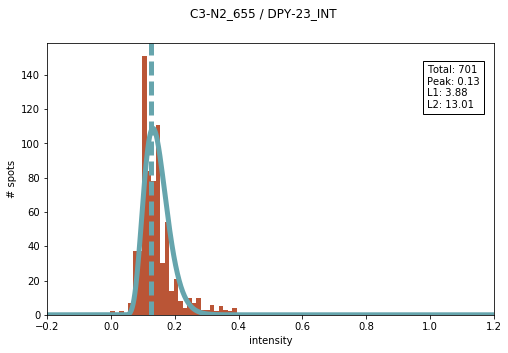

error: L1, L2 [6.0889769133170972, 15.494130768040508]
peak center: 0.181818181818


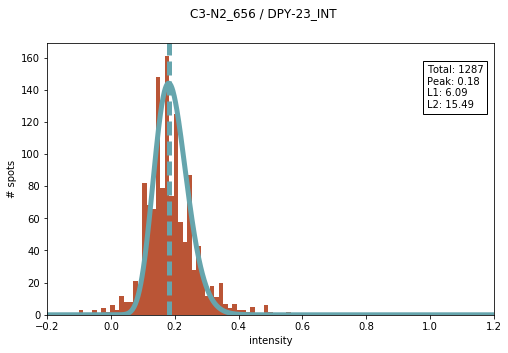

error: L1, L2 [5.2198205098197006, 18.372779143860633]
peak center: 0.153535353535


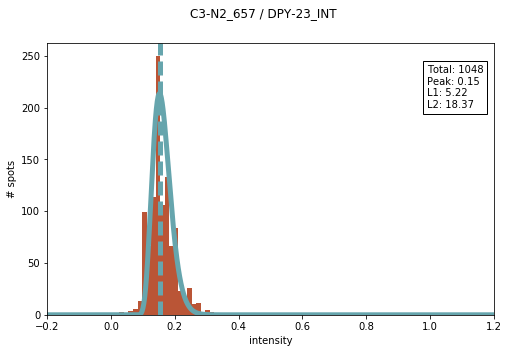

error: L1, L2 [12.701334520643583, 39.015572613196014]
peak center: 0.0828282828283


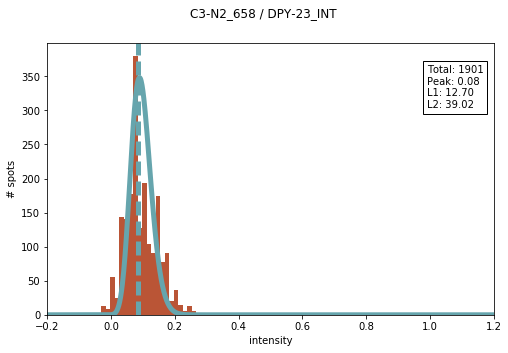

error: L1, L2 [0.84271524291111632, 2.1893440510323785]
peak center: 0.125252525253


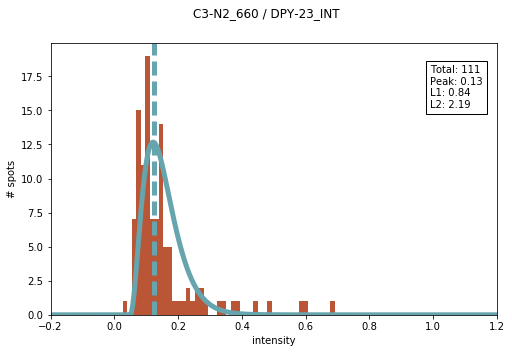

error: L1, L2 [5.0108676664628673, 19.983970487927479]
peak center: 0.153535353535


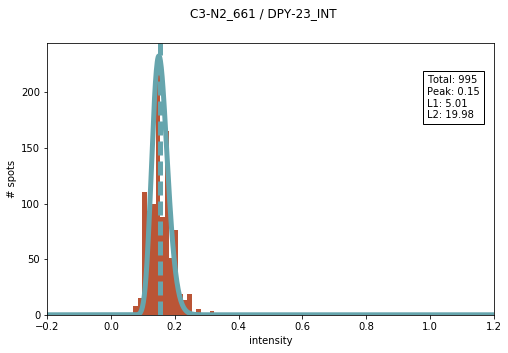

error: L1, L2 [0.61331951264847062, 1.8412202052077846]
peak center: 0.139393939394


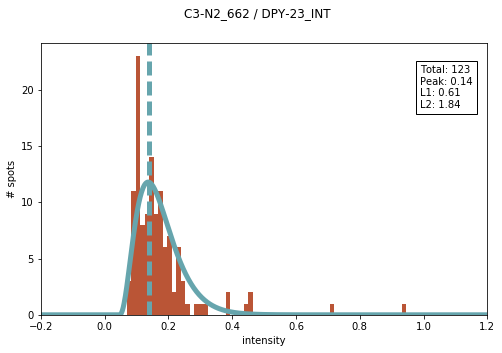

error: L1, L2 [7.6318882612393502, 19.618558948087475]
peak center: 0.19595959596


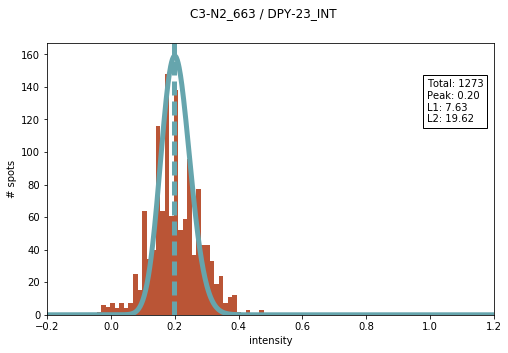

error: L1, L2 [6.1719189116894562, 14.927271148341319]
peak center: 0.19595959596


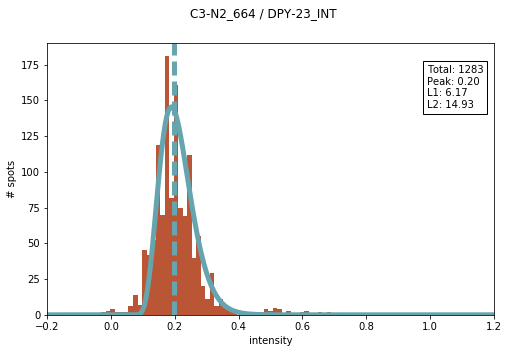

error: L1, L2 [6.5340331708052526, 16.177741233085559]
peak center: 0.224242424242


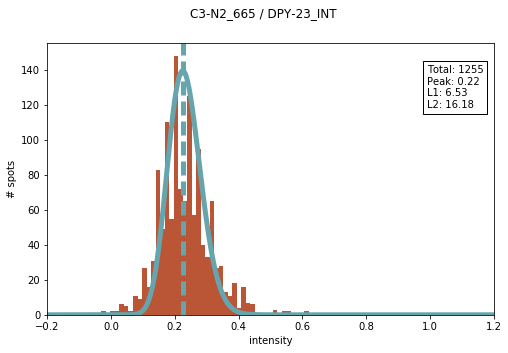

error: L1, L2 [8.1378814586639798, 20.26771316988318]
peak center: 0.19595959596


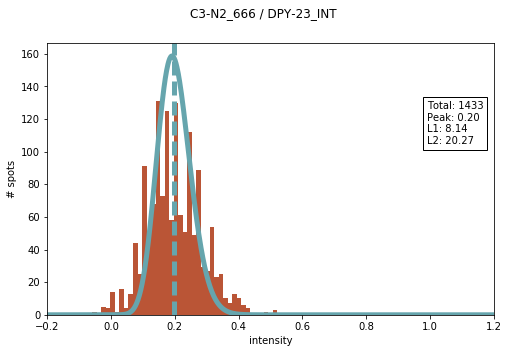

error: L1, L2 [7.3188876571924917, 17.144753992379389]
peak center: 0.181818181818


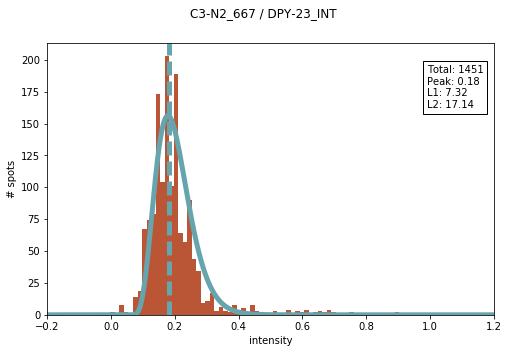

error: L1, L2 [8.7440498002872591, 20.030732095742199]
peak center: 0.210101010101


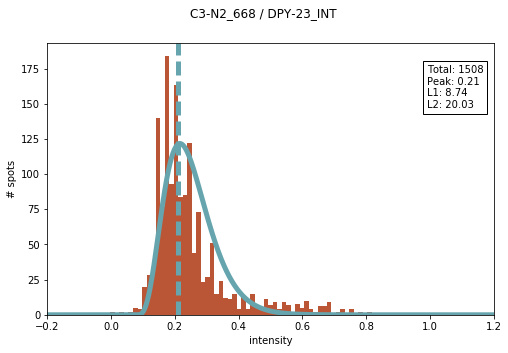

error: L1, L2 [9.194181480569199, 21.983027158951586]
peak center: 0.19595959596


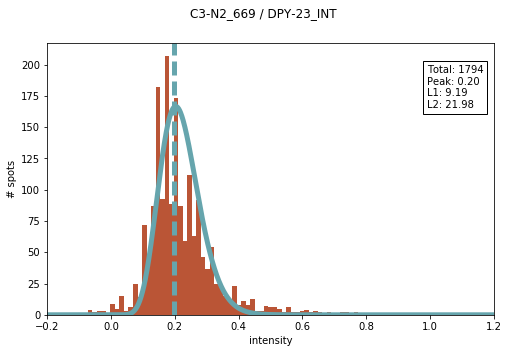

error: L1, L2 [0.93323910100713259, 3.001514989650631]
peak center: 0.125252525253


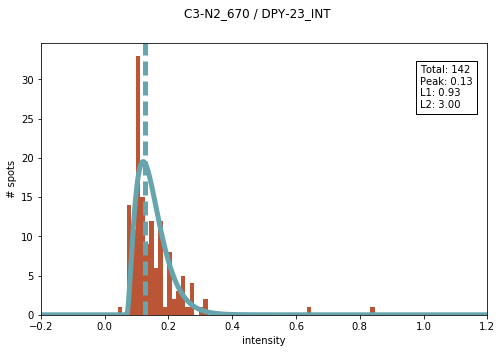

error: L1, L2 [6.7632425555844984, 15.770746473289163]
peak center: 0.210101010101


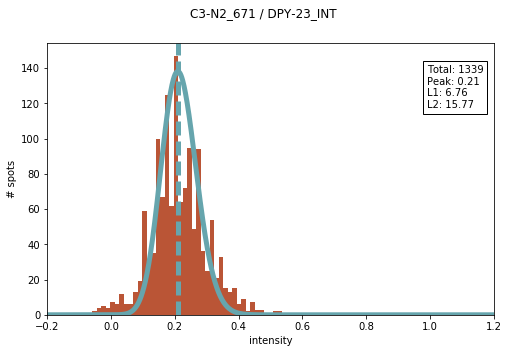

error: L1, L2 [2.0623004636208027, 5.1203478645106877]
peak center: 0.181818181818


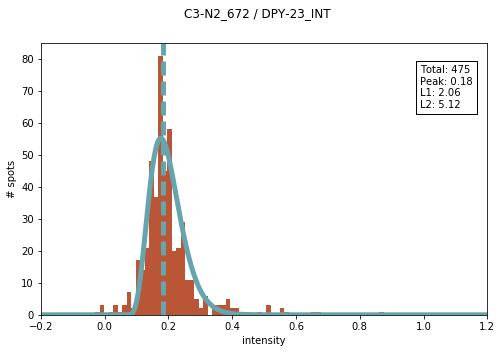

error: L1, L2 [2.3071920756145414, 5.8861282439485763]
peak center: 0.153535353535


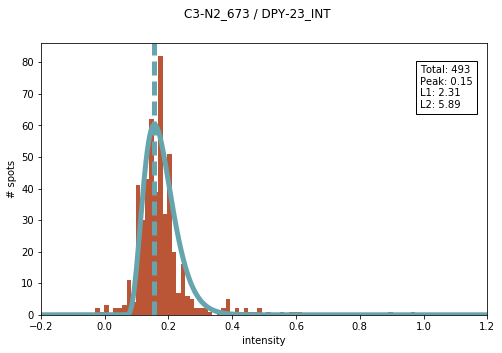

error: L1, L2 [5.6154446570283323, 13.368201993438177]
peak center: 0.181818181818


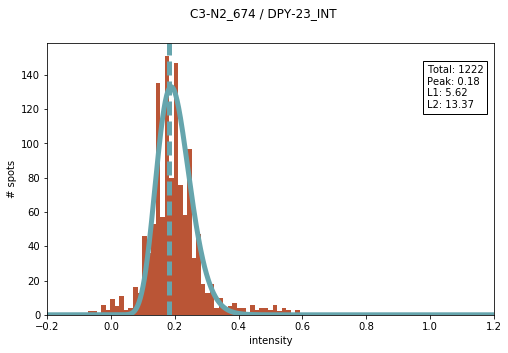

error: L1, L2 [0.97094977274363703, 1.9325955045169294]
peak center: 0.309090909091


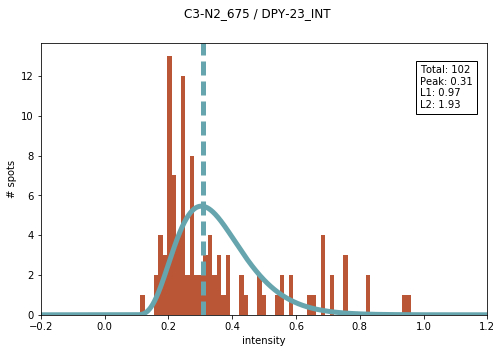

error: L1, L2 [0.79848850312204522, 1.8880949841540515]
peak center: 0.224242424242


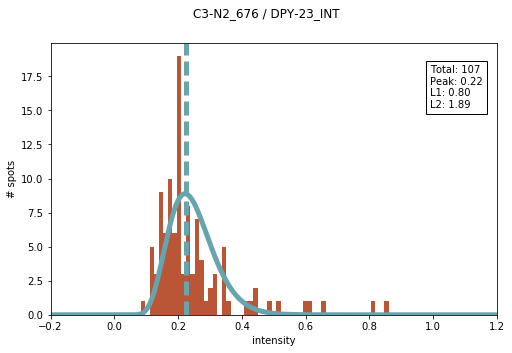

error: L1, L2 [9.0066643395584567, 21.835516053177869]
peak center: 0.167676767677


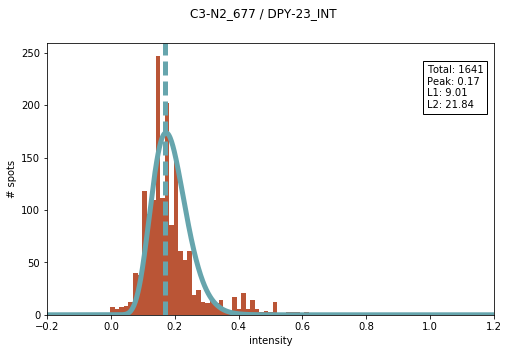

error: L1, L2 [5.3834480925625279, 12.130607334388516]
peak center: 0.19595959596


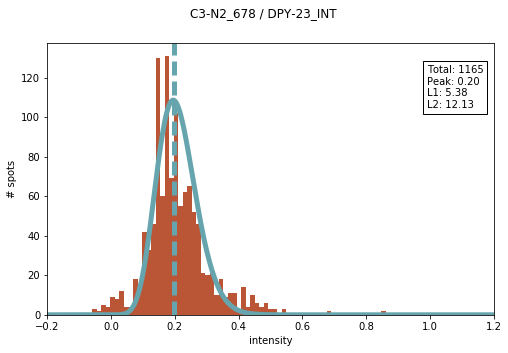

error: L1, L2 [6.140101472308622, 15.381882517739369]
peak center: 0.167676767677


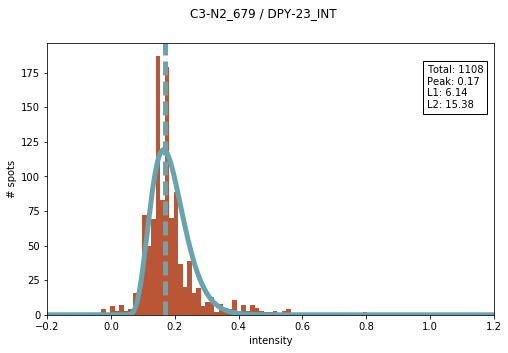

error: L1, L2 [4.7797744542809584, 14.659931736416672]
peak center: 0.139393939394


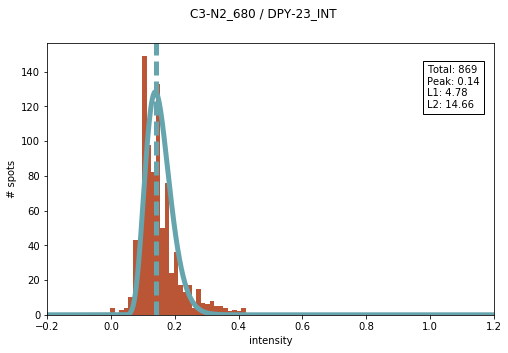

error: L1, L2 [7.6111002744411156, 17.51733614520646]
peak center: 0.210101010101


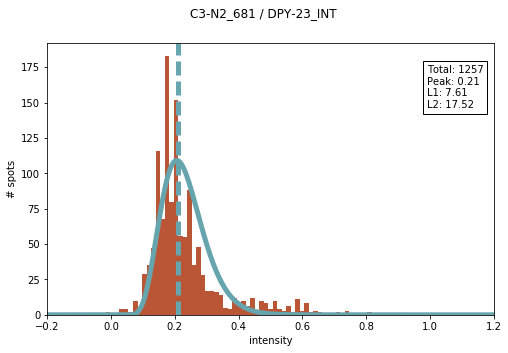

error: L1, L2 [3.3078167889355869, 7.683972803664493]
peak center: 0.181818181818


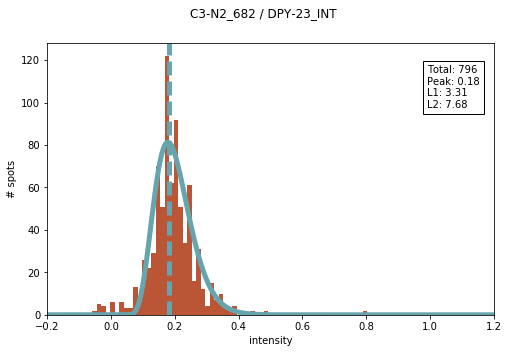

error: L1, L2 [5.1828450514768587, 14.466170338079474]
peak center: 0.167676767677


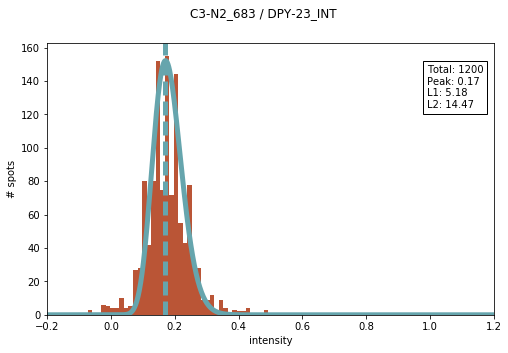

error: L1, L2 [2.1382998404529894, 5.752085976998476]
peak center: 0.139393939394


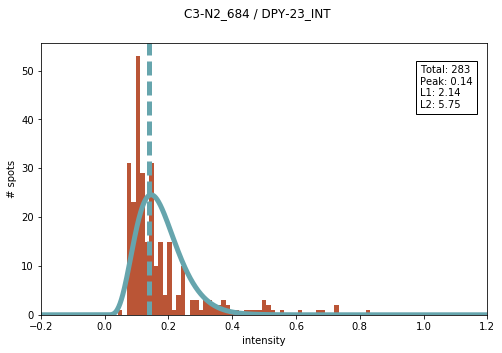

error: L1, L2 [5.9296577368178749, 14.968684471409635]
peak center: 0.19595959596


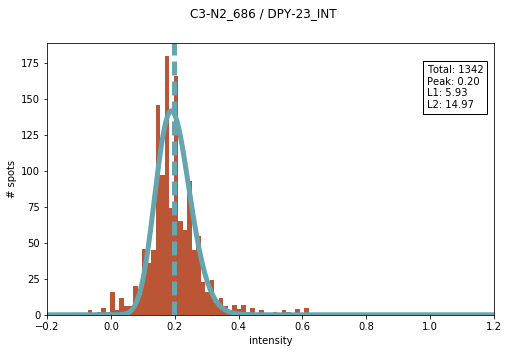

error: L1, L2 [5.1202011809965224, 14.508513456482426]
peak center: 0.181818181818


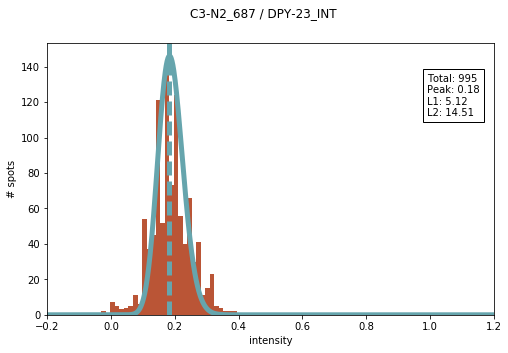

error: L1, L2 [0.70214173962145954, 1.7557841413928106]
peak center: 0.167676767677


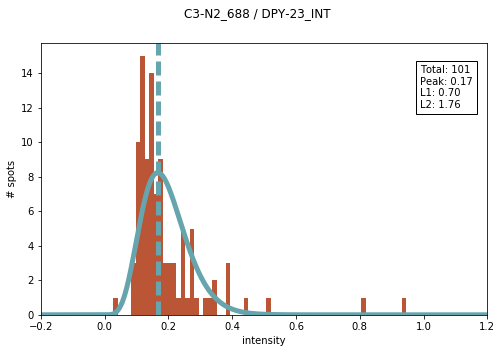

error: L1, L2 [0.57805608016703103, 1.2890957448854958]
peak center: 0.464646464646


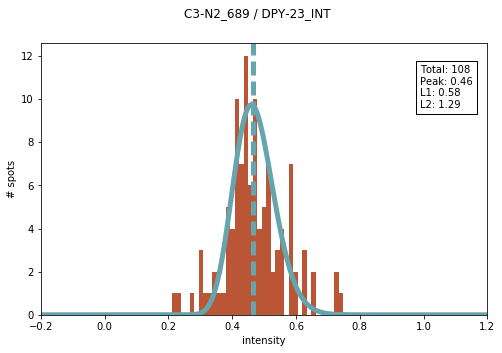

error: L1, L2 [1.0595693020931496, 2.7042317892318524]
peak center: 0.153535353535


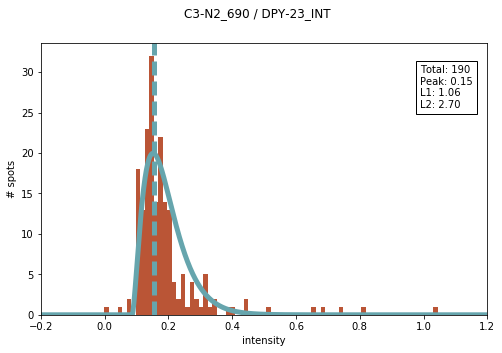

error: L1, L2 [5.722921841494423, 12.859900510918845]
peak center: 0.210101010101


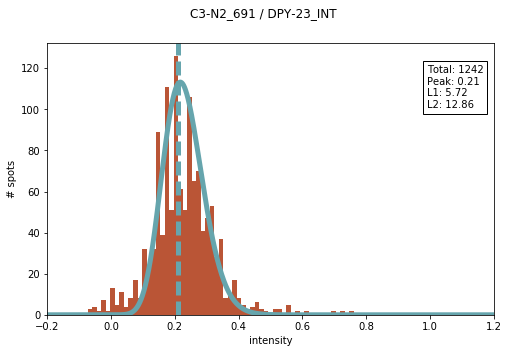

error: L1, L2 [7.976931621162457, 18.949576497497727]
peak center: 0.19595959596


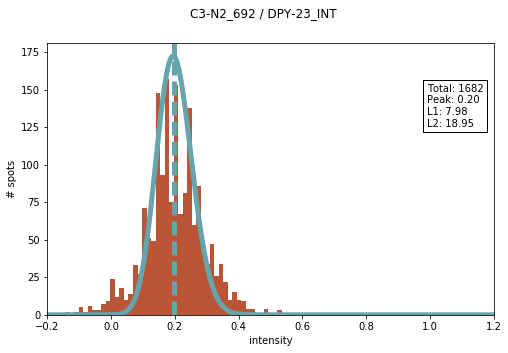

error: L1, L2 [2.4846012028434639, 6.9290297819193682]
peak center: 0.153535353535


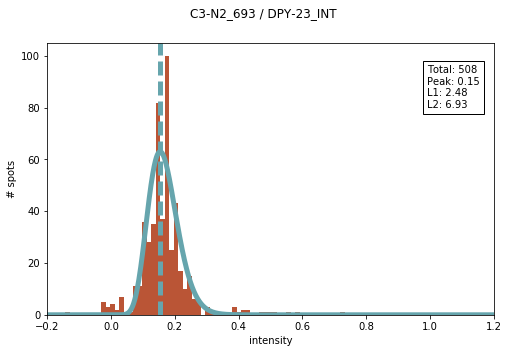

error: L1, L2 [7.1964329948883838, 19.236690362735608]
peak center: 0.167676767677


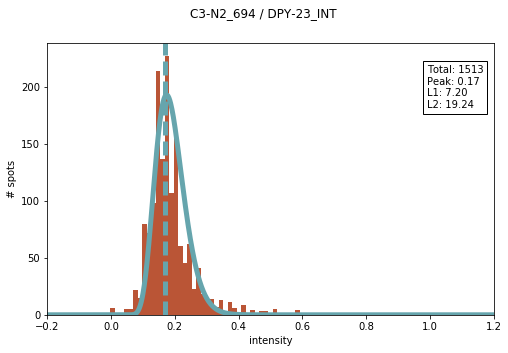

error: L1, L2 [3.0456536197374455, 10.979734804054166]
peak center: 0.111111111111


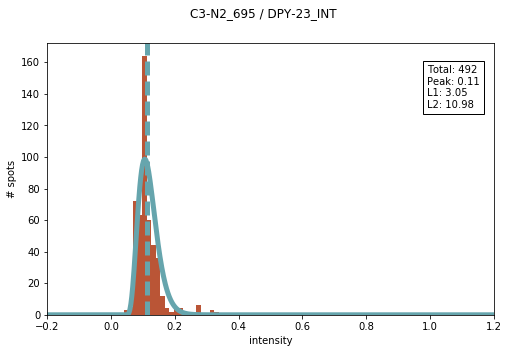

error: L1, L2 [1.3065167144660084, 2.9957083517448884]
peak center: 0.181818181818


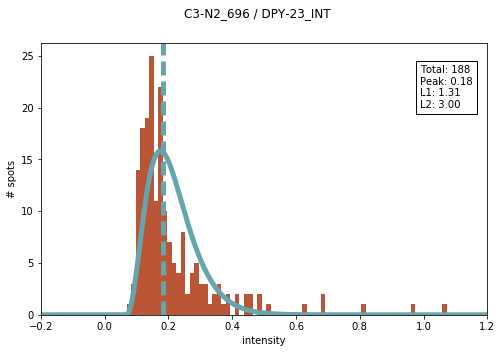

error: L1, L2 [0.88969944732753448, 2.285731331242487]
peak center: 0.153535353535


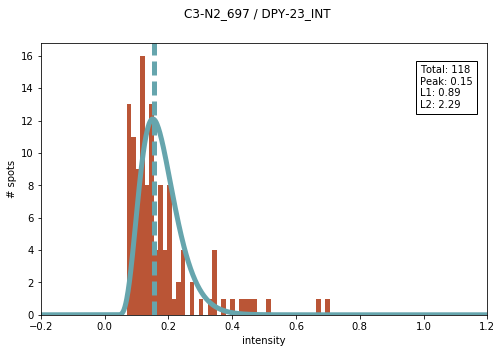

error: L1, L2 [7.0628989852470117, 17.005891243535405]
peak center: 0.210101010101


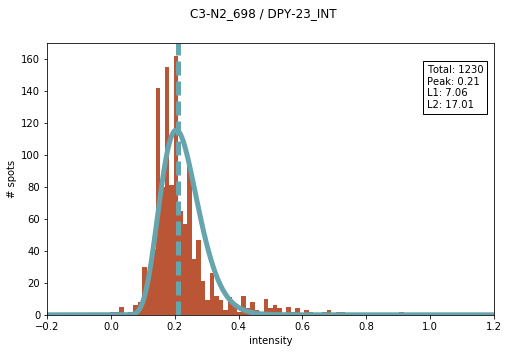

error: L1, L2 [5.0681730356200241, 14.024995983654181]
peak center: 0.139393939394


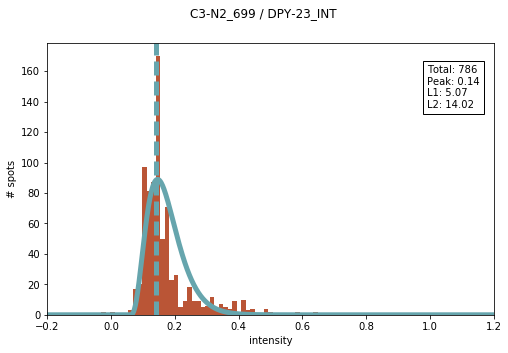

error: L1, L2 [10.027024806443483, 29.672982833592929]
peak center: 0.125252525253


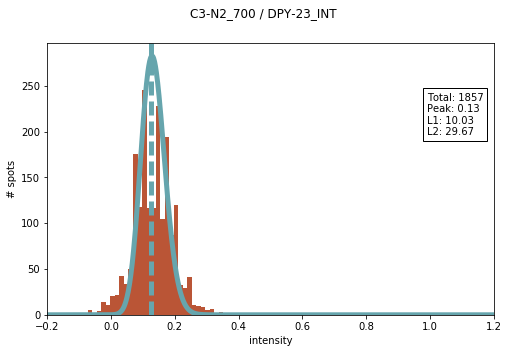

error: L1, L2 [1.4485330193711015, 4.9124069598981857]
peak center: 0.111111111111


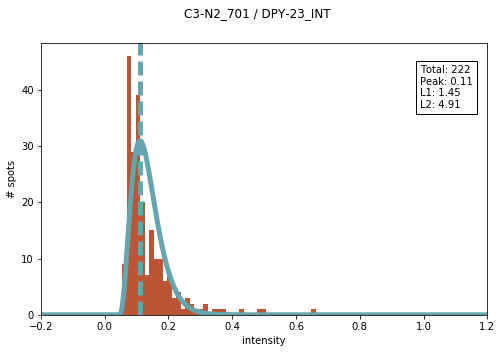

error: L1, L2 [2.509254916067031, 8.0907908515429376]
peak center: 0.111111111111


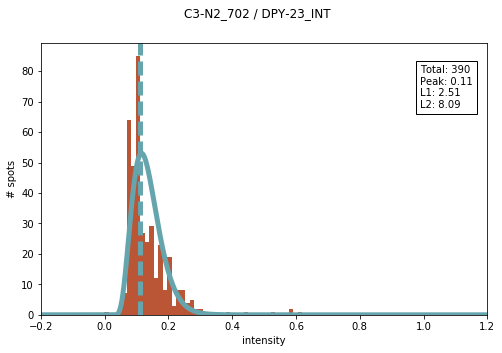

error: L1, L2 [12.009208642547154, 22.081922721559113]
peak center: 0.266666666667


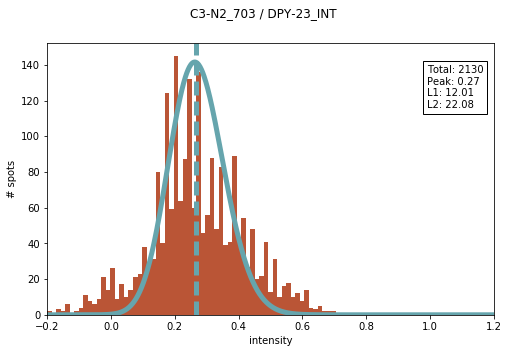

error: L1, L2 [0.77175188727716637, 2.4966022040652822]
peak center: 0.224242424242


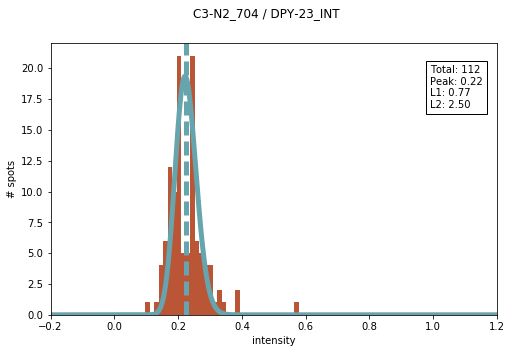

error: L1, L2 [6.090926988968433, 17.96593980862928]
peak center: 0.139393939394


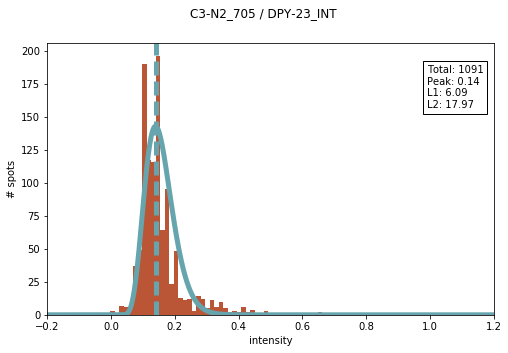

error: L1, L2 [4.7754671746235005, 13.301292287036455]
peak center: 0.167676767677


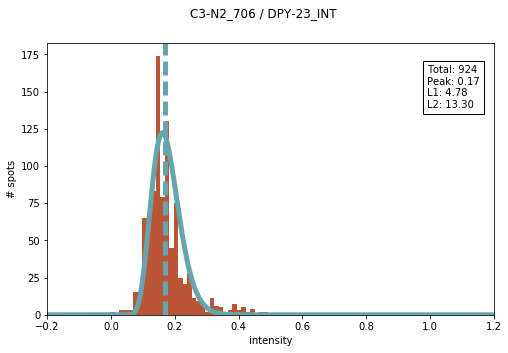

error: L1, L2 [6.263367492367709, 15.607516414176109]
peak center: 0.167676767677


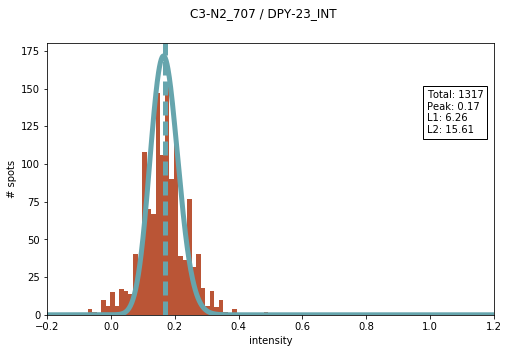

error: L1, L2 [3.1709137574034836, 8.6205962687919389]
peak center: 0.167676767677


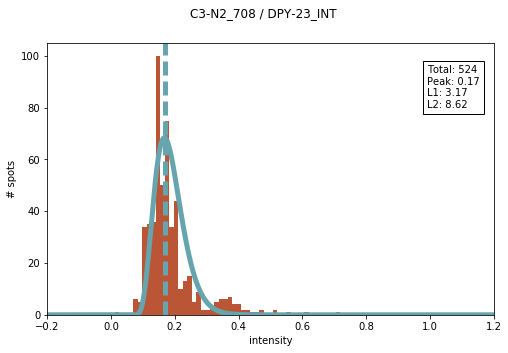

error: L1, L2 [3.3692877924385338, 12.284397617999213]
peak center: 0.111111111111


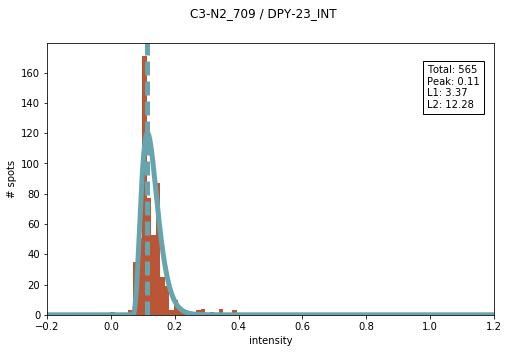

error: L1, L2 [3.807137830766913, 7.5953543254668441]
peak center: 0.379797979798


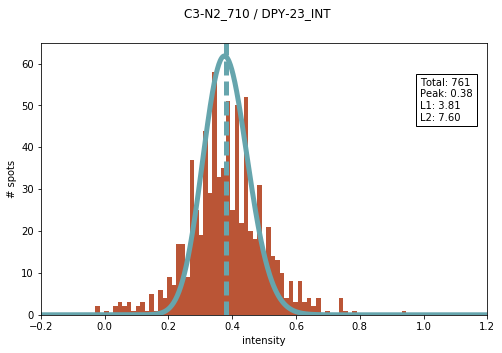

error: L1, L2 [6.7365354138822831, 16.274399968746643]
peak center: 0.167676767677


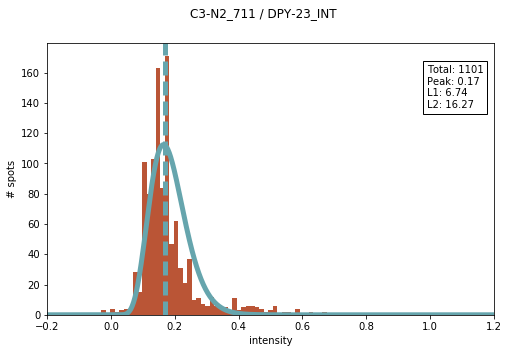

error: L1, L2 [7.270042981151418, 18.723999277040068]
peak center: 0.224242424242


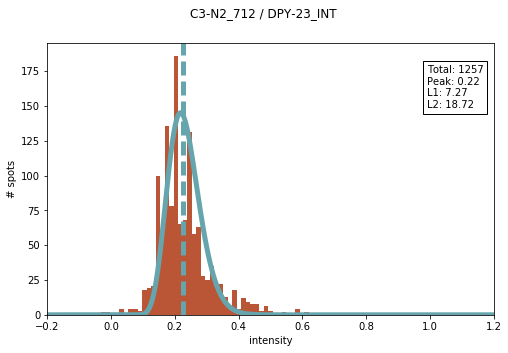

error: L1, L2 [6.8694449986189126, 20.368957953192339]
peak center: 0.139393939394


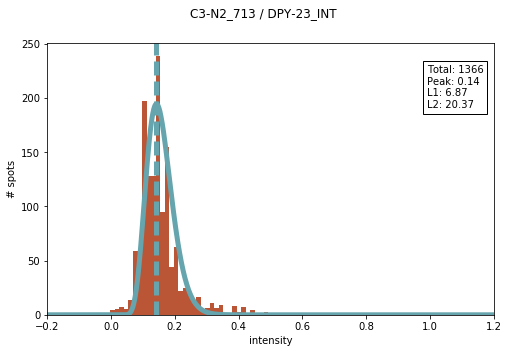

error: L1, L2 [5.8747482076140605, 17.070851883103082]
peak center: 0.153535353535


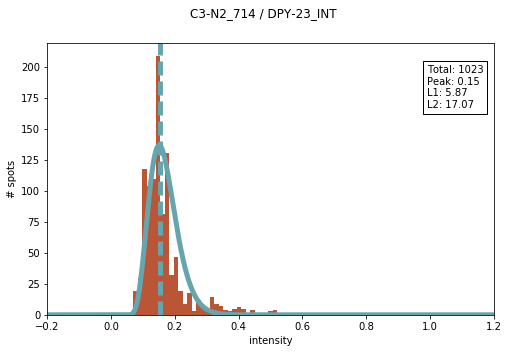

error: L1, L2 [3.2940894345003673, 9.8884054860562856]
peak center: 0.153535353535


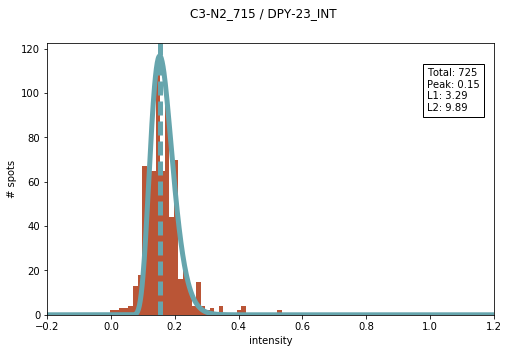

error: L1, L2 [5.2306375975191726, 12.312280067495141]
peak center: 0.181818181818


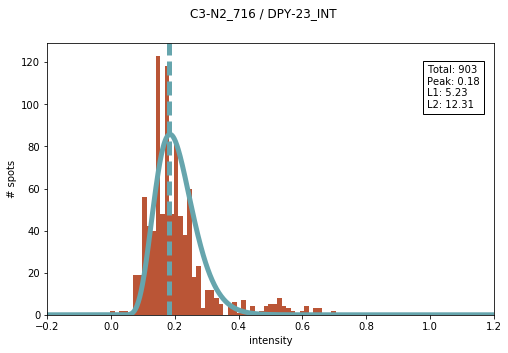

error: L1, L2 [2.4732206204545224, 4.9039725970299433]
peak center: 0.280808080808


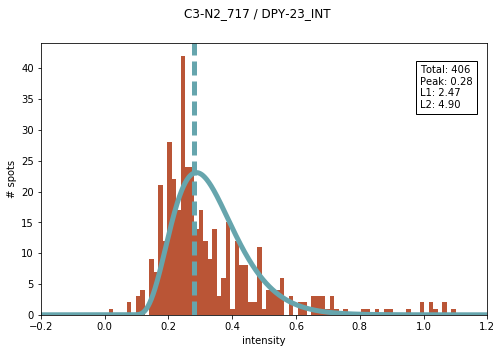

error: L1, L2 [3.6437251824527324, 10.806228770782747]
peak center: 0.139393939394


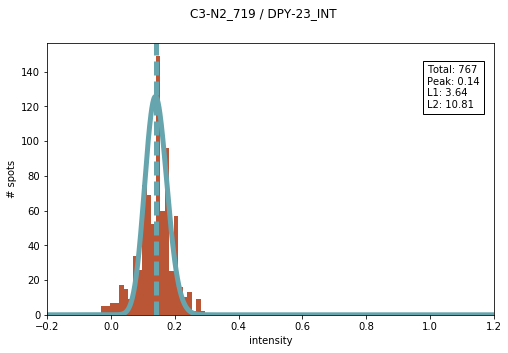

error: L1, L2 [6.7498453311682516, 19.09205865645896]
peak center: 0.139393939394


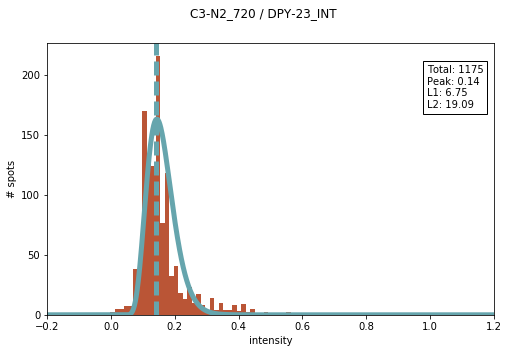

error: L1, L2 [1.2473835298410774, 3.4679854667362839]
peak center: 0.181818181818


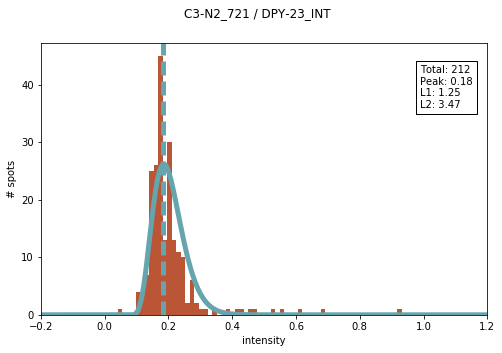

error: L1, L2 [1.3447934903800656, 3.1467712070364775]
peak center: 0.167676767677


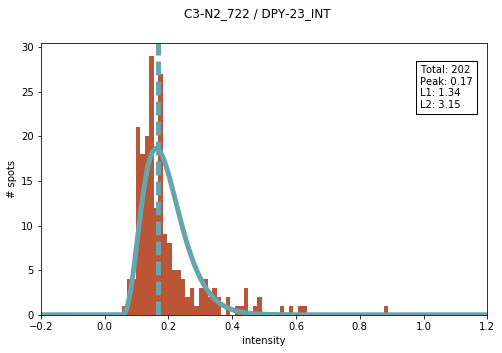

error: L1, L2 [5.4303835224745036, 15.399664109990264]
peak center: 0.153535353535


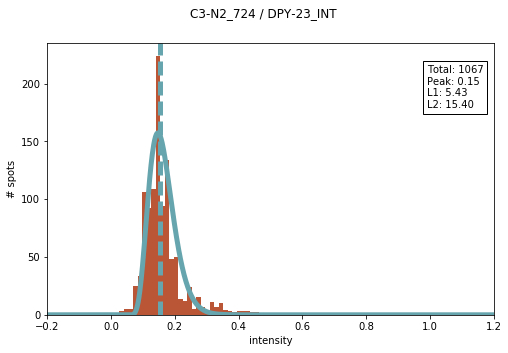

error: L1, L2 [0.2667965070200381, 1.4075368293594133]
peak center: 0.0262626262626


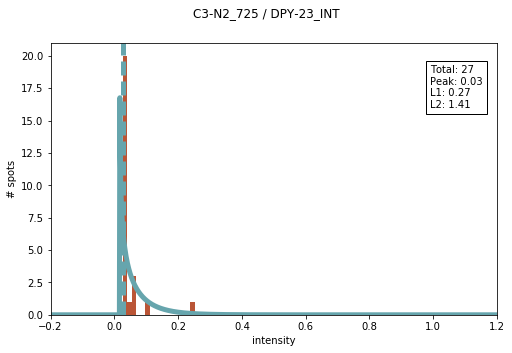

error: L1, L2 [12.456201825436901, 23.128771653543104]
peak center: 0.224242424242


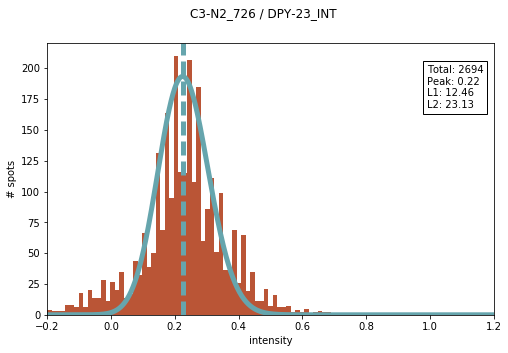

error: L1, L2 [3.3643381982957776, 10.021882746048503]
peak center: 0.139393939394


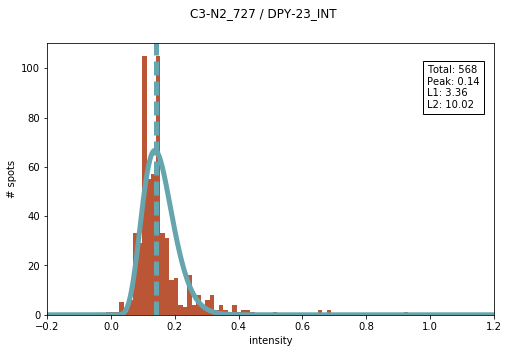

error: L1, L2 [0.18063190464106527, 0.43262058550922505]
peak center: 0.0969696969697


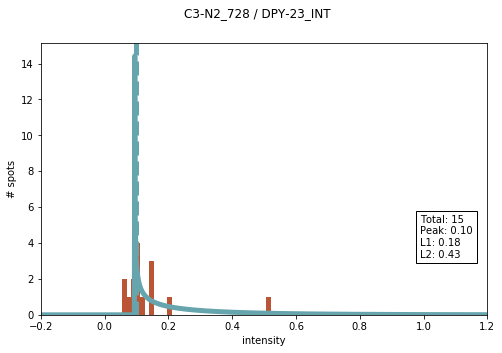

error: L1, L2 [4.5001602629486559, 11.346637907033573]
peak center: 0.153535353535


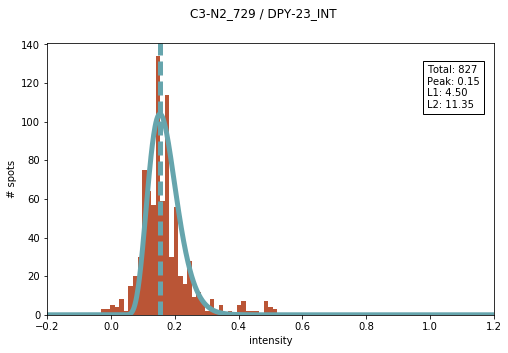

error: L1, L2 [7.4310929607642793, 19.009823978705025]
peak center: 0.167676767677


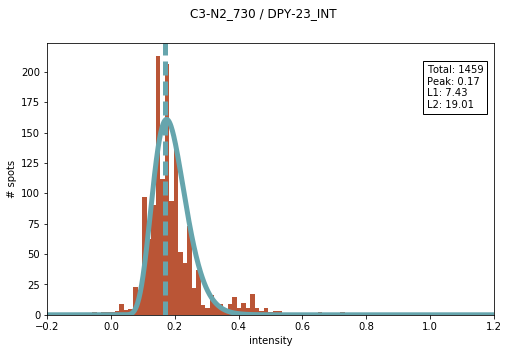

error: L1, L2 [9.1699351058551049, 22.37336064813044]
peak center: 0.19595959596


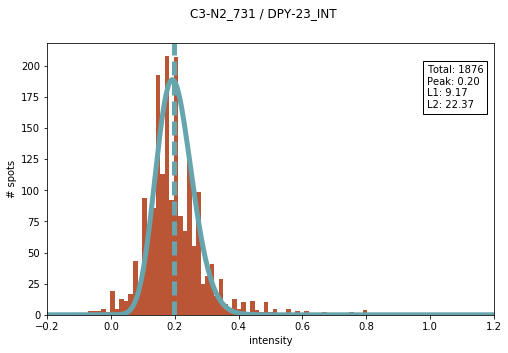

error: L1, L2 [1.3519492838197908, 4.2083539516026134]
peak center: 0.139393939394


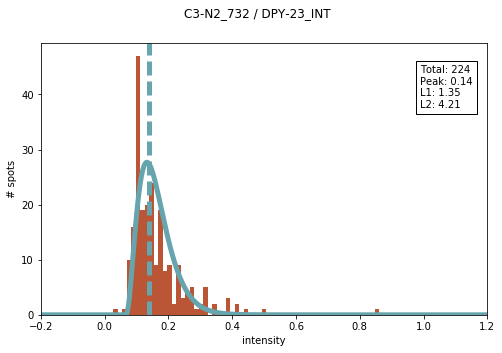

error: L1, L2 [0.28148175372306389, 0.56365381547627569]
peak center: 0.153535353535


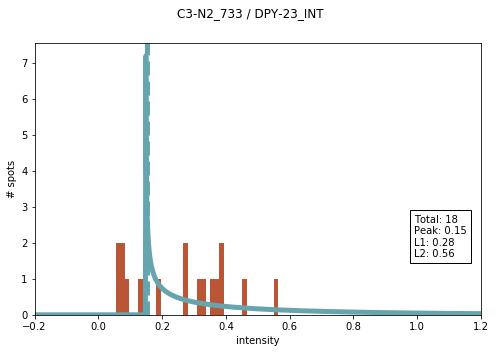

error: L1, L2 [0.82726498808470805, 2.4171854380785813]
peak center: 0.125252525253


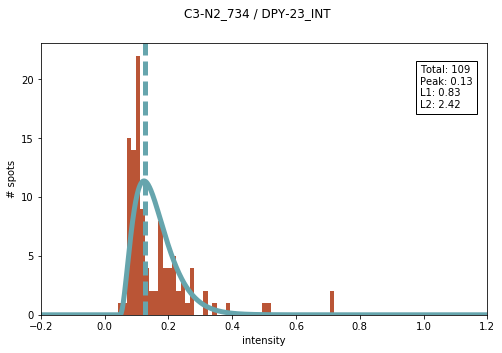

error: L1, L2 [7.0939515822999004, 18.89196459521834]
peak center: 0.167676767677


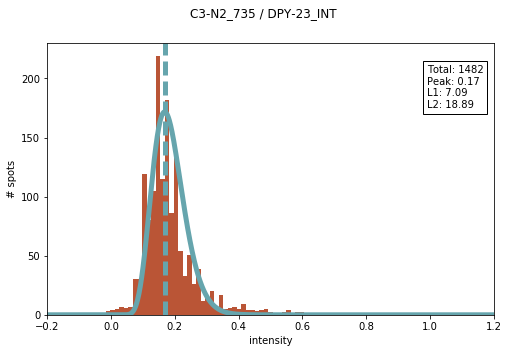

error: L1, L2 [8.2070513718446634, 20.11738489528566]
peak center: 0.210101010101


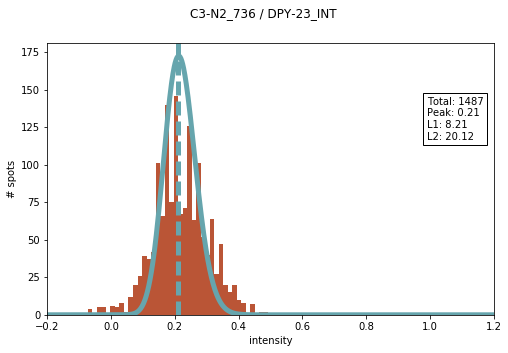

error: L1, L2 [0.41075803230607466, 0.98328045374735962]
peak center: 0.294949494949


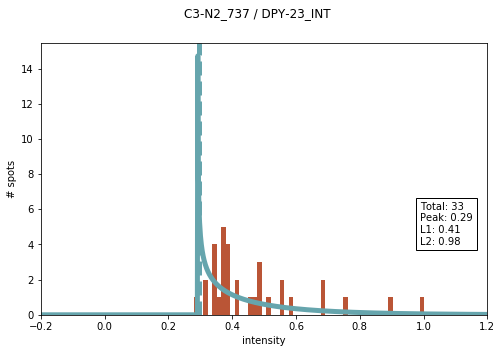

error: L1, L2 [1.8177126893794684, 7.0410001527011357]
peak center: 0.153535353535


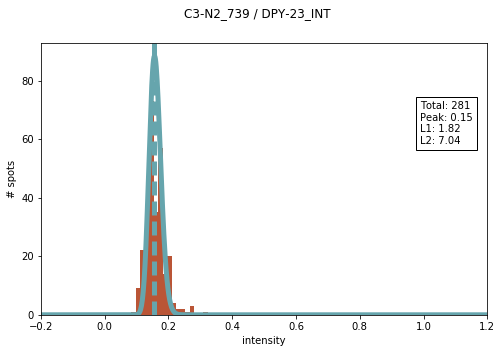

error: L1, L2 [5.217402222844286, 13.107508576207151]
peak center: 0.153535353535


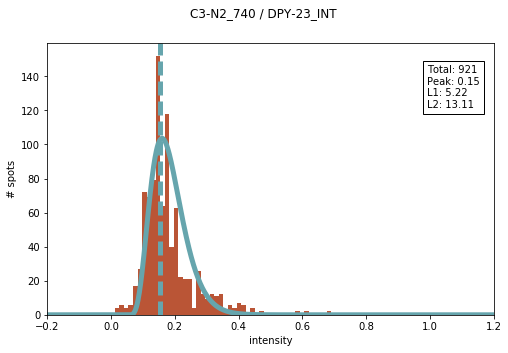

error: L1, L2 [4.1140218858940489, 9.0655001475574277]
peak center: 0.266666666667


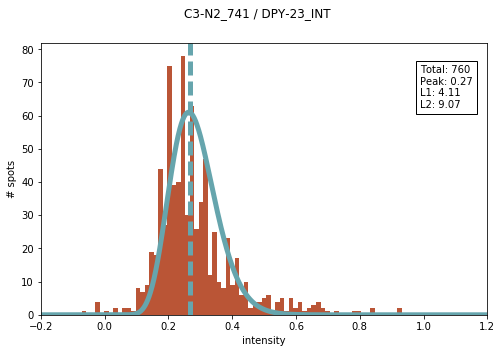

error: L1, L2 [6.2149783312401068, 17.347397738009487]
peak center: 0.210101010101


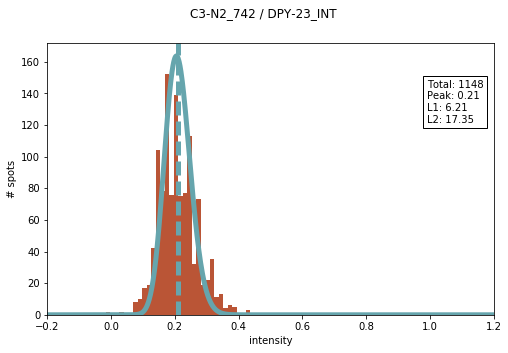

error: L1, L2 [7.2712058858394588, 16.170952168313587]
peak center: 0.224242424242


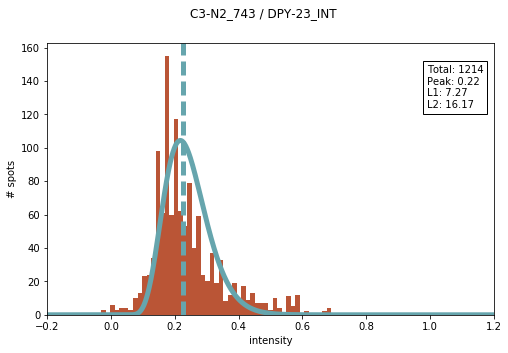

error: L1, L2 [1.6410996723294093, 3.8410791860374931]
peak center: 0.337373737374


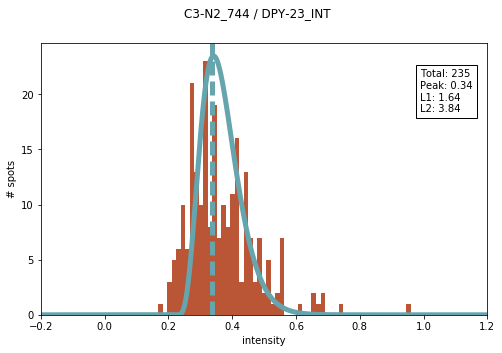

error: L1, L2 [6.837458114427986, 17.367280483861229]
peak center: 0.210101010101


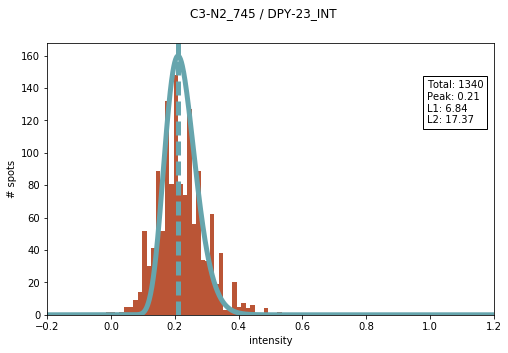

error: L1, L2 [8.4502167807905941, 24.13436266672819]
peak center: 0.167676767677


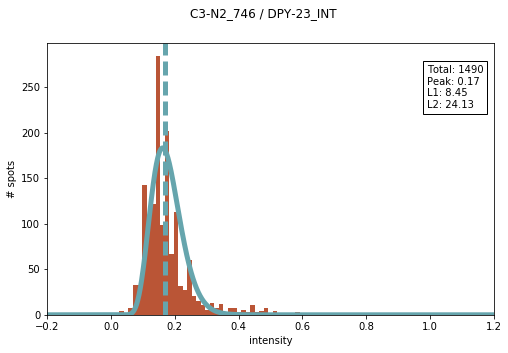

error: L1, L2 [2.6412762407391224, 6.7442056632518881]
peak center: 0.181818181818


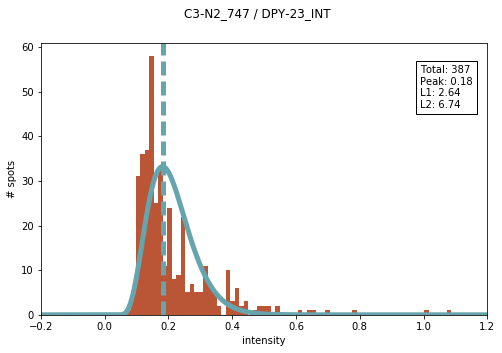

error: L1, L2 [0.34261418656479808, 0.7296301741874589]
peak center: 0.210101010101


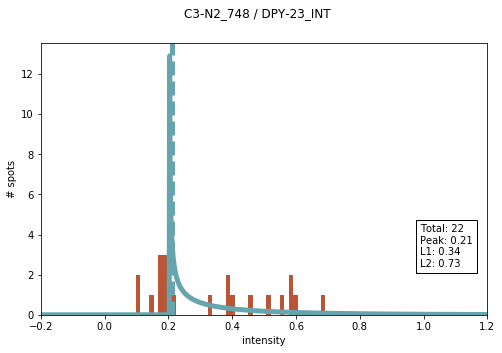

error: L1, L2 [4.6693027253159869, 16.297464667876049]
peak center: 0.125252525253


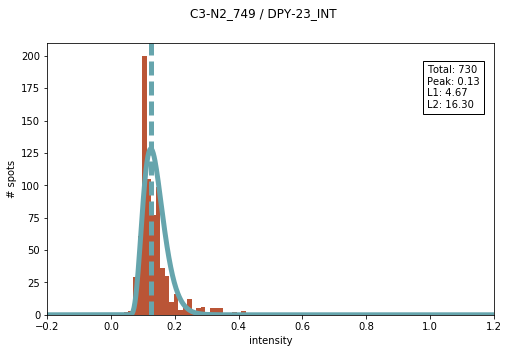

error: L1, L2 [2.4460974755251228, 9.022281370794575]
peak center: 0.125252525253


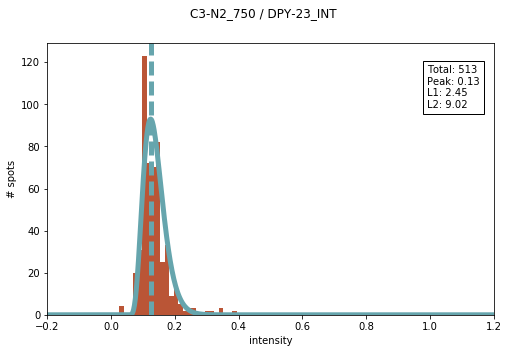

error: L1, L2 [4.993288649707627, 11.63324091313636]
peak center: 0.266666666667


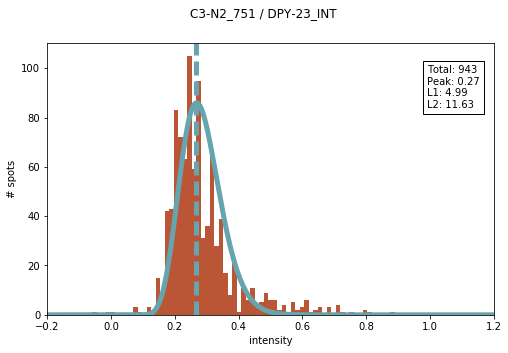

error: L1, L2 [8.872672084629242, 19.742795455430407]
peak center: 0.210101010101


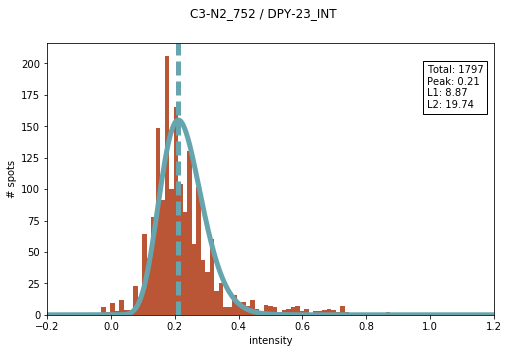

error: L1, L2 [3.7884368379216653, 10.912665383948886]
peak center: 0.139393939394


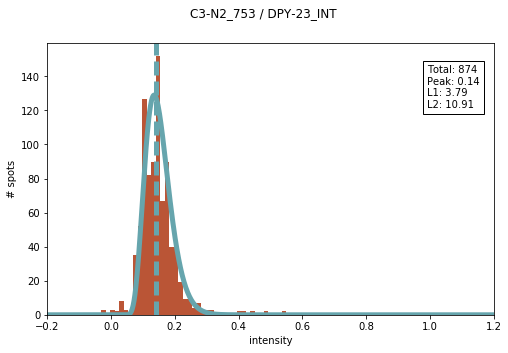

error: L1, L2 [5.9485127489861656, 13.351168660468533]
peak center: 0.252525252525


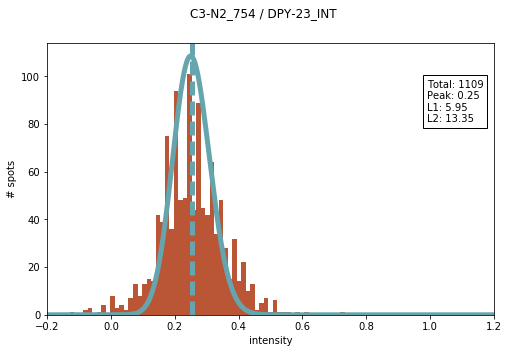

error: L1, L2 [4.4847805889866192, 11.946127232160846]
peak center: 0.167676767677


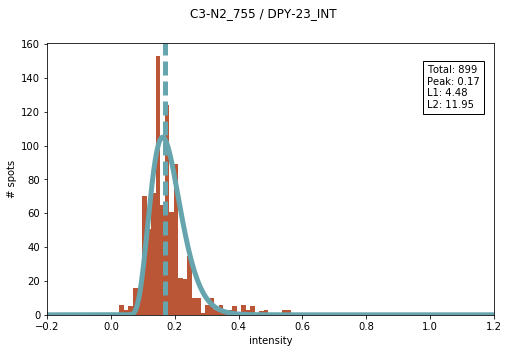

error: L1, L2 [5.118981927499699, 12.678580184971707]
peak center: 0.294949494949


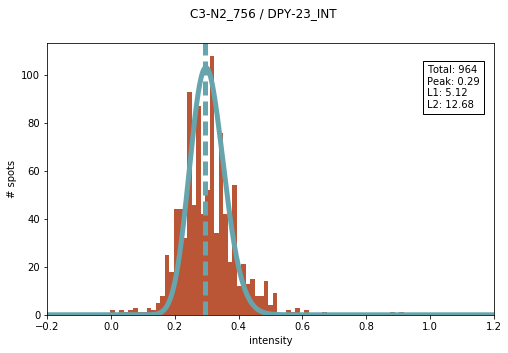

error: L1, L2 [4.6690528619384191, 12.225752211971482]
peak center: 0.167676767677


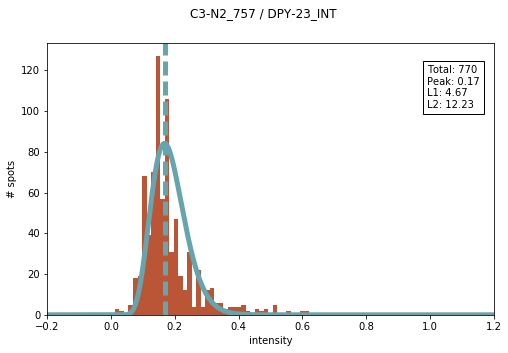

error: L1, L2 [0.68978419497139676, 1.6202767029381169]
peak center: 0.464646464646


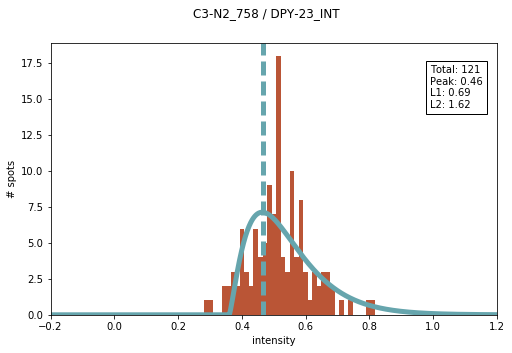

error: L1, L2 [2.6387143526763515, 10.220035423713362]
peak center: 0.125252525253


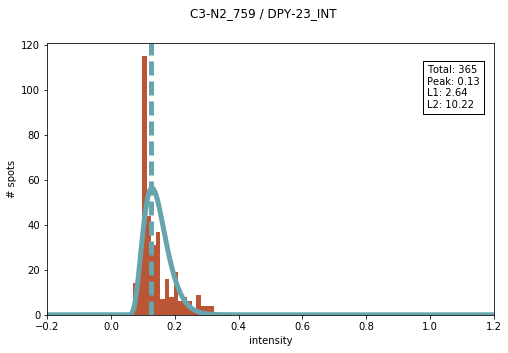

error: L1, L2 [5.8572582801119459, 15.433744472318461]
peak center: 0.224242424242


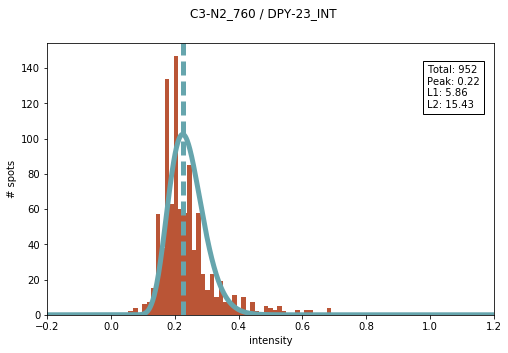

error: L1, L2 [0.57390430725092922, 1.6450780137539616]
peak center: 0.181818181818


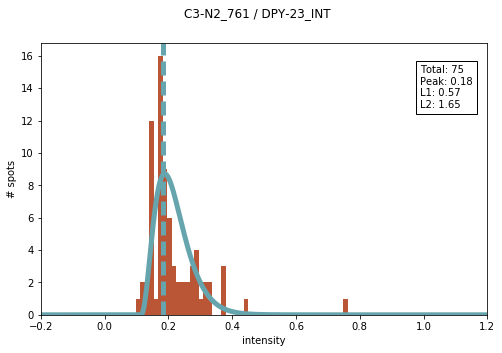

error: L1, L2 [0.59970360508471265, 1.5498412457768487]
peak center: 0.139393939394


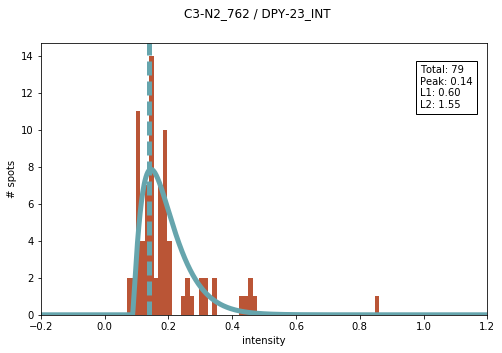

error: L1, L2 [4.4319922434374579, 10.233948976059514]
peak center: 0.266666666667


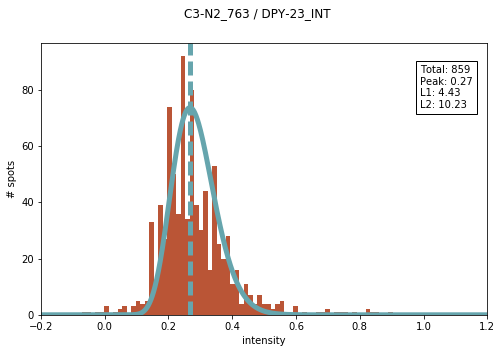

error: L1, L2 [12.010941896598629, 34.191260602022268]
peak center: 0.125252525253


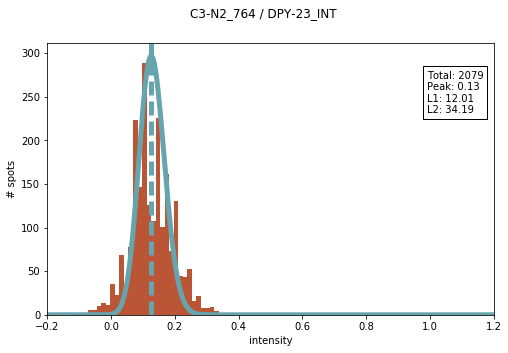

error: L1, L2 [0.13425144281969417, 0.38520946793723415]
peak center: 0.294949494949


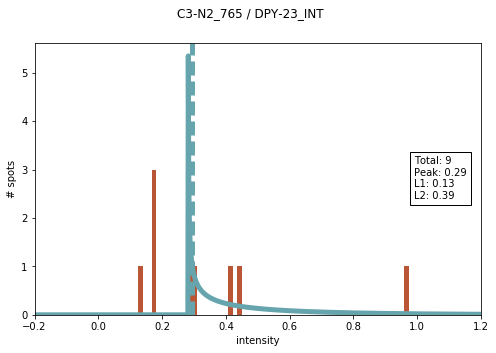

error: L1, L2 [2.6154352762203721, 9.1913002364662262]
peak center: 0.139393939394


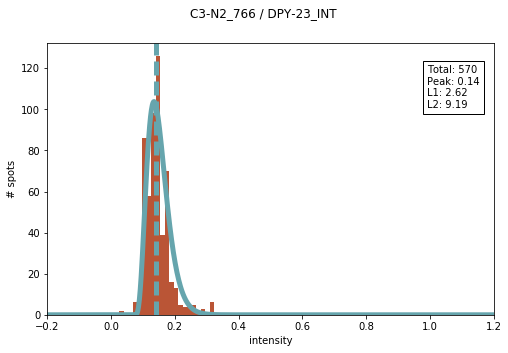

error: L1, L2 [0.69632764239147127, 1.9073818058770005]
peak center: 0.153535353535


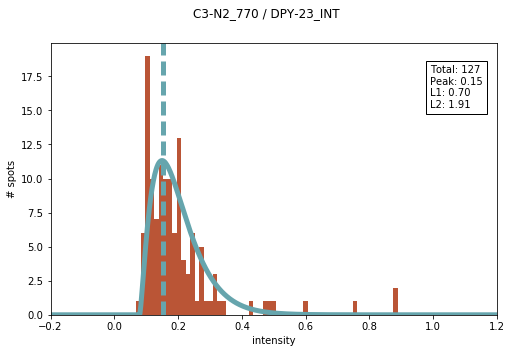

error: L1, L2 [2.1736056975546192, 7.7847693608938959]
peak center: 0.139393939394


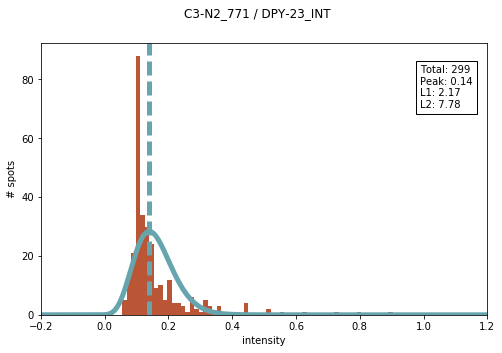

error: L1, L2 [5.8100442239108858, 14.327052890630943]
peak center: 0.210101010101


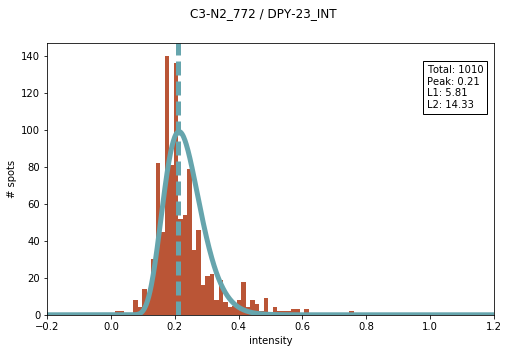

error: L1, L2 [0.62018839451473473, 1.8509420703206738]
peak center: 0.0969696969697


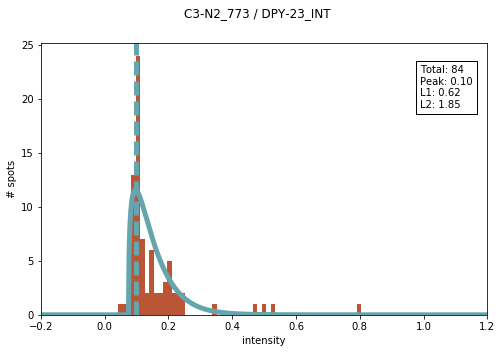

error: L1, L2 [1.3083198952946469, 4.5224936696625928]
peak center: 0.125252525253


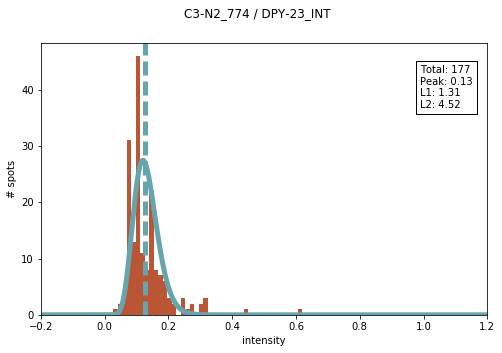

error: L1, L2 [9.7470172090519416, 21.470508768785987]
peak center: 0.210101010101


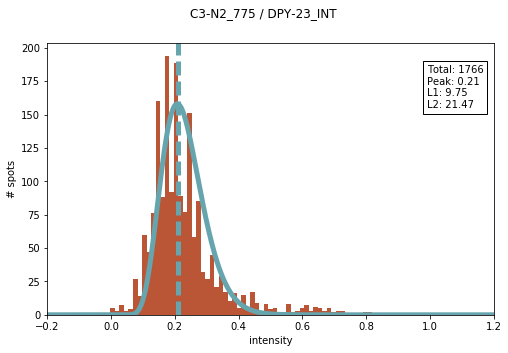

error: L1, L2 [6.1910883031651753, 17.696185860686516]
peak center: 0.167676767677


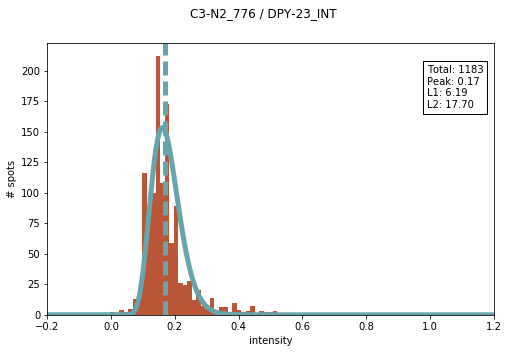

error: L1, L2 [3.2139406777625696, 11.652241861656471]
peak center: 0.125252525253


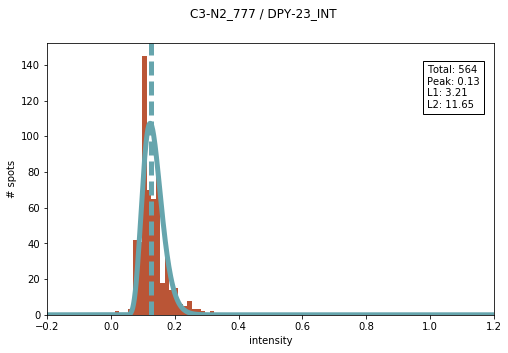

error: L1, L2 [3.4467465392942604, 9.8089272687000637]
peak center: 0.153535353535


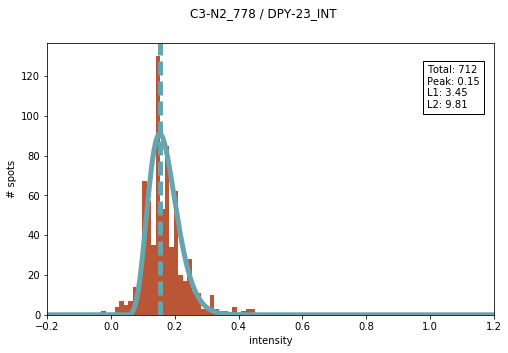

error: L1, L2 [5.5690802954529728, 15.324554544200867]
peak center: 0.167676767677


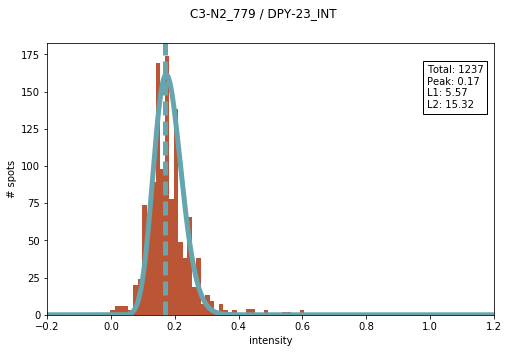

error: L1, L2 [4.1219010656172692, 12.692121337638811]
peak center: 0.125252525253


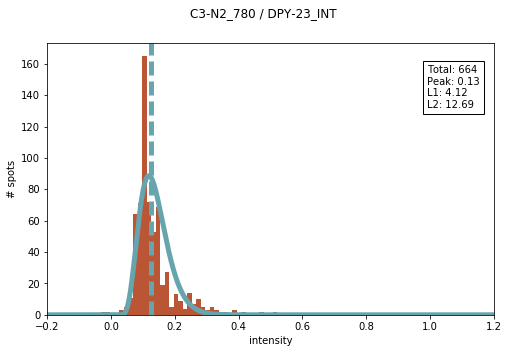

error: L1, L2 [7.1713617133513994, 18.198310946449482]
peak center: 0.153535353535


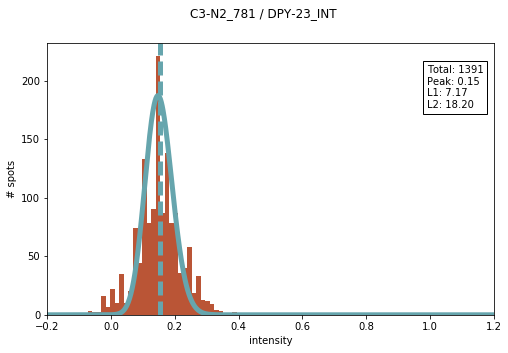

error: L1, L2 [7.2735465409223572, 17.587271031973412]
peak center: 0.252525252525


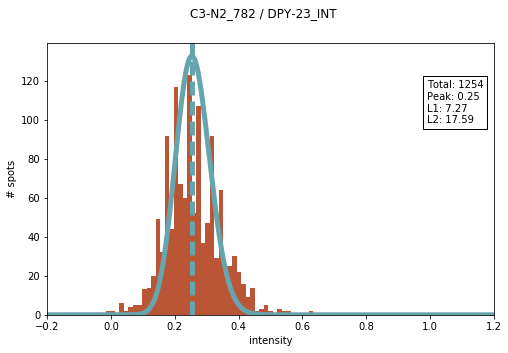

error: L1, L2 [2.8503342567107315, 9.3244196278847689]
peak center: 0.111111111111


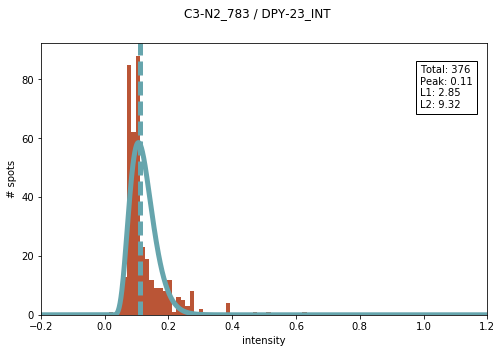

error: L1, L2 [0.8097560125963279, 2.4139070053783187]
peak center: 0.0969696969697


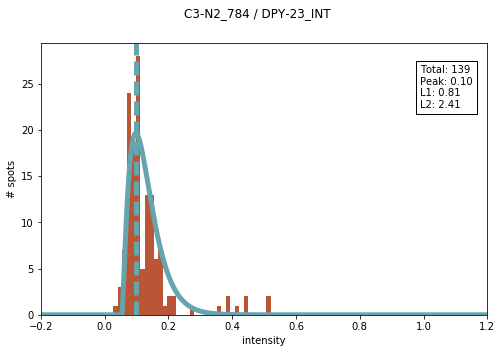

error: L1, L2 [3.6901047324863785, 12.618623222155422]
peak center: 0.125252525253


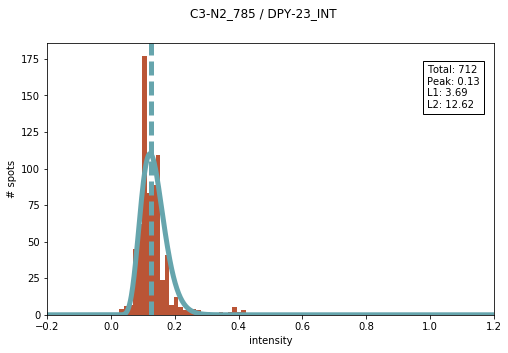

error: L1, L2 [1.4752022373507583, 4.0298267620279127]
peak center: 0.153535353535


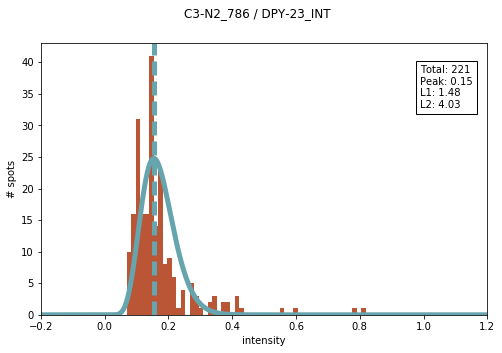

There was an exception but we'll fix it for you
error: L1, L2 [1.016837946221516, 3.5809572250458612]
peak center: 0.125252525253


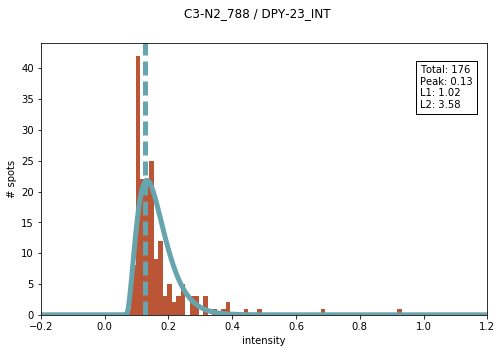

error: L1, L2 [10.225362812209882, 27.818962394568203]
peak center: 0.139393939394


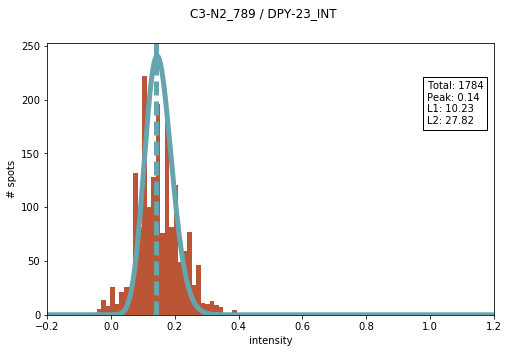

error: L1, L2 [0.97772974247950895, 2.9459471449235832]
peak center: 0.153535353535


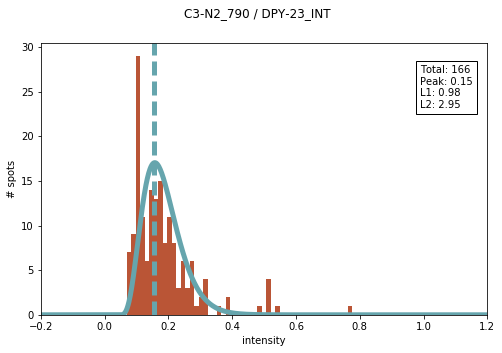

error: L1, L2 [0.6642710956722534, 2.0545070755373125]
peak center: 0.111111111111


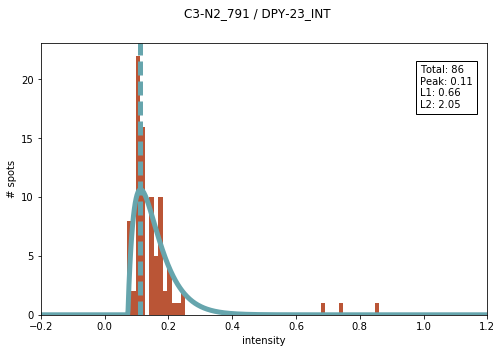

error: L1, L2 [2.4867756564638355, 9.0950963014278425]
peak center: 0.125252525253


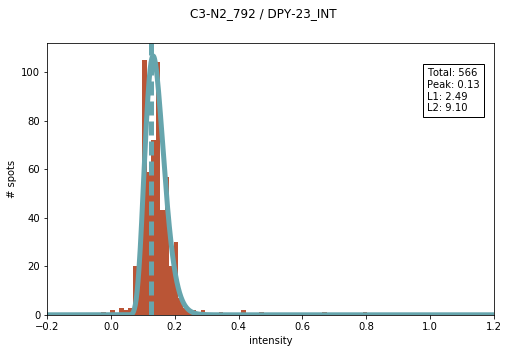

error: L1, L2 [3.5996898773713157, 10.72908164954028]
peak center: 0.153535353535


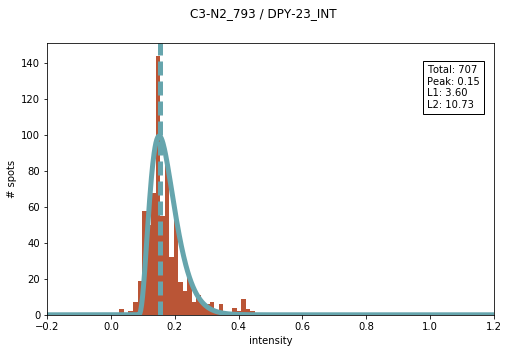

error: L1, L2 [0.50085835193994666, 1.1215168284291048]
peak center: 0.111111111111


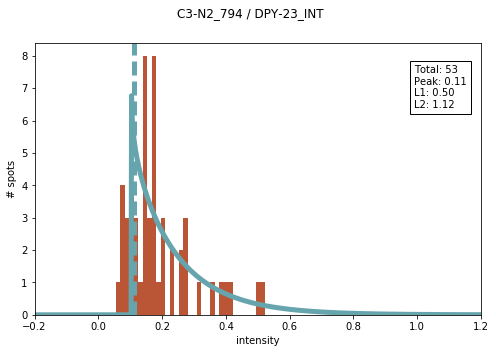

error: L1, L2 [6.603882387353825, 19.260223828253377]
peak center: 0.181818181818


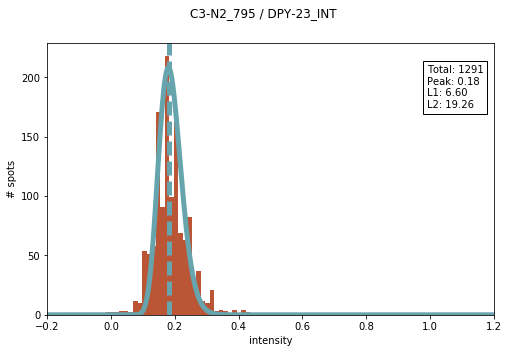

error: L1, L2 [5.0241296745710766, 13.090926874960534]
peak center: 0.266666666667


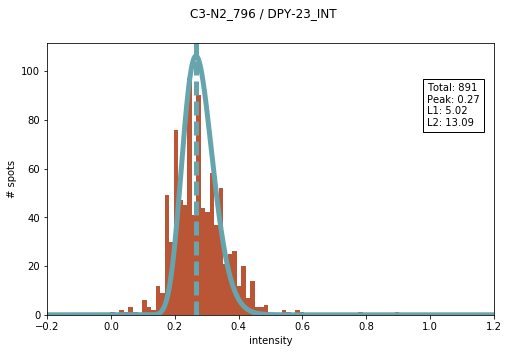

error: L1, L2 [3.5168122139369817, 11.438119404481801]
peak center: 0.125252525253


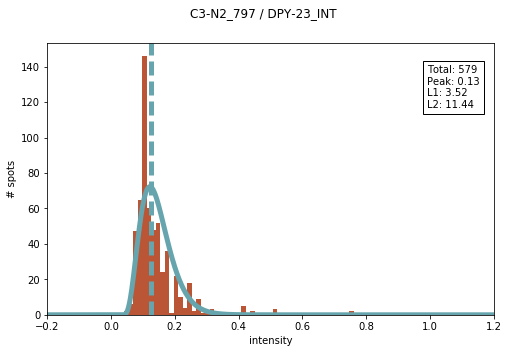

error: L1, L2 [4.2822144020503456, 12.014064786065685]
peak center: 0.181818181818


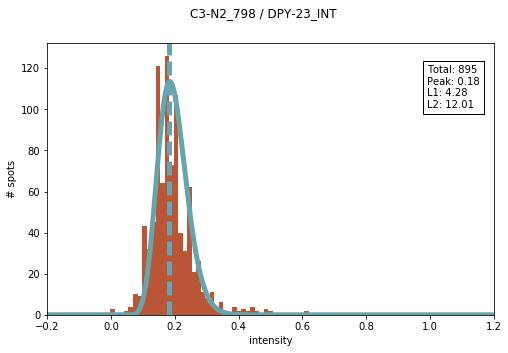

error: L1, L2 [1.1085439636703345, 4.1679982822622019]
peak center: 0.0828282828283


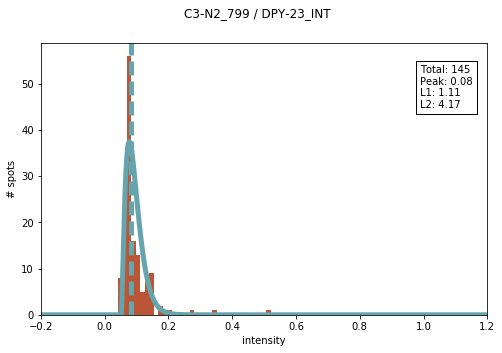

error: L1, L2 [6.3046594798526705, 16.677451513852905]
peak center: 0.167676767677


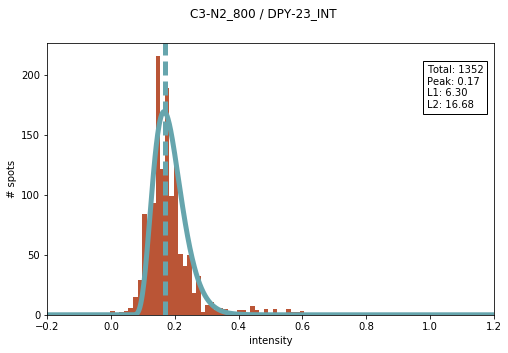

error: L1, L2 [9.9604633669729896, 25.650599004601435]
peak center: 0.139393939394


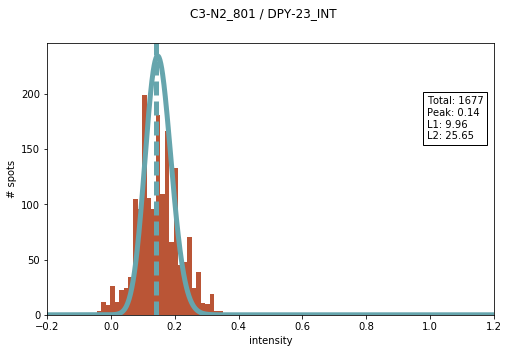

error: L1, L2 [7.5142530061092794, 18.503396666529003]
peak center: 0.181818181818


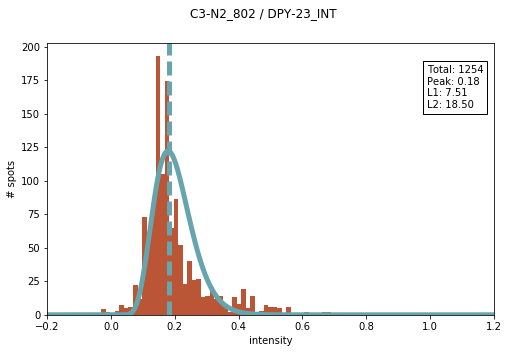

error: L1, L2 [2.5428917686023356, 8.35442212360085]
peak center: 0.0828282828283


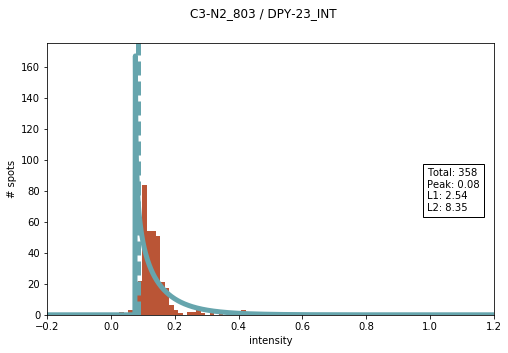

error: L1, L2 [1.8837261114349386, 5.6435030775614692]
peak center: 0.153535353535


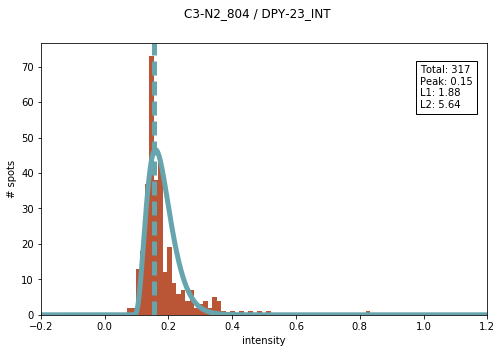

error: L1, L2 [1.4572477407675373, 4.9941507207144911]
peak center: 0.111111111111


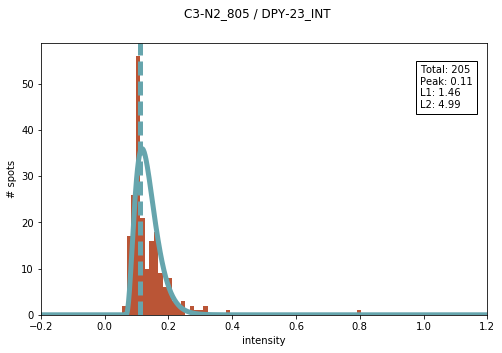

error: L1, L2 [6.8831273163882161, 17.033224984299139]
peak center: 0.181818181818


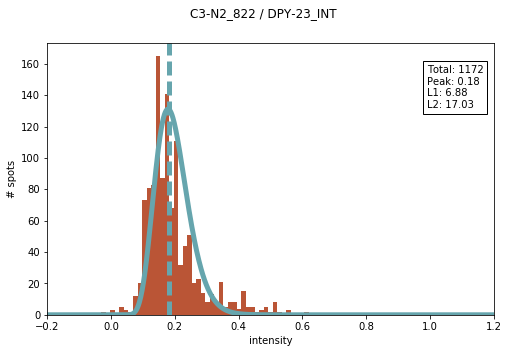

error: L1, L2 [0.46417652386339514, 1.2943466266792962]
peak center: 0.252525252525


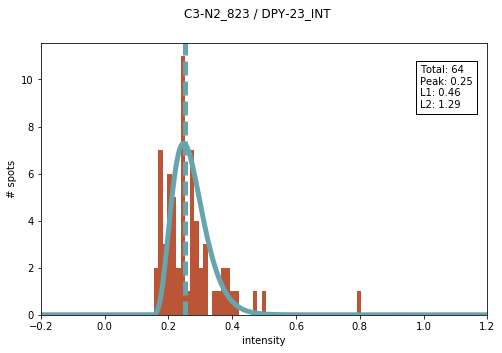

error: L1, L2 [1.6512129148527028, 3.8604059198591569]
peak center: 0.266666666667


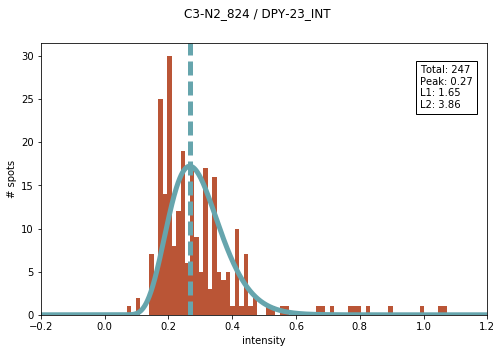

error: L1, L2 [1.3323028046266474, 4.7946501814188807]
peak center: 0.111111111111


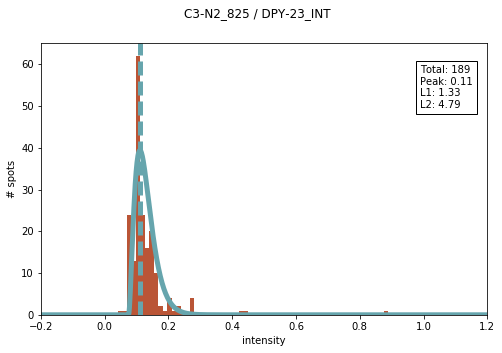

error: L1, L2 [7.5613332314719477, 17.628813036626994]
peak center: 0.181818181818


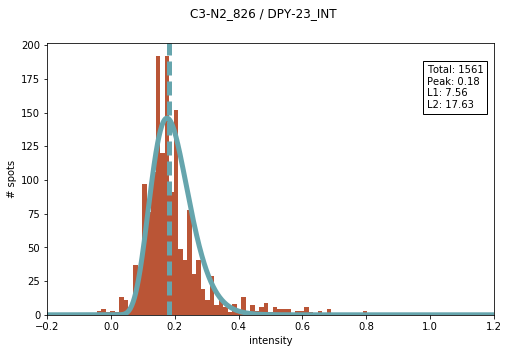

error: L1, L2 [3.8733999258470178, 9.8603165416497092]
peak center: 0.153535353535


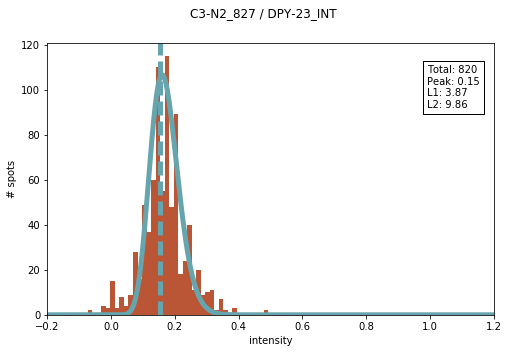

error: L1, L2 [5.1040895016187173, 13.148399944196706]
peak center: 0.167676767677


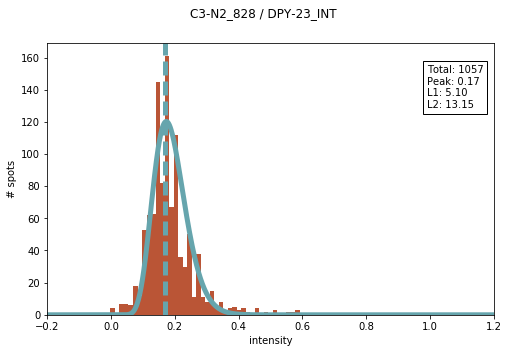

error: L1, L2 [2.4356473238850356, 8.8698814224797307]
peak center: 0.125252525253


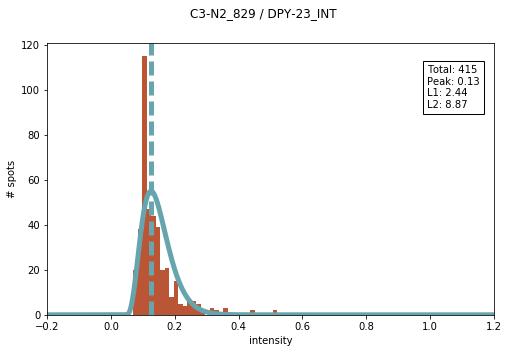

In [55]:
# have to perform this step multiple times and choose the best one 
# perform n_fits with different initial parameters
# n_fits = 10

center_set = {}

# actual plotting 
for idx in range(0, len(dataset)):    
    if(not os.path.exists(dataset[idx])):
        # print("doesn't exist")
        continue
        
    try:
        # create the canvas
        fig = plt.figure(figsize=(8,5))
        title = create_title(dataset[idx], name_id=-1)
        fig.suptitle(title + " / " + labels[0])

        # load the data and scale it accordingly
        I = load_data(dataset[idx], skiprows_= 0)
        
        # I_res = I
        # attempt to smooth the data a bit
        window_width = 7
        I_res = savgol_filter(I, window_width, 3)
        # calculate the params for gauss fit
        binned_values, real_bins = np.histogram(I, bins)
        
        use_median = np.median(I_res)
        use_mean = np.mean(I_res)
        fit_alpha, fit_loc, fit_beta = gamma.fit(I_res, loc=use_median/2, scale=1/np.max(binned_values))
        # normalization factor
        factor = np.sum(binned_values*np.diff(real_bins))

        plt.hist(I, bins=bins, color=color, label=labels, normed=False)

        x = np.linspace(xmin, xmax, 1000)
        y = gamma.pdf(x, fit_alpha, fit_loc, fit_beta)*factor
        plt.plot(x,y, linewidth=5, color='#66A5AD')
        yhat = gamma.pdf(real_bins, fit_alpha, fit_loc, fit_beta)*factor

        # vertical line for center
        plt.axvline(x=real_bins[np.argmax(yhat)], linestyle="--", linewidth=5, color='#66A5AD')

        if (np.any(np.isnan(yhat))):
            continue

        error = fitter_meter(binned_values, yhat[:-1])

        print("error: L1, L2", error)
        print("peak center:", real_bins[np.argmax(yhat)])

        # reasonable adjustments to make the data look nicer
        plt.xlabel('intensity')
        plt.ylabel('# spots')

        info_text = "Total: " + str(I.shape[0]) + "\n" + "Peak: " +  str('%.2f' % real_bins[np.argmax(yhat)]) + "\n" + "L1: " + str('%.2f' % error[0]) + "\n" + "L2: " +  str('%.2f' % error[1]) 

        x_limits = [xmin, xmax]
        ymax = np.max(np.histogram(I, bins)[0])
        y_limits = [0, ymax]

        plt.text(x_limits[1] - (x_limits[1] - x_limits[0])*0.15, y_limits[1]*0.8, info_text, color='black', bbox=dict(facecolor='white', alpha=1))
        plt.xlim([xmin, xmax])

        # save the peak values for further 
        center_set[title] = real_bins[np.argmax(yhat)]  
        folder_path = folder + "histograms/" + labels[0] + "/"
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        plt.savefig(folder_path + title + ".pdf") 
        plt.show()
        # break
    except(RuntimeError, TypeError, ValueError):
        print("There was an exception but we\'ll fix it for you")
df_center = pd.DataFrame(list(center_set.items()), columns=['filename', 'center'])
if (os.path.exists(center_path)):
    df_center.to_csv(center_path, index=False, header=False, encoding='utf-8', mode = 'a')
else:
    df_center.to_csv(center_path, index=False, header=True, encoding='utf-8', mode = 'w' )
    # print (df_center)